In [2]:
strategy_name ='玉晶量化1号'

In [4]:
import sys
sys.path.append("C:\Program Files\Tinysoft\Analyse.NET")
sys.path.append(r"C:\Users\xudong\Documents\guanzhao\dataServer")
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import copy
from funcs import *
import pandas as pd
from operator import itemgetter
import TSLPy3 as tsl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import talib
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta, WE

np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
db = client.quanLiang
dbt = client.tinySoftData

In [ ]:
def resample(close_mtx, low_mtx, high_mtx, dtes, s=3):
    d = []
    h = []
    l = []
    c = []
    for x in range(s-1,len(d0),s):
        d.append(d0[x])
        h.append(np.max(h0[0][x-s+1:x+1]))
        l.append(np.min(l0[0][x-s+1:x+1]))
        c.append(c0[0][x])
    close_mtx =  pd.DataFrame(c)
    low_mtx   =  pd.DataFrame(l)
    high_mtx  =  pd.DataFrame(h)
    dtes = np.array(d)
    return close_mtx, low_mtx, high_mtx, dtes

def get_EMA(cps, days):
    emas = cps.copy()  # 创造一个和cps一样大小的集合
    for i in range(len(cps)):
        if i == 0:
            emas[i] = cps[i]
        if i > 0:
            emas[i] = ((days - 1) * emas[i - 1] + 2 * cps[i]) / (days + 1)
    return emas

In [5]:
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1

In [6]:
root = 'IC'

In [29]:
y = [2020]
m = ['01','02','03','04','05','06','07','08','09','10','11','12']
contractNameList = ['IC2002','IC2003','IC2004','IC2005','IC2006','IC2007','IC2008','IC2009','IC2010','IC2011','IC2012','IC2101']
contractStartList = []
contractEndList = []

for q1 in y:
    for q2 in m:
        contractStartList.append(int(datetime.strftime(datetime.strptime(str(q1)+q2+'15', '%Y%m%d')+ relativedelta(weekday=WE(1)),'%Y%m%d')))
print(contractStartList)

contractEndList=contractStartList[1:]
contractStartList=contractStartList[:-1]
print('contract start list:', contractStartList)
print('contract end list:', contractEndList)

[20200115, 20200219, 20200318, 20200415, 20200520, 20200617, 20200715, 20200819, 20200916, 20201021, 20201118, 20201216]
contract start list: [20200115, 20200219, 20200318, 20200415, 20200520, 20200617, 20200715, 20200819, 20200916, 20201021, 20201118]
contract end list: [20200219, 20200318, 20200415, 20200520, 20200617, 20200715, 20200819, 20200916, 20201021, 20201118, 20201216]


In [30]:
i = 1
contractName = contractNameList[i]
contractStart = contractStartList[i]
contractEnd = contractEndList[i]

In [68]:
def requestDataByContractName(contractName,contractStart, contractEnd):
    q = list(dbt.minuteBar.find({'ticker':contractName},{'dateTimeFloat':1, 'close':1, 'high':1, 'low':1}))
    d0 = np.array([x['dateTimeFloat'] for x in q])
    h0 = np.array([x['high'] for x in q])
    l0 = np.array([x['low'] for x in q])
    c0 = np.array([x['close'] for x in q])
    toke = list(np.sort(list(set([int(np.round(1e4*(x-np.floor(x)))) for x in d0]))))
    toke.append(931)
    for (q,x) in enumerate(d0):
        m = int(np.round(1e4*(x-np.floor(x))))
        if (m==931):
            i0 = q
            break
    i = i0
    while (i<len(d0)-1):
        x = d0[i]
        m = int(np.round(1e4*(x-np.floor(x))))
        m2 = int(np.round(1e4*(d0[i+1]-np.floor(d0[i+1]))))
        if toke[toke.index(m)+1]!=m2:
            print(x,'后是：', d0[i+1],' 缺失', toke[toke.index(m)+1])
            d0=np.insert(d0, i+1, values=np.floor(d0[i])+toke[toke.index(m)+1]/1e4)
            h0=np.insert(h0, i+1, values=h0[i])
            l0=np.insert(l0, i+1, values=l0[i])
            c0=np.insert(c0, i+1, values=c0[i])
            print(x,'后添加:', np.floor(d0[i])+toke[toke.index(m)+1]/1e4)
        i = i+1
    h0 =  pd.DataFrame(h0)
    l0 =  pd.DataFrame(l0)
    c0 =  pd.DataFrame(c0)

    #生成3分钟和60分钟对应矩阵
    close_mtx,low_mtx,high_mtx,dtes = resample(c0,l0,h0,d0,3)
    c1,l1,h1,d1 = resample(c0,l0,h0,d0,60)

    # EMA, AMA 1小时
    N = 3
    M = 21
    EMA_closeN1H = c1.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()
    EMA_highM1H = h1.ewm(span=M, min_periods=0, adjust=False, ignore_na=False).mean()
    EMA_lowM1H = l1.ewm(span=M, min_periods=0, adjust=False, ignore_na=False).mean()

    EMA_highN1H = h1.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()
    EMA_lowN1H = l1.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()

    AMA_11H = pd.DataFrame(np.zeros(h1.shape))
    AMA_21H = pd.DataFrame(np.zeros(h1.shape))

    AMA_high1H = pd.DataFrame(np.zeros(h1.shape))
    AMA_low1H = pd.DataFrame(np.zeros(h1.shape))

    AMA1H = pd.DataFrame(np.zeros(h1.shape))

    dif = c1.diff()
    dif[0][0] = 0

    for i in range(10, len(c1)):
        d  = np.abs(c1[0][i] - c1[0][i-10])
        v  = np.sum(np.abs(dif)[i-9:i+1])
        er = d/v
        sc = er*(2/3-2/31)+2/31
        ssc = sc*sc
        AMA_11H[0][i] = EMA_highM1H[0][i-1]  + ssc * (h1[0][i] - EMA_highM1H[0][i-1])
        AMA_21H[0][i] = EMA_lowM1H[0][i-1]   + ssc * (l1[0][i]  - EMA_lowM1H[0][i-1])
        #AMA_closeM[0][i] = EMA_closeM[0][i] + ssc * (close_mtx[0][i] - EMA_closeM[0][i])
        AMA_high1H[0][i] = EMA_highN1H[0][i-1] + ssc * (h1[0][i] - EMA_highN1H[0][i-1])
        AMA_low1H[0][i] = EMA_lowN1H[0][i-1] + ssc * (l1[0][i] - EMA_lowN1H[0][i-1])
        AMA1H[0][i] = (AMA_high1H[0][i]+AMA_low1H[0][i])/2
        print(d1[i],AMA1H[0][i], AMA_11H[0][i],AMA_21H[0][i])

    # EMA, AMA 3分钟
    N = 3
    M = 15
    EMA_closeN = close_mtx.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()

    EMA_highM = high_mtx.ewm(span=M, min_periods=0, adjust=False, ignore_na=False).mean()
    EMA_lowM  =  low_mtx.ewm(span=M, min_periods=0, adjust=False, ignore_na=False).mean()

    EMA_highN = high_mtx.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()
    EMA_lowN  =  low_mtx.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()

    AMA_1 = pd.DataFrame(np.zeros(high_mtx.shape))
    AMA_2 = pd.DataFrame(np.zeros(high_mtx.shape))

    AMA_high = pd.DataFrame(np.zeros(high_mtx.shape))
    AMA_low = pd.DataFrame(np.zeros(high_mtx.shape))

    AMA   = pd.DataFrame(np.zeros(high_mtx.shape))

    #第一步：计算效率比ER（Efficiency Ratio）
    #ER = 变化值/波动值变化值 = 当前价格与N周期前价格差值的绝对值
    dif = close_mtx.diff()
    dif[0][0] = 0
    constant = 1

    for i in range(10, len(close_mtx)):
        d  = np.abs(close_mtx[0][i] - close_mtx[0][i-10])
        v  = np.sum(np.abs(dif)[i-9:i+1])
        er = d/v
        sc = er*(2/3-2/31)+2/31
        ssc = sc*sc
        AMA_1[0][i] = EMA_highM[0][i-1]  + ssc * (high_mtx[0][i] - EMA_highM[0][i-1])
        AMA_2[0][i] = EMA_lowM[0][i-1]   + ssc * (low_mtx[0][i]  - EMA_lowM[0][i-1])
        #AMA_closeM[0][i] = EMA_closeM[0][i] + ssc * (close_mtx[0][i] - EMA_closeM[0][i])
        AMA_high[0][i] = EMA_highN[0][i-1] + ssc * (high_mtx[0][i] - EMA_highN[0][i-1])
        AMA_low[0][i] = EMA_lowN[0][i-1] + ssc * (low_mtx[0][i] - EMA_lowN[0][i-1])
        AMA[0][i] = (AMA_high[0][i]+AMA_low[0][i])/2
        print(dtes[i],AMA[0][i], AMA_1[0][i],AMA_2[0][i])

    # 将一小时的AMA上轨线 up sample至3分钟上，作为判断依据
    AMA_hourH = np.zeros(dtes.shape)
    AMA_hourL = np.zeros(dtes.shape)
    for (i,x) in enumerate(d1):
        if i<len(d1)-1:
            idx = (dtes>=d1[i]) & (dtes<d1[i+1])
            AMA_hourH[idx] = AMA_11H[0][i]
            AMA_hourL[idx] = AMA_21H[0][i]
        else:
            idx = dtes>=d1[i]
            AMA_hourH[idx] = AMA_11H[0][i]
            AMA_hourL[idx] = AMA_21H[0][i]
    idx = (dtes>=contractStart) & (dtes<contractEnd)
    return list(AMA[0][idx]), list(AMA_1[0][idx]), list(AMA_2[0][idx]), list(low_mtx[0][idx]), list(high_mtx[0][idx]), list(close_mtx[0][idx]), list(dtes[idx])

In [ ]:
AMA = []
AMA_1 = []
AMA_2 = []
low_mtx = []
high_mtx = []
close_mtx = []
dtes = []
for i in range(len(contractNameList)):
    a0, a0_1, a0_2, l, h, c, d = requestDataByContractName(contractNameList[i], contractStartList[i], contractEndList[i])
    AMA.append(a0)
    AMA_1.append(a0_1)
    AMA_2.append(a0_2)
    low_mtx.append(l)
    high_mtx.append(h)
    close_mtx.append(c)
    dtes.append(d)

20191224.1032 后是： 20191224.1034  缺失 1033
20191224.1032 后添加: 20191224.1033
20191224.1041 后是： 20191224.1044  缺失 1042
20191224.1041 后添加: 20191224.1042
20191224.1042 后是： 20191224.1044  缺失 1043
20191224.1042 后添加: 20191224.1043
20191224.1044 后是： 20191224.1048  缺失 1045
20191224.1044 后添加: 20191224.1045
20191224.1045 后是： 20191224.1048  缺失 1046
20191224.1045 后添加: 20191224.1046
20191224.1046 后是： 20191224.1048  缺失 1047
20191224.1046 后添加: 20191224.1047
20191224.1303 后是： 20191224.1305  缺失 1304
20191224.1303 后添加: 20191224.1304
20191224.1314 后是： 20191224.1316  缺失 1315
20191224.1314 后添加: 20191224.1315
20191224.1317 后是： 20191224.132  缺失 1318
20191224.1317 后添加: 20191224.1318
20191224.1318 后是： 20191224.132  缺失 1319
20191224.1318 后添加: 20191224.1319
20191224.132 后是： 20191224.1322  缺失 1321
20191224.132 后添加: 20191224.1321
20191224.1347 后是： 20191224.1349  缺失 1348
20191224.1347 后添加: 20191224.1348
20191224.1351 后是： 20191224.1353  缺失 1352
20191224.1351 后添加: 20191224.1352
20191224.1353 后是： 20191224.1355  缺失 1354
2

20200107.1352 后是： 20200107.1354  缺失 1353
20200107.1352 后添加: 20200107.1353
20200107.141 后是： 20200107.1412  缺失 1411
20200107.141 后添加: 20200107.1411
20200107.1416 后是： 20200107.1418  缺失 1417
20200107.1416 后添加: 20200107.1417
20200107.1428 后是： 20200107.143  缺失 1429
20200107.1428 后添加: 20200107.1429
20200108.1037 后是： 20200108.1039  缺失 1038
20200108.1037 后添加: 20200108.1038
20200108.1108 后是： 20200108.111  缺失 1109
20200108.1108 后添加: 20200108.1109
20200108.1121 后是： 20200108.1123  缺失 1122
20200108.1121 后添加: 20200108.1122
20200108.1125 后是： 20200108.1127  缺失 1126
20200108.1125 后添加: 20200108.1126
20200109.1451 后是： 20200109.1454  缺失 1452
20200109.1451 后添加: 20200109.1452
20200109.1452 后是： 20200109.1454  缺失 1453
20200109.1452 后添加: 20200109.1453
20200203.1112 后是： 20200203.1114  缺失 1113
20200203.1112 后添加: 20200203.1113
20200203.1115 后是： 20200203.1117  缺失 1116
20200203.1115 后添加: 20200203.1116
20200203.1432 后是： 20200203.1434  缺失 1433
20200203.1432 后添加: 20200203.1433
20200203.1436 后是： 20200203.1438  缺失 1437
2

20190916.14 5074.241283742089 5033.799772133651 4996.38535494838
20190916.15 5074.385047678126 5037.796301439594 5001.035872289893
20190917.103 5062.26480163554 5041.254546457176 5002.4095011116215
20190917.113 5033.91073548686 5039.440606987797 4999.370950474185
20190917.14 5007.208414791357 5033.498697462386 4991.222258480232
20190917.15 4977.882100133542 5023.10670608846 4981.991063328961
20190918.103 4957.690055897756 5015.014136614401 4975.1297299163725
20190918.113 4949.703958463837 5005.578242282661 4968.529880282143
20190918.14 4947.164373685865 5002.581606488567 4964.409159476013
20190918.15 4947.285029388931 4998.305995073239 4961.773728092057
20190919.103 4944.910897314301 4995.470450279367 4958.607729574984
20190919.113 4942.884348840307 4995.308222627801 4959.780173312856
20190919.14 4947.655157024316 4995.235189205679 4959.549363516563
20190919.15 4946.027735084053 4993.452902647076 4958.275576577944
20190920.103 4961.211936276539 4996.199732430082 4959.878608905364
20190

20191112.15 4700.557138692321 4773.972588329662 4740.709069791778
20191113.103 4700.127547731157 4768.800617482794 4735.042019614463
20191113.113 4697.784610705766 4768.713932074983 4733.688320879251
20191113.14 4694.8518411210935 4765.281554835723 4731.976208007165
20191113.15 4692.906018419904 4767.518939381092 4733.350273670173
20191114.103 4693.469649665456 4762.094871078639 4728.4756602896705
20191114.113 4699.085823953375 4760.262976674256 4726.932519797798
20191114.14 4705.295610606966 4756.637345472464 4723.4459435671715
20191114.15 4713.698918640915 4755.006983460218 4722.292081503089
20191115.103 4720.272094991964 4754.153788327032 4721.727236198905
20191115.113 4715.3517421673 4752.65835105532 4718.118332517568
20191115.14 4720.657459514083 4752.823553794596 4715.894504899003
20191115.15 4721.071182538479 4751.44375995876 4715.287548883062
20191118.103 4717.767157005535 4748.9350424261975 4713.678457861278
20191118.113 4713.889165718636 4747.52921499206 4711.391111581124
201

20200103.14 5344.0310529739945 5277.529790441465 5242.833633968313
20200103.15 5346.966441734099 5290.1859642142845 5255.2672338406755
20200106.103 5355.574443644902 5315.252514270244 5259.678091130041
20200106.113 5379.227947199675 5334.18431071359 5291.203143901937
20200106.14 5401.59687868713 5325.073039360763 5280.077276397766
20200106.15 5415.8389967482835 5329.271530932267 5282.045393023528
20200107.103 5407.598612383477 5340.300719063581 5293.152987690351
20200107.113 5422.634659663892 5353.8112489700925 5308.2311309383895
20200107.14 5427.672845148385 5362.106362146908 5317.080034233969
20200107.15 5440.018687776137 5384.136700626681 5340.268359429232
20200108.103 5450.32090462646 5380.203528527782 5336.448738383725
20200108.113 5453.294466394906 5391.857847890849 5348.5812634459135
20200108.14 5456.873102096561 5392.564153944928 5348.840644961388
20200108.15 5439.570020918905 5398.6043497230185 5352.598370211432
20200109.103 5423.828400195463 5402.046733583193 5356.22622204656

20200303.113 5666.0537175119225 5669.520722553399 5585.572174930493
20200303.14 5708.964440804586 5681.446844223016 5598.550017201566
20200303.15 5690.716304406771 5681.981830799459 5600.447049222666
20200304.103 5659.3055681994665 5680.851529517643 5600.734460606843
20200304.113 5649.585849238001 5678.956523140406 5601.429378449164
20200304.14 5640.8283053535115 5677.640801678637 5600.266445280932
20200304.15 5611.887932625072 5673.43217770357 5595.647364179513
20200305.103 5614.014612778358 5673.834075907455 5594.259979656945
20200305.113 5656.959705151473 5680.054001944226 5600.4771272189455
20200305.14 5671.820405177474 5683.97131164157 5605.932291035091
20200305.15 5697.723423613903 5690.075071885349 5611.854641518844
20200306.103 5711.598929854752 5696.390583227213 5620.999250971234
20200306.113 5704.622491866034 5698.7614541181965 5626.3310388901655
20200306.14 5695.7654399311905 5700.007035649027 5630.054402466966
20200306.15 5699.297053991355 5702.011835233903 5634.74289572748

20190723.1003 4507.643921990326 4503.2736149312495 4493.943737251055
20190723.1006 4511.135527540797 4503.714791834643 4494.567705745499
20190723.1009 4512.137235912995 4505.7415865677685 4497.225810890517
20190723.1012 4512.402186666799 4506.191998539461 4497.746992252691
20190723.1015 4511.633764692386 4507.325450305816 4499.123886373559
20190723.1018 4510.075951893601 4507.83202642862 4500.148612513269
20190723.1021 4509.973143000917 4508.6465371695085 4501.575189625992
20190723.1024 4510.297583755981 4508.7558797083 4501.701364084627
20190723.1027 4508.73017653327 4509.014972775085 4501.856642634928
20190723.103 4508.112476166185 4509.1528572607085 4502.347073509474
20190723.1033 4507.93417815247 4509.237899958634 4502.765420951064
20190723.1036 4507.289046232117 4509.187643051935 4502.871727677655
20190723.1039 4506.190823612576 4508.586337894033 4503.057665255045
20190723.1042 4505.4138974816415 4508.478603997381 4503.105805308701
20190723.1045 4506.126587114942 4508.658055245949

20190724.1442 4561.242850267526 4564.465970234334 4560.482804019584
20190724.1445 4562.154549485424 4564.413794842374 4560.6524851490785
20190724.1448 4561.854474807626 4564.282781843008 4560.562408702705
20190724.1451 4563.003572867736 4565.211372622328 4561.150641880319
20190724.1454 4564.367962936487 4565.3144586107555 4561.279530664519
20190724.1457 4565.3135862737145 4565.737526890183 4561.655573387013
20190724.15 4565.792923620459 4565.839444102691 4561.772451935396
20190725.0933 4565.797128127813 4565.997653644632 4561.785265418349
20190725.0936 4562.835030653194 4565.979821880906 4560.938375931527
20190725.0939 4563.443931649697 4566.497921540892 4560.679425354874
20190725.0942 4565.155970129767 4567.411187481283 4560.96924642324
20190725.0945 4568.032664336692 4567.9567704788715 4561.628215036633
20190725.0948 4567.150811700792 4568.508895050024 4561.42333306122
20190725.0951 4565.039174259977 4568.204042824717 4561.2398342000915
20190725.0954 4565.4328662356 4568.188121966781

20190726.1348 4569.087526852352 4566.5503429927585 4562.770809640691
20190726.1351 4568.806006247485 4567.411229994645 4563.334040862152
20190726.1354 4570.656765957467 4568.744588412585 4564.4863183649795
20190726.1357 4573.092109212068 4569.886822772026 4565.703895293538
20190726.14 4574.485420875564 4570.5371765401205 4566.3966614344135
20190726.1403 4575.32652662038 4571.550083068403 4567.745433220032
20190726.1406 4575.566234370795 4572.853097916886 4568.746753922256
20190726.1409 4576.741243328817 4573.365765674254 4569.101626588227
20190726.1412 4576.547442054847 4573.9566557382395 4569.560619883379
20190726.1415 4576.253093830161 4574.774927462269 4570.299902332073
20190726.1418 4576.998973979409 4575.36896133447 4570.902752825784
20190726.1421 4578.090967499676 4575.856255363456 4571.45121293908
20190726.1424 4576.741445342648 4576.0517473714235 4571.632653639775
20190726.1427 4575.05145937982 4575.893473758824 4571.815055875272
20190726.143 4577.701167934774 4577.967336804443

20190730.1109 4644.556932119636 4646.4052194662645 4637.591135031586
20190730.1112 4641.493749135299 4645.628560509457 4637.273055612314
20190730.1115 4638.801168117883 4644.429187709584 4636.646007301464
20190730.1118 4637.25438000355 4643.691399776016 4636.134513768287
20190730.1121 4635.6910468069 4643.221328610447 4635.7859088202595
20190730.1124 4634.958702428341 4642.5780089614245 4635.298180787309
20190730.1127 4635.71484840743 4642.163661249979 4635.133828402627
20190730.113 4636.695733075865 4641.562485619279 4635.109548388527
20190730.1303 4637.077925960212 4641.994454494135 4634.942588649197
20190730.1306 4638.036324291526 4641.926908418564 4634.92307776071
20190730.1309 4637.254012314847 4641.61087603446 4634.865071883495
20190730.1312 4638.499262358098 4641.700870836468 4635.105938232309
20190730.1315 4639.18503749183 4641.936486236556 4635.216027090461
20190730.1318 4638.1269616103855 4641.515133833393 4635.237201056689
20190730.1321 4635.825413146227 4640.620599990391 46

20190801.1012 4604.209192547138 4603.842530981082 4596.830333579512
20190801.1015 4602.612549859944 4603.705705937131 4596.9692720364565
20190801.1018 4600.351347978664 4603.317915678422 4596.780911841549
20190801.1021 4596.596452473377 4601.894363821032 4594.9090928309315
20190801.1024 4590.749576084965 4600.318887773156 4592.7441766644515
20190801.1027 4583.0906557595745 4596.586826759245 4589.0015159065215
20190801.103 4580.824420130114 4595.119282973554 4587.7264246133145
20190801.1033 4581.038571602405 4593.828464910294 4586.364252302913
20190801.1036 4581.281187707932 4591.817492009227 4584.9843918588795
20190801.1039 4581.579497554161 4590.619554404258 4584.4973000005175
20190801.1042 4580.092344756453 4588.978451616914 4581.789347221541
20190801.1045 4577.312744713969 4587.089725147626 4580.347982890902
20190801.1048 4574.057422105136 4584.483427604968 4578.055521836668
20190801.1051 4571.4670921093175 4585.17831823937 4578.656723582184
20190801.1054 4570.098459177152 4583.1054

20190802.1421 4507.3079694035005 4506.817247129117 4501.771891500106
20190802.1424 4508.247298598235 4507.335219769767 4502.002780967779
20190802.1427 4510.003978384281 4508.290069791119 4502.964097733589
20190802.143 4510.395416829633 4508.985706117786 4503.788205528524
20190802.1433 4512.173998318764 4510.013958551052 4504.623046210126
20190802.1436 4514.668290525042 4511.013283826058 4505.688126516173
20190802.1439 4515.307867548678 4511.709141617945 4506.935982852093
20190802.1442 4514.389912112039 4512.18502333812 4507.534621711305
20190802.1445 4513.09324241299 4512.371009423315 4507.944947529626
20190802.1448 4513.207629953098 4512.569809256843 4508.37865675322
20190802.1451 4511.936066584772 4512.544366755209 4508.221538321003
20190802.1454 4509.562481349927 4512.14584528801 4507.997497050128
20190802.1457 4508.689344317738 4511.882072752322 4507.770331871407
20190802.15 4510.063162381066 4512.4435238076085 4507.788878894226
20190805.0933 4511.863133010203 4512.309138553163 450

20190806.1321 4387.091672951797 4373.968111414292 4363.385847246149
20190806.1324 4389.326339012561 4376.7855207568155 4366.804184627729
20190806.1327 4389.309758522794 4378.427505133196 4368.512408908386
20190806.133 4387.959147906724 4381.740092305922 4370.44702325253
20190806.1333 4388.872415734453 4381.390493194589 4370.548081617011
20190806.1336 4392.0009170285575 4383.254126375205 4372.657687696803
20190806.1339 4391.0010333480295 4384.450440340449 4374.3882510221965
20190806.1342 4388.364582708393 4385.026509880452 4375.296786587743
20190806.1345 4386.501935009064 4385.3126702417 4376.464359113614
20190806.1348 4385.993903020104 4385.588336488532 4377.200087981724
20190806.1351 4385.483942358543 4385.851730001032 4377.756863821096
20190806.1354 4387.638600933775 4387.204698467929 4378.78601991711
20190806.1357 4391.074653829372 4388.862510914138 4380.625446284591
20190806.14 4392.276557486288 4389.903303595292 4381.5944703613895
20190806.1403 4390.843974650207 4390.041081797961 

20190808.1057 4347.461366404284 4354.627752235153 4349.042559424589
20190808.11 4348.298232795093 4354.3202691124 4349.032393351946
20190808.1103 4349.262569292919 4354.141399426726 4349.045000602675
20190808.1106 4350.350077438086 4354.119807272579 4349.1610900897585
20190808.1109 4352.018995374783 4354.305641199094 4349.3925229159495
20190808.1112 4352.82337436202 4354.52365683045 4349.566318164506
20190808.1115 4351.365653163066 4354.183382834498 4349.4205461857155
20190808.1118 4351.747286023366 4354.1851328510475 4349.450323879809
20190808.1121 4351.51544528928 4354.2175229561035 4349.405569209442
20190808.1124 4352.266334456168 4354.252265491287 4349.5864496500635
20190808.1127 4352.518317420457 4354.485686453652 4349.948490372689
20190808.113 4354.6500426823695 4355.552540747192 4350.682906996729
20190808.1303 4357.231367345343 4356.213447312798 4351.071123193795
20190808.1306 4358.961555569563 4357.205747815089 4351.5613254329355
20190808.1309 4358.981101865056 4357.67371492752

20190812.1024 4306.528945264927 4305.478975850874 4300.695588708118
20190812.1027 4309.442222654782 4310.970936647555 4302.714923409492
20190812.103 4315.677539492857 4314.446304387424 4308.001836233529
20190812.1033 4322.897970386764 4319.002879355046 4312.172523792119
20190812.1036 4328.7728337499875 4322.616375162852 4315.4234819810845
20190812.1039 4334.233658468904 4327.4600537365795 4321.400036063272
20190812.1042 4336.42493116001 4327.347397881969 4321.280716770969
20190812.1045 4336.511883086705 4326.531179984783 4320.489380726523
20190812.1048 4335.492717442583 4326.709430076413 4321.092970078679
20190812.1051 4334.311360271442 4326.95466677664 4321.135107244073
20190812.1054 4332.789809317979 4327.878585522936 4322.177906900886
20190812.1057 4332.23849383366 4328.192922158099 4322.606837350918
20190812.11 4332.07851261129 4328.5452927159795 4322.987293766444
20190812.1103 4330.146397157358 4329.074444751576 4323.112657003166
20190812.1106 4328.961295252024 4329.25703983529 43

20190813.1454 4343.207842969792 4343.82289108161 4339.331374790035
20190813.1457 4345.444313896638 4344.964802937412 4340.195180985406
20190813.15 4348.300739691565 4345.808791652511 4341.001798783154
20190814.0933 4364.639557365817 4363.526778410842 4356.473808210087
20190814.0936 4387.868458345582 4375.234118160333 4367.01586476273
20190814.0939 4401.311634853027 4385.10409747043 4377.568849960946
20190814.0942 4407.197434686479 4385.239826938986 4377.391733041576
20190814.0945 4410.493722048142 4388.392799219167 4381.499156657697
20190814.0948 4414.448902831639 4396.809717681793 4388.423758476367
20190814.0951 4421.005151898541 4404.032255314402 4395.718703867277
20190814.0954 4425.645593571484 4407.587782374781 4399.553012762272
20190814.0957 4429.203670773972 4411.546877393706 4403.61219869809
20190814.1 4430.208003489706 4411.802774452008 4404.529371727487
20190814.1003 4429.712327575808 4408.611597462455 4400.911946895864
20190814.1006 4427.66176091843 4410.1869474466685 4402.70

20190815.1327 4355.311385282367 4356.155128354749 4350.854387410918
20190815.133 4359.133568654208 4357.337781728155 4351.576823062436
20190815.1333 4360.898664715693 4358.777148358934 4352.7159454950925
20190815.1336 4360.99716197641 4359.9344269021485 4354.054543738013
20190815.1339 4363.62678424394 4361.736189598478 4356.269557174447
20190815.1342 4368.35137777662 4367.211140916279 4358.776517865092
20190815.1345 4372.870254481066 4367.314572632014 4360.2270447589635
20190815.1348 4376.912526560105 4368.206293546638 4361.194083023179
20190815.1351 4376.929921858661 4369.307091582488 4362.527676999276
20190815.1354 4376.366344157897 4370.350020209456 4363.96823397444
20190815.1357 4375.825438168121 4370.887674946053 4364.665458826243
20190815.14 4375.970746257778 4372.901641456358 4365.963556601101
20190815.1403 4377.673971742075 4375.606279744092 4367.908298670554
20190815.1406 4382.226627746213 4377.462746670208 4369.890506651481
20190815.1409 4387.6704407487905 4382.577059109338 4

20190819.1048 4528.0409146412 4520.477704464207 4512.7625401668365
20190819.1051 4533.712274704745 4525.773968074937 4518.340511046588
20190819.1054 4535.4754979912395 4528.482894288886 4521.116088620939
20190819.1057 4536.635627144082 4532.079055564207 4523.999272213887
20190819.11 4539.19704335224 4535.943133984368 4527.336671259729
20190819.1103 4544.25089984423 4540.256329246036 4532.254660946352
20190819.1106 4548.0834548223165 4542.37005182623 4534.68122638451
20190819.1109 4553.064739787207 4547.938396873652 4538.713417198106
20190819.1112 4560.053204371112 4553.180909422932 4544.677806829556
20190819.1115 4568.135194647373 4561.91921390096 4548.590523210561
20190819.1118 4573.866516701111 4560.88122949673 4551.409388834011
20190819.1121 4577.010839681837 4560.650849973229 4550.614140414147
20190819.1124 4577.726183293695 4564.345859750841 4554.468452049376
20190819.1127 4579.073415240899 4566.0964835226805 4556.961302265596
20190819.113 4580.453963332802 4568.331074838604 4559.

20190820.15 4620.292722939072 4626.269230552009 4620.832218189184
20190821.0933 4617.9520514418455 4624.760494559993 4619.258728745855
20190821.0936 4614.634504722992 4623.1579292223105 4617.675849174443
20190821.0939 4612.505845521375 4623.299723308167 4617.765380453326
20190821.0942 4614.74735568418 4623.054006230663 4616.689851200463
20190821.0945 4615.87305062596 4622.427883976121 4616.178847579397
20190821.0948 4615.0968667563975 4621.5130585501665 4615.3469131589145
20190821.0951 4613.47856418323 4620.606665752301 4614.654880635207
20190821.0954 4612.277864604635 4620.2370713856735 4614.377867637469
20190821.0957 4614.859325262219 4620.691462104613 4614.249777412017
20190821.1 4620.342745364951 4621.8661255901425 4615.336784837454
20190821.1003 4622.42569895391 4622.5935823161935 4616.176012558954
20190821.1006 4623.431195979275 4623.5654579277 4616.97943299657
20190821.1009 4624.374563375271 4623.837060067565 4617.238013315216
20190821.1012 4624.770093567444 4624.3489719496565 4

20190822.14 4598.3924140466825 4599.0594461595565 4593.931726496961
20190822.1403 4601.58870033763 4601.035553199448 4596.611894932416
20190822.1406 4605.244262962326 4602.195329419028 4598.230649925535
20190822.1409 4609.181516789075 4606.188311976892 4601.922493847899
20190822.1412 4611.469049350879 4608.8369725856555 4603.043485793503
20190822.1415 4615.454759832548 4612.166765733009 4607.02921683367
20190822.1418 4617.749499381796 4612.540073667353 4608.662286898406
20190822.1421 4620.224627421046 4615.581183367708 4610.938056362723
20190822.1424 4620.791392578285 4613.023103830811 4608.099886812405
20190822.1427 4620.169787186063 4613.505221434196 4609.1972837687135
20190822.143 4618.666808849259 4613.580366601221 4609.178412077436
20190822.1433 4617.4348140823195 4614.134182070067 4609.835685923857
20190822.1436 4617.653631430696 4615.215819459715 4610.979723411664
20190822.1439 4619.255253903711 4616.348034234862 4612.006397378977
20190822.1442 4621.689642532096 4617.49793652574

20190826.1036 4584.9257197313245 4585.638053469504 4575.92745213946
20190826.1039 4585.598730527878 4586.304054063291 4576.5919711319275
20190826.1042 4583.253585033863 4585.986816202244 4576.980703665314
20190826.1045 4583.467621049256 4586.290975156447 4577.996757044599
20190826.1048 4584.662316767377 4586.499505714758 4578.091800003866
20190826.1051 4585.455494952268 4587.26362682249 4578.263258469488
20190826.1054 4584.937354960396 4587.686995908846 4578.436568170836
20190826.1057 4588.049949828856 4588.363781043995 4579.560532304296
20190826.11 4588.70271470763 4588.7536060923 4580.582221747459
20190826.1103 4589.9298026534 4589.3095946697 4581.622038316641
20190826.1106 4588.591937647907 4589.369123714534 4581.806808895881
20190826.1109 4584.702352985118 4588.870157659529 4581.123671117243
20190826.1112 4582.543752873 4588.363663509055 4580.581494065655
20190826.1115 4583.406707635344 4588.17642743435 4580.758474221811
20190826.1118 4585.404887871557 4588.592672559201 4581.329153

20190828.0957 4671.798949228558 4674.371512649902 4666.181115952626
20190828.1 4669.899467007381 4673.937589969449 4666.182674455517
20190828.1003 4670.706923915319 4674.065013082876 4666.312206828749
20190828.1006 4670.667339870011 4673.94985251374 4666.561547465156
20190828.1009 4671.28111402998 4674.36235050838 4666.558615763816
20190828.1012 4671.301141255267 4674.578273343912 4666.355279064068
20190828.1015 4666.806387125605 4673.161645955885 4664.751558199062
20190828.1018 4663.285080346328 4672.40478971468 4664.025036824891
20190828.1021 4663.283042901015 4671.660147364501 4663.363561523712
20190828.1024 4663.2034860461845 4671.231171346979 4663.02274778249
20190828.1027 4663.642280747124 4670.939164253304 4662.571992468351
20190828.103 4664.574437438393 4670.365899089158 4662.022691034262
20190828.1033 4660.953661411206 4669.477397925512 4660.76393183389
20190828.1036 4656.922407072701 4667.50032764935 4659.0483712458035
20190828.1039 4657.071176908932 4667.178471705867 4658.78

20190829.1436 4662.753847029384 4668.757667208799 4663.093682725297
20190829.1439 4663.429460451534 4668.447475241386 4662.958158566178
20190829.1442 4664.053559140346 4668.277540647266 4662.783809323095
20190829.1445 4663.917597538905 4668.108507307183 4662.568877920185
20190829.1448 4662.872080089141 4667.659206268403 4662.215392586847
20190829.1451 4664.702009656752 4667.822084680746 4662.418165539309
20190829.1454 4666.179256637706 4667.969318798174 4662.889246670793
20190829.1457 4665.887033051176 4667.938511225405 4663.05371067629
20190829.15 4666.328959930904 4668.08956105781 4663.155869633744
20190830.0933 4672.474236959406 4675.186174653018 4668.410108495907
20190830.0936 4689.350546553338 4681.380360658649 4673.731444702028
20190830.0939 4699.850102275005 4686.980939997627 4678.876153775133
20190830.0942 4704.756026645737 4686.27294230335 4677.055106928686
20190830.0945 4703.944274806643 4688.975330938278 4678.918608332404
20190830.0948 4700.699332202169 4690.323427833105 468

20190902.1351 4765.850278948319 4757.654136948922 4747.17062109719
20190902.1354 4772.058876280781 4759.717743057423 4749.585497937921
20190902.1357 4772.39652679206 4761.740009675225 4751.822146119293
20190902.14 4768.620446634264 4762.42019481067 4752.393958921293
20190902.1403 4761.772880948038 4762.091666501211 4752.163245484054
20190902.1406 4759.805203842365 4761.984444654321 4752.456325297581
20190902.1409 4760.096277804765 4762.477927657664 4753.5684886030085
20190902.1412 4763.836232404266 4764.132132273654 4755.04625162331
20190902.1415 4769.993117420624 4766.828200337592 4757.61909306383
20190902.1418 4776.084421593085 4768.351536213001 4759.144092429855
20190902.1421 4780.6890108795415 4771.625931263148 4762.550879646435
20190902.1424 4784.415209038889 4774.081397796022 4764.752121253962
20190902.1427 4783.743001709045 4775.477783018643 4766.4751769739
20190902.143 4778.363220635547 4775.4783200017655 4767.065201126953
20190902.1433 4775.886236546146 4775.697277849751 4767.

20190904.1318 4790.415940578589 4794.754000670399 4788.9636234367945
20190904.1321 4792.731567210669 4795.572695041082 4789.505014839747
20190904.1324 4794.78901003521 4796.189981656912 4790.276628934907
20190904.1327 4795.794529691828 4796.190491040324 4790.739975565628
20190904.133 4795.775245667586 4796.202890604148 4790.64729027357
20190904.1333 4795.248990458216 4796.243182401379 4790.698962248331
20190904.1336 4791.970295702544 4795.668736514693 4789.9845377629035
20190904.1339 4789.581083026995 4795.0145710802035 4789.368201599655
20190904.1342 4789.8625129150205 4794.702644003698 4789.2027959307325
20190904.1345 4791.327261844313 4794.7941017799685 4789.273885230269
20190904.1348 4791.42666569165 4794.566191689897 4789.127830112138
20190904.1351 4788.504528313917 4793.064162528942 4785.908309013541
20190904.1354 4782.341625414489 4789.780534140677 4783.0751972601065
20190904.1357 4777.657505755322 4789.8686383554195 4782.910689911412
20190904.14 4775.711399826432 4789.450617025

20190906.11 4942.454365624441 4948.342492347632 4940.885681948132
20190906.1103 4943.9400711762955 4948.506652635207 4941.08803126294
20190906.1106 4946.900138666622 4949.085080655815 4941.865524903592
20190906.1109 4948.041614510703 4949.436648410266 4942.212155170565
20190906.1112 4947.353090703236 4949.851014033629 4942.893031079301
20190906.1115 4949.543323813894 4950.563900000925 4943.725309298356
20190906.1118 4950.828208464589 4950.74151234882 4943.937801323299
20190906.1121 4950.441390761007 4951.06265650219 4944.278188484431
20190906.1124 4950.938997540539 4951.563787973903 4944.61017270279
20190906.1127 4948.276741843901 4951.280072849674 4944.077522306272
20190906.113 4943.952943956347 4950.04959602522 4943.161197161045
20190906.1303 4942.138944888235 4948.939199431538 4942.063324863206
20190906.1306 4940.869511929233 4947.958210999705 4941.119076728427
20190906.1309 4939.068456429071 4947.559101792341 4940.692468221868
20190906.1312 4938.92460354168 4946.85710438506 4939.86

20190910.103 5034.672220312583 5038.981157856426 5032.230658023603
20190910.1033 5033.609784251026 5038.495584195889 5031.965563916743
20190910.1036 5028.49896794664 5035.796187393693 5027.558121323076
20190910.1039 5021.989464212298 5032.077666665799 5023.971576668552
20190910.1042 5017.334627042137 5032.932599591842 5024.843673573732
20190910.1045 5016.569776918886 5030.687498605495 5023.013123741926
20190910.1048 5017.947891403044 5030.406856423212 5022.839083486979
20190910.1051 5020.761593226879 5029.815837167715 5022.416162469101
20190910.1054 5021.740295726511 5029.070995573825 5021.923133829205
20190910.1057 5020.138227798554 5028.005334139128 5021.192512505151
20190910.11 5018.994705615189 5026.965529292134 5020.405197765734
20190910.1103 5017.487717173512 5026.220087743497 5019.803634265269
20190910.1106 5017.481935755368 5025.611862801733 5019.123238711516
20190910.1109 5019.741847121261 5025.417234566755 5019.05590367055
20190910.1112 5019.133130652817 5024.723467827158 501

20190912.0945 5049.73108155535 5045.708222900356 5037.175274996886
20190912.0948 5047.4918705391965 5046.014043610226 5037.5816605964665
20190912.0951 5045.48843639382 5046.476464907888 5038.322734175402
20190912.0954 5046.74051798413 5046.939790688833 5038.799810150249
20190912.0957 5046.891074996736 5047.384568521702 5039.339224019209
20190912.1 5047.3732917644575 5047.810621182266 5040.052890133834
20190912.1003 5047.962201370621 5048.20979256796 5040.783758938789
20190912.1006 5046.732313911516 5048.3235263326 5041.374698104842
20190912.1009 5046.971401643419 5048.332991888838 5041.500164824777
20190912.1012 5045.912456778946 5048.22731568379 5041.452301211361
20190912.1015 5043.423467771447 5047.801779028945 5041.006816222952
20190912.1018 5043.9792575787715 5047.695152371037 5041.093572258304
20190912.1021 5042.833536407109 5046.588994974701 5040.3882353827175
20190912.1024 5040.886809270612 5045.703795567392 5039.596584476192
20190912.1027 5038.45021381504 5044.381314720167 5038

20190916.1433 5048.405348850605 5062.168295070632 5053.590433183026
20190916.1436 5041.574854189311 5057.814692535906 5049.162285777014
20190916.1439 5037.633883708739 5057.259847277105 5049.092280967138
20190916.1442 5035.404031149931 5056.246965222219 5048.094152418907
20190916.1445 5036.576124033067 5055.54078621326 5047.432576473697
20190916.1448 5038.305020828635 5054.951957010094 5046.835261374788
20190916.1451 5041.080533343317 5054.18167189151 5045.96365976882
20190916.1454 5045.31662395202 5053.9755701061895 5046.11492711879
20190916.1457 5048.727086028552 5054.048068468773 5046.718518059373
20190916.15 5053.83651375308 5055.325544440127 5047.6037203250635
20190917.0933 5054.3871680962075 5055.488464582268 5047.875684134565
20190917.0936 5044.195893226593 5053.677476227767 5045.305526096883
20190917.0939 5036.494000702099 5050.703745928929 5041.955568731577
20190917.0942 5029.6850729857915 5046.036643485995 5036.590600732467
20190917.0945 5020.731338821364 5041.287934748562 50

20190918.1339 4944.16601999872 4943.644430850501 4938.22911350462
20190918.1342 4945.136604813719 4944.445160831587 4939.009455927336
20190918.1345 4946.132580513826 4945.604835823908 4939.952302388865
20190918.1348 4947.718347319587 4945.934441520301 4940.167871406577
20190918.1351 4949.611598418668 4947.176383023404 4941.202407409795
20190918.1354 4949.9502174179615 4947.944422764877 4942.100418678755
20190918.1357 4950.658589833638 4949.126096342063 4943.412677530049
20190918.14 4952.736972892336 4951.126269346 4944.960783052655
20190918.1403 4956.05546053524 4951.725824746978 4945.383454357325
20190918.1406 4956.574505757748 4952.612950020558 4946.14112062205
20190918.1409 4955.400198339523 4953.047531907919 4946.9664933144295
20190918.1412 4954.1533874429615 4953.356652013225 4947.395950335608
20190918.1415 4953.718052262818 4953.778289530191 4947.833673169921
20190918.1418 4955.239138898027 4954.365433449993 4948.437467637295
20190918.1421 4954.482640964399 4954.831024292655 4948

20190920.1127 4987.219071702026 4992.1225708583315 4985.982888583552
20190920.113 4988.143290111614 4991.948491308938 4986.12656645182
20190920.1303 4987.947194042699 4991.702757329768 4986.084260554407
20190920.1306 4988.849981573754 4991.971620698531 4986.385650179205
20190920.1309 4989.861403408542 4992.13987529205 4986.580702962047
20190920.1312 4990.5134360686225 4992.27763939252 4986.843501341456
20190920.1315 4990.727760688321 4992.288192446643 4986.88992560266
20190920.1318 4988.340462925622 4992.047767487216 4986.320844456647
20190920.1321 4990.1408236770385 4993.142451217213 4986.718703597521
20190920.1324 4993.775511850635 4993.952319350925 4987.571878528967
20190920.1327 4995.890571409701 4994.709589455251 4988.416248930739
20190920.133 4995.280904826457 4995.076387628372 4988.693390977739
20190920.1333 4996.3794696335135 4995.799712107145 4989.235508031019
20190920.1336 4994.947964435857 4995.792809410873 4989.521797201297
20190920.1339 4994.729300502788 4996.336711743885 

20190924.1057 5001.314913388263 4996.519768718572 4988.362255036898
20190924.11 4999.460602535091 4997.676469057825 4989.245409173962
20190924.1103 5006.017914762146 5003.858572581303 4994.068154257429
20190924.1106 5015.372598535889 5009.587469564745 4998.653314042673
20190924.1109 5021.955482092284 5012.501538252628 5002.154098708914
20190924.1112 5027.847693685244 5014.407884258418 5004.562242685452
20190924.1115 5029.9219591919855 5016.855889075753 5007.060159484614
20190924.1118 5033.252792817646 5023.928713853882 5012.7845345888745
20190924.1121 5039.985493586688 5029.496190670244 5018.299046355714
20190924.1124 5050.66295628866 5041.534045516986 5029.236401422142
20190924.1127 5053.521586193951 5037.9717492970585 5026.627752877396
20190924.113 5053.723461966092 5038.264595504279 5028.144448471192
20190924.1303 5052.03732937614 5037.875841419334 5026.985465704625
20190924.1306 5048.4674165141005 5039.281272928088 5027.854198996646
20190924.1309 5044.248550318976 5039.626176511553

20190926.0936 4893.432714196891 4907.185979263505 4897.43427759553
20190926.0939 4895.937631330747 4906.832758419165 4896.758280522714
20190926.0942 4895.273037710157 4905.811243141769 4895.728885077755
20190926.0945 4894.836683988136 4904.830114730232 4894.805395979448
20190926.0948 4891.7362088339305 4902.587897358386 4892.236235671071
20190926.0951 4886.695240535823 4901.542321271227 4891.028713496067
20190926.0954 4884.256652738412 4899.766829574072 4889.214921681265
20190926.0957 4882.438324228618 4898.313642815179 4887.929083521296
20190926.1 4881.812664092757 4896.858568522675 4886.30767319742
20190926.1003 4885.277142858507 4896.5690505337825 4886.102283817473
20190926.1006 4891.927633202535 4897.636752821855 4886.900790580662
20190926.1009 4895.705507597882 4898.280985892385 4887.992882936786
20190926.1012 4894.764905210147 4898.319408577754 4887.996985842532
20190926.1015 4891.2266437630005 4897.359736867008 4887.58735868785
20190926.1018 4888.758593442936 4896.621444338024 4

20190927.1354 4824.574906184224 4831.236211064341 4824.526363643015
20190927.1357 4828.420029674112 4831.718030505725 4825.039171486682
20190927.14 4827.934397637196 4831.599742462352 4824.8899466480625
20190927.1403 4825.384947111819 4830.68765523594 4824.15241810982
20190927.1406 4823.0707562685575 4829.786545000163 4823.484302915474
20190927.1409 4823.14314013737 4829.383355076681 4823.157548266168
20190927.1412 4823.637624640454 4829.139309681431 4823.032407458482
20190927.1415 4826.174555965518 4829.3661924503285 4823.326296514544
20190927.1418 4825.8481626106895 4829.5141776221835 4822.914529716878
20190927.1421 4824.321548953223 4829.043815426745 4822.571800461083
20190927.1424 4824.828051331889 4828.938013511958 4822.4864417761255
20190927.1427 4824.377613372327 4828.503667733714 4822.196969095969
20190927.143 4821.783163256251 4827.8718473689105 4821.600694853549
20190927.1433 4821.524853820418 4827.404777788347 4821.24674963539
20190927.1436 4823.687184696806 4827.69578212421

20191008.1115 4803.636924368406 4800.92811029442 4793.273121661552
20191008.1118 4802.414408802011 4800.97071168419 4793.317600597571
20191008.1121 4799.985968889954 4801.0269982975915 4793.252827086645
20191008.1124 4795.309447240391 4800.485079333282 4792.117693468753
20191008.1127 4790.160175653194 4798.7053555476605 4791.056301292323
20191008.113 4788.857772760185 4797.215932951455 4790.220844438182
20191008.1303 4789.538038671983 4796.791574224938 4789.551083251792
20191008.1306 4789.653341026875 4796.396705329283 4789.292622886596
20191008.1309 4789.75778287775 4795.879356226563 4788.629392541498
20191008.1312 4788.835065548394 4795.020378238736 4788.08970798233
20191008.1315 4786.862768402949 4794.009862209422 4787.427180246922
20191008.1318 4786.093334052626 4793.33981834139 4786.965048041582
20191008.1321 4784.559297535983 4792.4178936825 4786.167702716063
20191008.1324 4781.495832117591 4790.527145329939 4783.9905177664195
20191008.1327 4777.55319666676 4788.44769898871 4782.

20191010.1009 4809.942298758633 4805.584861288713 4797.080630800659
20191010.1012 4812.129515370234 4807.065438989774 4798.746478373337
20191010.1015 4814.177969747356 4809.003633064231 4801.311779266093
20191010.1018 4815.8456717989975 4809.843656497915 4801.920885743399
20191010.1021 4816.899952949892 4811.245131466348 4802.8673500571285
20191010.1024 4816.201555037418 4812.900586930685 4804.38733484584
20191010.1027 4817.530150411647 4813.8450063070895 4805.53657405023
20191010.103 4818.07305808918 4814.266769339015 4806.2134845905985
20191010.1033 4816.0954521979 4814.499128511888 4806.936596602482
20191010.1036 4815.679442242148 4814.792544934989 4807.592746056972
20191010.1039 4814.535581105755 4815.30367194717 4807.756307932288
20191010.1042 4815.198322302927 4815.809050649499 4808.427966478064
20191010.1045 4815.157390422686 4816.121830148103 4808.746536784895
20191010.1048 4815.3354656840165 4816.360843668165 4809.244547775026
20191010.1051 4815.617929614702 4816.652258198237 

20191011.1424 4871.998268635194 4869.111296964325 4860.544625049689
20191011.1427 4872.647848742067 4870.156092829212 4861.730729884274
20191011.143 4872.177782512132 4870.896504447367 4862.039901544808
20191011.1433 4869.186181516896 4870.737446698886 4862.282983399275
20191011.1436 4869.7847930134085 4871.566016823948 4863.153337395584
20191011.1439 4871.483567514932 4872.146496647175 4863.860932492099
20191011.1442 4872.438177358697 4872.596602643476 4864.286466921937
20191011.1445 4871.120688407453 4872.905266697191 4864.206955229634
20191011.1448 4868.828382026299 4872.327291149181 4864.304200241449
20191011.1451 4868.6684447481075 4872.275660014921 4864.4157041063045
20191011.1454 4868.786484763595 4872.145157805399 4864.692288899847
20191011.1457 4868.9005525411885 4871.9151618428605 4865.086076539946
20191011.15 4869.323990973308 4872.046672790347 4865.632916651458
20191014.0933 4879.111426686744 4881.722111652468 4873.187163085962
20191014.0936 4893.362326265246 4882.458797423

20191015.1318 4881.76834914679 4887.445639043445 4882.619273178595
20191015.1321 4881.423683997601 4887.136150649223 4882.390861185368
20191015.1324 4880.477596572247 4885.329776866331 4881.307196916868
20191015.1327 4879.565300507813 4884.389831085821 4880.28387108623
20191015.133 4878.881970656477 4885.086592667478 4880.578015164962
20191015.1333 4879.8949041029055 4885.07201626304 4880.432498536275
20191015.1336 4881.294782372783 4884.995449616591 4880.422312057046
20191015.1339 4881.2486372552885 4884.770469313427 4880.339500600487
20191015.1342 4881.266576607053 4884.600245091889 4880.155507730169
20191015.1345 4881.930291657724 4884.9012780298945 4880.2406691357855
20191015.1348 4883.527168726117 4885.11584988274 4880.556669984762
20191015.1351 4884.605678885973 4885.351232652298 4880.840753300735
20191015.1354 4883.727354407591 4885.304398400944 4880.790263982192
20191015.1357 4881.887980183657 4884.993090736178 4880.405861866234
20191015.14 4882.898609226515 4885.548800928759 4

20191017.1057 4857.07677457793 4857.438237486249 4852.049670641787
20191017.11 4856.42701521926 4857.379488159032 4852.115286196096
20191017.1103 4855.260024903597 4857.889844670409 4852.142635401819
20191017.1106 4856.994056465056 4858.366958776537 4852.613892671532
20191017.1109 4859.411992303771 4858.836267154769 4853.200840121633
20191017.1112 4860.34775590764 4859.680091927894 4853.647252075608
20191017.1115 4860.277927918238 4860.148183472276 4854.135743466269
20191017.1118 4860.3901108317195 4860.478223877527 4854.5832328515435
20191017.1121 4860.651132362849 4860.8099939742815 4855.056332560711
20191017.1124 4858.432206180667 4860.53481722507 4854.905863273954
20191017.1127 4857.10345220101 4860.116908782749 4854.813422949706
20191017.113 4856.303125140101 4859.720703205915 4854.735171538207
20191017.1303 4855.333053606184 4859.150152833869 4854.284821189878
20191017.1306 4854.799193630788 4858.815392126646 4853.858887712442
20191017.1309 4854.28816718577 4858.63272939729 4853.

20191021.1012 4726.053281794833 4731.674358348488 4720.346946965742
20191021.1015 4725.975205780194 4731.614173474746 4720.4553281572
20191021.1018 4728.844553291976 4732.2066388515095 4721.329136791916
20191021.1021 4729.640267838773 4732.3736486785165 4721.956137395052
20191021.1024 4727.73681025518 4732.986549668549 4721.378795455306
20191021.1027 4728.921105225438 4733.508368991519 4722.50303669376
20191021.103 4732.95444282888 4734.08030626405 4723.4995001210455
20191021.1033 4736.548016272656 4735.396104435132 4725.0118083784455
20191021.1036 4737.68810635242 4736.1474300059135 4726.354026535547
20191021.1039 4738.128357810696 4737.702586884502 4728.168921119473
20191021.1042 4740.02503339638 4738.516065037217 4729.200616437536
20191021.1045 4741.847482715642 4739.558229882771 4730.392843640956
20191021.1048 4742.353896797329 4740.298909003585 4731.263360306564
20191021.1051 4742.793428713054 4742.9717187085835 4734.141151863553
20191021.1054 4743.519878701988 4741.826146145793 4

20191022.15 4800.0021579152835 4799.6522968464515 4791.512701274112
20191023.0933 4800.9028859617465 4800.3216695546 4792.1499786725835
20191023.0936 4804.354014222637 4802.389799674143 4793.396971311548
20191023.0939 4805.70306238079 4803.500046131673 4793.634506446528
20191023.0942 4799.952008057131 4803.215706803025 4792.865043629325
20191023.0945 4794.994010626771 4802.24336342493 4792.037302229479
20191023.0948 4795.8546737775105 4801.930308753384 4792.2752216273575
20191023.0951 4797.68374649806 4802.170064138321 4792.648671047117
20191023.0954 4798.803357447448 4802.4308409882115 4793.027904450577
20191023.0957 4800.929535765785 4802.95197551274 4793.823439109225
20191023.1 4800.161177901573 4802.823727222209 4794.194545841614
20191023.1003 4798.971820546879 4802.330234158878 4793.950374162877
20191023.1006 4797.1039888235355 4802.040327406127 4793.745257099988
20191023.1009 4794.814711654943 4801.363997330397 4793.335229349371
20191023.1012 4792.462661541084 4800.0045392476795 

20191024.1433 4772.961356233773 4766.770548471895 4758.734932455856
20191024.1436 4772.755159430226 4767.139801335231 4759.180312070003
20191024.1439 4771.709770094994 4767.746326038628 4760.065522814497
20191024.1442 4770.483625829596 4767.960595038673 4760.430961441373
20191024.1445 4767.769175820242 4768.203834651412 4760.453904583557
20191024.1448 4766.7378915487125 4768.552562478522 4760.574228385817
20191024.1451 4768.579871600305 4769.2761033246625 4761.172255276266
20191024.1454 4768.293911448265 4769.781932255324 4761.5252521476705
20191024.1457 4767.608551376157 4769.82730371471 4761.705486629502
20191024.15 4768.171430302037 4770.150417173728 4762.120505127452
20191025.0933 4770.539110088288 4770.886342096322 4762.892305676846
20191025.0936 4766.364926445838 4770.415701646195 4761.811766833145
20191025.0939 4761.61193162006 4768.970499778177 4760.581496882747
20191025.0942 4757.254999942729 4767.625535452819 4759.322767587319
20191025.0945 4753.812089152601 4765.958860365004

20191028.14 4877.365257273416 4882.404266145819 4874.87580729683
20191028.1403 4879.739046702047 4882.623565844356 4875.544352836475
20191028.1406 4880.670473318223 4882.835870324914 4875.947013117352
20191028.1409 4881.474209311634 4883.269360632025 4876.5224602144835
20191028.1412 4883.258113308926 4883.98444588643 4877.067587080606
20191028.1415 4884.717855715213 4884.536068242753 4877.6485414003455
20191028.1418 4883.310811084695 4884.607366849075 4877.742648648097
20191028.1421 4881.201288582492 4884.026096266535 4877.83207254069
20191028.1424 4881.060283121803 4883.993936214266 4877.940478651251
20191028.1427 4882.443120789087 4884.212285262047 4878.470192031006
20191028.143 4883.22984006158 4884.4315999957635 4878.903488076255
20191028.1433 4884.311850896358 4884.891452982144 4879.712414735211
20191028.1436 4885.147742835533 4885.128173612291 4880.048005131091
20191028.1439 4884.825928461429 4885.366732541838 4880.282549728919
20191028.1442 4883.733318587257 4885.38807473918 488

20191030.1324 4788.037124468612 4790.760815563332 4785.786113152127
20191030.1327 4785.789696757968 4790.214015639151 4785.119824113939
20191030.133 4785.455805896325 4790.162424272981 4784.843099584762
20191030.1333 4787.645880828596 4790.473463526334 4784.917062682009
20191030.1336 4786.589296790637 4790.399454768744 4784.33760745884
20191030.1339 4784.262551998352 4789.688851418871 4783.872262374537
20191030.1342 4784.96170806346 4789.641261915539 4783.675633726825
20191030.1345 4786.673864888115 4789.824897745754 4783.986848917014
20191030.1348 4788.995329890534 4790.618875487254 4784.556541899326
20191030.1351 4793.107410793376 4791.6996895019865 4785.740240219018
20191030.1354 4793.125258519724 4792.143403076599 4786.251831760683
20191030.1357 4790.9077797681075 4792.0168706203485 4786.213725111289
20191030.14 4788.362110506876 4791.310998309453 4786.023034140425
20191030.1403 4787.045328636468 4790.827365509254 4785.785704238298
20191030.1406 4786.717069616043 4790.51582910133 4

20191101.11 4765.595586930498 4767.9459636841175 4760.913736732109
20191101.1103 4768.042080783223 4768.9561012238055 4761.943743364489
20191101.1106 4772.854495703122 4770.734699026611 4763.525595728995
20191101.1109 4775.087769033544 4771.831530729418 4764.665189540985
20191101.1112 4774.524159797983 4772.48398931196 4765.510244737496
20191101.1115 4774.773205114121 4773.236035676456 4766.856768810525
20191101.1118 4775.219716187035 4775.499376535956 4768.389661262236
20191101.1121 4778.556654108128 4777.024530238265 4770.559702220652
20191101.1124 4782.582168690349 4779.151593071135 4772.85949184903
20191101.1127 4786.468935577304 4782.754637379963 4775.614407049127
20191101.113 4789.17939948651 4781.388934544658 4774.25529285857
20191101.1303 4790.586907027866 4783.24329475544 4775.425408030714
20191101.1306 4788.609957736047 4784.276102637513 4776.585000697445
20191101.1309 4788.741571695378 4785.555093897409 4778.280269476078
20191101.1312 4789.458277009959 4786.584078340847 4779

20191105.1 4823.70751351479 4822.225051620083 4815.038275347037
20191105.1003 4822.254910820553 4822.332209058002 4815.270609109665
20191105.1006 4819.908814835704 4822.160461775348 4815.0331866035385
20191105.1009 4816.456636871015 4821.1763612694385 4814.2682307652585
20191105.1012 4811.578873369626 4818.468488630406 4810.735880013992
20191105.1015 4808.093340976115 4816.975296293893 4810.2131756512545
20191105.1018 4805.84798079163 4815.616248293401 4809.047649001711
20191105.1021 4802.896942101119 4811.184418702979 4804.731019624474
20191105.1024 4802.008346111809 4811.631004843716 4805.357606698556
20191105.1027 4801.650282011351 4811.231486604355 4805.281279711878
20191105.103 4801.981101403082 4811.860960494989 4805.630359841137
20191105.1033 4805.584533412422 4812.693195894519 4805.7444103519865
20191105.1036 4813.832892228583 4815.720941116947 4807.755866629842
20191105.1039 4822.802731523535 4820.212373115198 4811.779408462549
20191105.1042 4831.470396263543 4826.333965083372

20191106.1436 4787.1690389611795 4804.278384613494 4798.28471603979
20191106.1439 4786.854518470981 4802.589617087924 4796.475859546909
20191106.1442 4786.60273316922 4799.84024593752 4793.58606390193
20191106.1445 4785.646588353822 4798.356348000832 4791.8118358584725
20191106.1448 4784.810925523181 4799.052546333186 4792.423259766745
20191106.1451 4785.922768626244 4798.510936104553 4791.431111973669
20191106.1454 4790.750476049309 4798.675200954374 4791.402343936122
20191106.1457 4793.810987288061 4799.191730068503 4791.973251039672
20191106.15 4799.456627312413 4801.236599040932 4794.23576314282
20191107.0933 4802.635717073859 4801.796308257533 4794.154524547633
20191107.0936 4802.341546922159 4802.100358876274 4794.331739158875
20191107.0939 4802.354436611195 4803.260976580085 4795.051785119934
20191107.0942 4804.399120512167 4805.727381981243 4796.714644632483
20191107.0945 4809.249054686109 4808.0107719438565 4799.424997481814
20191107.0948 4812.144666582566 4809.1001097354365 4

20191108.1351 4840.628960577796 4856.233438245751 4848.909257293976
20191108.1354 4839.5141519539975 4855.568102759484 4847.937600118814
20191108.1357 4840.261581983761 4853.61534643981 4845.62431619774
20191108.14 4839.720869327872 4853.140543680304 4845.213773767984
20191108.1403 4840.275082053377 4851.896063339066 4844.053077316789
20191108.1406 4841.775959615706 4850.928641834818 4843.160815307569
20191108.1409 4840.469925867539 4850.090127816475 4842.344058333586
20191108.1412 4839.331387696035 4849.3951064123485 4841.620528948906
20191108.1415 4838.295896456971 4848.144897871525 4840.245922851291
20191108.1418 4835.618835116798 4846.577508726886 4838.3053562337545
20191108.1421 4832.341731628064 4844.435136376668 4836.476105098956
20191108.1424 4830.5515567746315 4842.744348678682 4835.048312831832
20191108.1427 4829.584335696795 4841.881294318372 4834.392545744509
20191108.143 4830.6947115438425 4840.507397161461 4833.704300158675
20191108.1433 4830.77707147098 4839.18119895832 

20191112.1318 4681.769099628389 4683.056902530355 4673.884198920758
20191112.1321 4684.17850309897 4684.0590908524955 4675.271259904469
20191112.1324 4685.968693646857 4685.249701300255 4676.93534060509
20191112.1327 4689.177546001956 4687.396842654981 4678.824618029985
20191112.133 4692.280720845667 4687.9218916758 4679.497062308037
20191112.1333 4695.476146172894 4690.055298263216 4682.08294634521
20191112.1336 4695.578658519129 4691.195515406028 4683.43471245005
20191112.1339 4698.507255355699 4695.705965224384 4687.471473979522
20191112.1342 4702.754599938997 4698.375016295675 4689.763674354705
20191112.1345 4706.330691222844 4698.963224829197 4690.743834862426
20191112.1348 4707.924552321944 4701.672194821702 4693.591655658299
20191112.1351 4708.784468647722 4701.3665580513425 4693.552348473793
20191112.1354 4707.608191063049 4701.789623744604 4694.299999771002
20191112.1357 4705.259860375725 4702.016603409877 4694.970837076455
20191112.14 4702.235290868724 4701.931695305346 4695.

20191114.11 4696.813255211282 4702.123665432985 4697.207273596425
20191114.1103 4696.364661830918 4701.536998171129 4696.781126314832
20191114.1106 4696.958465499584 4701.4258382474945 4696.59672422871
20191114.1109 4697.147873391978 4701.218579189017 4696.413444262033
20191114.1112 4699.022434090344 4701.675417251673 4696.759596593664
20191114.1115 4701.7125850181965 4702.705047056065 4697.614738668639
20191114.1118 4707.451947018757 4707.440396911249 4700.482221164288
20191114.1121 4713.758285187281 4709.8520610599135 4703.458945348731
20191114.1124 4717.864047436473 4713.696622092579 4707.635798307251
20191114.1127 4718.06216275051 4711.500530777177 4705.167842439814
20191114.113 4716.6593301212 4712.455776624599 4706.211793819849
20191114.1303 4715.969851526259 4713.046138492346 4706.734539281456
20191114.1306 4715.2978833275665 4713.392763425191 4707.46058083925
20191114.1309 4715.325064889334 4713.986928643745 4708.06199403874
20191114.1312 4715.274752999685 4714.146882957947 470

20191118.1021 4713.600050650906 4718.2817748986545 4709.785360449999
20191118.1024 4712.870598726731 4717.521985961162 4709.740836441202
20191118.1027 4711.89672726277 4716.860521004801 4709.247571574594
20191118.103 4709.12658412127 4715.042917979834 4706.952026118971
20191118.1033 4706.288633141916 4713.825068060747 4706.306932755466
20191118.1036 4704.510232679515 4713.8698797302495 4706.274048920638
20191118.1039 4704.511836022339 4713.2104817365835 4705.863087194688
20191118.1042 4706.003784286841 4713.186221120651 4705.775635053059
20191118.1045 4707.85839719571 4713.455968990837 4705.64492652121
20191118.1048 4711.412996906445 4713.888982758683 4706.432726512067
20191118.1051 4709.529259565741 4713.592007692525 4705.828074292874
20191118.1054 4707.208340108043 4713.110568488614 4705.455717451639
20191118.1057 4709.291883706659 4713.888624190202 4705.797719824267
20191118.11 4713.425416309028 4715.170574129537 4707.700958582417
20191118.1103 4716.342725293799 4716.06170706168 470

20191120.0936 4821.958738913536 4818.105373353752 4811.670943508402
20191120.0939 4821.893949567694 4818.23793571169 4811.668751652465
20191120.0942 4821.70016623178 4820.605066298751 4812.762937199187
20191120.0945 4822.859343293013 4820.5794488363035 4812.831472870226
20191120.0948 4823.523670834553 4821.5128491081805 4813.515847277927
20191120.0951 4822.149651346295 4821.926306678873 4813.893899356567
20191120.0954 4820.247074626852 4821.922169125177 4813.875833698976
20191120.0957 4817.13596957216 4821.2969238413925 4813.544820925596
20191120.1 4816.406652515092 4821.081963103367 4813.424748250793
20191120.1003 4818.260310987691 4821.436713610125 4813.808283562634
20191120.1006 4818.780920837404 4821.645132247889 4814.007804368172
20191120.1009 4819.445408320302 4821.927611462324 4814.479392795796
20191120.1012 4822.4941225037455 4822.722239684747 4815.395146810791
20191120.1015 4825.020231249615 4824.02265512743 4816.955391238683
20191120.1018 4827.27101187231 4824.824544299749 48

20191121.1415 4775.736538979983 4783.432682959202 4777.069946234983
20191121.1418 4776.215529020847 4783.511169249153 4777.061389910855
20191121.1421 4777.542659902627 4783.395102306903 4776.902043656091
20191121.1424 4778.866936860395 4783.324669554842 4776.9850355973695
20191121.1427 4779.590597793774 4783.412800937448 4776.9772795230665
20191121.143 4780.280526341014 4783.653958121361 4776.907836972655
20191121.1433 4780.672580945511 4783.752868538627 4776.837996763489
20191121.1436 4778.789723599895 4783.245949937722 4776.603832437715
20191121.1439 4778.857893828916 4783.21822587968 4776.511228563271
20191121.1442 4780.427996992711 4783.391060362068 4776.941138239405
20191121.1445 4782.493185255584 4784.051727314371 4777.816943140853
20191121.1448 4784.891846587609 4784.842351152736 4778.511181534746
20191121.1451 4787.777749650475 4785.7947880145175 4779.691249054589
20191121.1454 4788.304433528703 4786.739575181974 4780.802712970226
20191121.1457 4789.363062071012 4787.6517595848

20191125.133 4732.111662316191 4738.981058847758 4730.180308494207
20191125.1333 4735.2163810980055 4739.250130979829 4730.795843680461
20191125.1336 4735.293639048621 4739.501711899291 4730.753023247848
20191125.1339 4738.183386623585 4740.2997554227 4731.564089368607
20191125.1342 4742.926745056626 4741.820178565232 4733.045328475283
20191125.1345 4743.935052491764 4742.778234231487 4734.085164379178
20191125.1348 4742.943463547261 4743.104140150517 4734.652220406191
20191125.1351 4742.8209708887325 4743.941603630766 4735.30713480265
20191125.1354 4743.671812809852 4744.929205273439 4735.943158080505
20191125.1357 4744.912719579423 4745.706809971315 4736.679178288929
20191125.14 4748.321569778881 4746.977127756861 4738.143560718079
20191125.1403 4749.376451066596 4747.442795651596 4738.710838780686
20191125.1406 4748.0157227128 4748.023325193129 4738.985424077685
20191125.1409 4746.474986615251 4747.997666334347 4739.350037676224
20191125.1412 4744.679884652936 4747.597089087149 4739

20191127.1106 4778.439522320429 4778.213211640445 4767.697024836292
20191127.1109 4787.921299166483 4781.760361409435 4771.525966198325
20191127.1112 4791.645215589697 4784.688102815569 4774.741318214042
20191127.1115 4794.635317984465 4787.8316247195025 4778.311694819295
20191127.1118 4796.804691500507 4789.452980266079 4780.405534388828
20191127.1121 4797.443781554302 4789.737763426659 4780.380415527804
20191127.1124 4796.121954554726 4790.525569241258 4780.951610657456
20191127.1127 4791.650562998751 4790.629667881957 4780.992667751467
20191127.113 4786.463011637879 4789.835432568122 4780.695775541124
20191127.1303 4783.578940843015 4788.552803728547 4780.071214847205
20191127.1306 4781.543792818642 4787.453849054756 4779.476662673917
20191127.1309 4779.699981679316 4787.185968726787 4779.215912583393
20191127.1312 4780.1766476238245 4786.691630203224 4778.58464557896
20191127.1315 4779.335642369996 4785.578079854366 4777.399534209899
20191127.1318 4776.1012673309215 4782.8680381624

20191129.1015 4773.947240477316 4769.431898795876 4760.206061606101
20191129.1018 4774.714074794401 4770.186220603688 4761.318190625995
20191129.1021 4773.760844020252 4771.204969633822 4762.047146014089
20191129.1024 4770.617647763183 4771.224058764083 4762.099847460388
20191129.1027 4765.445153171144 4770.154876414531 4761.314820869675
20191129.103 4761.8639366579555 4769.17457934414 4760.590158492932
20191129.1033 4758.693613515362 4767.133570980835 4758.85259626628
20191129.1036 4753.992872553779 4764.791678563636 4756.4829460446645
20191129.1039 4753.569631595217 4762.804068490128 4755.619898551295
20191129.1042 4753.677349305393 4763.348051803339 4755.597860826949
20191129.1045 4754.608660528991 4762.706929987808 4755.581557702551
20191129.1048 4755.8692966368035 4762.211240796301 4755.453658321333
20191129.1051 4755.6922249643685 4761.754484761642 4755.082464222448
20191129.1054 4754.954937887567 4761.286510813808 4754.626504055912
20191129.1057 4753.777125087242 4760.5585337558

20191203.0948 4768.398055558843 4774.30617909503 4768.0529313784755
20191203.0951 4770.21802912372 4774.467087244249 4767.598012477283
20191203.0954 4767.507551589564 4773.5067642356635 4766.155776189508
20191203.0957 4763.752817509627 4772.332526565897 4764.961515186389
20191203.1 4762.893142052784 4771.342283479128 4763.969230378984
20191203.1003 4762.010429366299 4770.382787704009 4762.733322022644
20191203.1006 4757.93538601619 4768.376072455126 4760.824039337071
20191203.1009 4755.344053571866 4766.96314771012 4759.2107369604
20191203.1012 4753.836423253227 4765.2333827501 4757.537911847655
20191203.1015 4752.01816256627 4764.010088687853 4756.674312831198
20191203.1018 4751.209319989783 4762.100950979356 4754.925709632522
20191203.1021 4750.56272682842 4761.984451121351 4754.973167607825
20191203.1024 4752.414063502264 4761.452010267464 4754.7685249600445
20191203.1027 4755.461611189725 4761.636817459007 4754.724350658483
20191203.103 4757.511007926945 4761.620195804522 4755.0128

20191204.1448 4799.1199530263475 4796.469142080122 4791.911412655446
20191204.1451 4801.04993209971 4796.7784238166405 4792.209019968639
20191204.1454 4802.641465485183 4798.652699101709 4793.671231385253
20191204.1457 4804.406051134919 4800.03246167358 4795.201145369807
20191204.15 4805.6212571246415 4800.431956390531 4795.3927739448245
20191205.0933 4807.533604301793 4804.984844635557 4799.003041191872
20191205.0936 4812.046082333109 4805.81948496792 4799.56047515468
20191205.0939 4814.032158676448 4806.762417296586 4800.5034140214075
20191205.0942 4813.326083953647 4809.002413053046 4801.831936269617
20191205.0945 4815.968952349829 4810.763584693827 4803.418179020702
20191205.0948 4817.933316052544 4813.110131007153 4805.438234421429
20191205.0951 4821.396147636032 4816.06623823472 4808.179196444783
20191205.0954 4823.448800210166 4817.232538211008 4809.498688774168
20191205.0957 4825.906467878996 4820.0184504133285 4812.377058860863
20191205.1 4830.004021036928 4826.165595426064 48

20191206.1412 4871.5847342228535 4871.384460933097 4866.56671888386
20191206.1415 4872.443511486332 4872.269732104148 4867.215056691122
20191206.1418 4872.503255435497 4872.563735234525 4867.732033423756
20191206.1421 4872.986642783814 4872.669477727884 4867.88545355239
20191206.1424 4872.858740347787 4873.083865701954 4868.285872114062
20191206.1427 4873.683198648101 4874.420766270348 4869.203914719143
20191206.143 4877.983009078796 4877.432136208137 4871.394572284352
20191206.1433 4882.511354374398 4878.25791035272 4872.412160504664
20191206.1436 4885.876335224969 4880.019339289901 4874.1857650287375
20191206.1439 4887.520960508442 4882.000658478849 4876.148150995107
20191206.1442 4889.937250923683 4884.8075729217235 4878.88235644618
20191206.1445 4892.143681744783 4887.567105000211 4881.090809446659
20191206.1448 4896.002600691209 4890.541996329883 4884.179463112073
20191206.1451 4901.036251543022 4895.8278467405235 4889.937780290291
20191206.1454 4904.903882311805 4899.438837036549

20191210.1333 4958.788826313507 4955.133297066737 4950.457812084608
20191210.1336 4959.127754186959 4955.722230022915 4950.96219139354
20191210.1339 4957.647543501763 4956.2788075868175 4951.4977530216
20191210.1342 4959.332014165582 4958.1021171515085 4952.89151697912
20191210.1345 4961.874862101709 4958.942343077911 4953.659257583165
20191210.1348 4964.4213428467265 4961.785750525147 4955.571782210807
20191210.1351 4969.419529288145 4965.231499913995 4958.94442207381
20191210.1354 4972.91413754171 4967.455454242913 4961.07671903023
20191210.1357 4975.241149653167 4968.225991394821 4962.062684932028
20191210.14 4975.4420365311835 4969.198622401456 4963.095910055067
20191210.1403 4975.547654523807 4971.771860709756 4966.449108349098
20191210.1406 4977.553646604345 4974.132939768596 4968.607201607622
20191210.1409 4979.014246005856 4975.023660784537 4969.6082367349345
20191210.1412 4981.316316948436 4978.435381576787 4971.588469062876
20191210.1415 4985.994495284769 4982.6386993303295 4

20191212.1306 4977.962332716424 4978.550935840888 4973.696251586511
20191212.1309 4978.025551031638 4978.687651149979 4973.894359150688
20191212.1312 4977.968424694967 4978.879341574453 4974.260421140843
20191212.1315 4978.8108675750345 4979.266489363365 4974.8040648630995
20191212.1318 4979.315938592148 4979.618618000769 4975.229700906435
20191212.1321 4980.773679411159 4980.055554145458 4975.668428852101
20191212.1324 4979.8110976838525 4980.33561930748 4975.534402528177
20191212.1327 4976.3516237052445 4979.595669050734 4974.917090127019
20191212.133 4973.0353976644055 4977.512672281749 4972.768067931416
20191212.1333 4970.635432852557 4977.157032037521 4972.429802536736
20191212.1336 4968.612805574821 4976.000821493236 4971.249617890147
20191212.1339 4967.132232931139 4974.367178486982 4970.054497823956
20191212.1342 4966.353733756767 4973.772732322346 4969.438702027528
20191212.1345 4965.935369502347 4972.6535335493545 4967.792238637824
20191212.1348 4964.4479435505655 4970.749024

20191216.1021 5038.520684371461 5037.560125473873 5031.089842572657
20191216.1024 5038.205193262622 5038.151965010469 5031.688572609193
20191216.1027 5037.690180064681 5038.395431085128 5032.0769493353
20191216.103 5038.482888303726 5038.7158087495045 5032.664717486787
20191216.1033 5038.741319387278 5038.948843189888 5033.102243075392
20191216.1036 5037.496809504916 5039.121863022114 5033.292241947547
20191216.1039 5036.77024679219 5039.03417242534 5032.039925960888
20191216.1042 5032.9530544476365 5036.975521739824 5030.348130045705
20191216.1045 5028.419966792924 5034.919688315424 5028.36394663306
20191216.1048 5025.30808257914 5034.867222793855 5028.3789473364295
20191216.1051 5023.763730535149 5034.465396735805 5028.010870927136
20191216.1054 5025.042412938758 5033.781414860182 5027.498783509931
20191216.1057 5026.910709060716 5033.432700346881 5027.4972547712605
20191216.11 5028.434620254711 5033.318848465911 5027.585176293496
20191216.1103 5030.702064191925 5033.7777482564115 50

20191217.1445 5203.502049533352 5205.568442302824 5196.051204768285
20191217.1448 5201.554433493186 5205.437375354305 5195.8923919657145
20191217.1451 5200.975407986155 5205.264874083254 5195.990498887404
20191217.1454 5199.587830151949 5204.344664815927 5195.356745050785
20191217.1457 5195.910475460875 5202.713412160377 5194.160884772893
20191217.15 5192.232939579768 5201.016402651694 5192.880294993998
20191218.0933 5190.041642720226 5200.967678917669 5192.756079923625
20191218.0936 5192.4870356803 5201.666098341336 5191.719353105805
20191218.0939 5199.005146270041 5202.606799661205 5193.0137447255565
20191218.0942 5201.980024924507 5203.672355634009 5194.405657902348
20191218.0945 5204.64020552438 5204.330113443011 5195.378124429335
20191218.0948 5207.512243997883 5205.652748350152 5196.784866719974
20191218.0951 5207.679278765092 5206.7168165108205 5198.119002329694
20191218.0954 5209.647496140802 5209.063428831879 5199.906280220091
20191218.0957 5216.6560568390705 5219.095103638531

20191219.1421 5210.768626342322 5207.498766698111 5202.035864294142
20191219.1424 5213.366033492179 5208.807720791388 5203.23807531425
20191219.1427 5214.932894201033 5210.500536978486 5205.100992437831
20191219.143 5217.439600050549 5212.7564933195 5207.265492733983
20191219.1433 5219.601421772661 5214.242632166674 5208.735784048056
20191219.1436 5221.92314892206 5214.659500221526 5209.154816777274
20191219.1439 5221.230932402538 5215.491838377555 5209.978010537057
20191219.1442 5220.525132618371 5216.5556558809685 5210.685753445945
20191219.1445 5218.204184981812 5216.7304215498725 5211.138752162745
20191219.1448 5216.197443483196 5216.633207094035 5211.231279812733
20191219.1451 5214.420407413352 5216.429677233939 5211.15968819709
20191219.1454 5214.762020502309 5216.537739526788 5211.3901687658845
20191219.1457 5214.925160792789 5216.554653837489 5211.634773267163
20191219.15 5215.0638269861565 5216.801759299413 5212.038831154241
20191220.0933 5217.077609681595 5218.045398686726 52

20191223.1409 5088.440662198487 5103.611572879818 5095.386065110286
20191223.1412 5088.69749085717 5102.1228992388615 5094.171136040582
20191223.1415 5085.432626410942 5098.523705900262 5090.085275828298
20191223.1418 5075.745367890646 5090.67282894959 5077.267419465442
20191223.1421 5071.017065549199 5090.272776616847 5080.239240953987
20191223.1424 5066.220791025164 5086.6490663522645 5074.9275309765935
20191223.1427 5058.694164790233 5080.1394818809085 5067.18152832919
20191223.143 5052.59464068564 5081.309220157793 5068.835951512979
20191223.1433 5048.272418050252 5079.641560017634 5066.997868481456
20191223.1436 5052.535450805257 5077.14087181068 5064.821234648345
20191223.1439 5055.493376396178 5075.492121754145 5063.776104547388
20191223.1442 5056.476879551563 5073.4813875725595 5061.54998745907
20191223.1445 5053.611626978203 5071.351618511941 5058.963551883012
20191223.1448 5047.531759664829 5068.681423826848 5056.563342034919
20191223.1451 5043.2363101436395 5063.911166833833

20191225.1336 5135.126901096584 5136.307312467071 5128.8324963965915
20191225.1339 5133.16611428576 5136.109318293961 5128.86217461495
20191225.1342 5133.4209322191255 5136.17655407648 5129.006833606205
20191225.1345 5133.709279141575 5136.501338774304 5129.3914003586615
20191225.1348 5135.710207684469 5136.837110682209 5130.020366563837
20191225.1351 5135.78651468024 5137.080170759493 5130.33790432631
20191225.1354 5135.464482022767 5137.213961934525 5130.540779214557
20191225.1357 5135.599071757935 5137.437850173209 5129.645137387761
20191225.14 5126.887222358593 5133.519234969782 5124.4111214661125
20191225.1403 5114.527338949427 5128.575872822828 5115.681359918356
20191225.1406 5105.725920112245 5126.768780922153 5114.964102391739
20191225.1409 5097.0709958364805 5121.911257731377 5107.790211744131
20191225.1412 5089.9951244629065 5116.277881068946 5103.616852577475
20191225.1415 5085.366089512486 5114.470421708488 5101.52063289242
20191225.1418 5085.902105741259 5112.854836684258 

20191227.113 5183.401612208183 5185.237703851213 5176.438584855465
20191227.1303 5187.882476042883 5187.980631559346 5179.042561517689
20191227.1306 5191.7861295722705 5188.65962221142 5180.5042551523875
20191227.1309 5194.002237475823 5188.72876432243 5180.394235387657
20191227.1312 5193.87973346062 5189.034991008047 5180.707771624002
20191227.1315 5190.13007693616 5189.37750274003 5180.614006722455
20191227.1318 5184.808822826242 5188.481128763876 5179.631860988371
20191227.1321 5179.7956960267875 5187.701411835858 5178.630828175229
20191227.1324 5176.043663486857 5185.9680568648255 5176.965861014276
20191227.1327 5172.247732066342 5184.845086137548 5174.176558959972
20191227.133 5170.710220877992 5181.148324828061 5170.897403404086
20191227.1333 5163.835553815126 5176.712229404946 5164.556313709576
20191227.1336 5158.833636369902 5173.320855503352 5162.862409187861
20191227.1339 5156.030273907465 5174.147674361601 5163.727660162324
20191227.1342 5155.329615881227 5172.530972197217 5

20191231.1103 5203.747336886514 5213.264337020302 5205.397785523273
20191231.1106 5203.88967669012 5212.144381210478 5204.163683561459
20191231.1109 5201.487895967162 5211.079788809388 5203.2109867378695
20191231.1112 5197.966849407622 5209.569139260531 5201.907448776272
20191231.1115 5197.200709800929 5208.542427783684 5201.0353546419565
20191231.1118 5198.218274219241 5207.8752595970645 5200.500314934786
20191231.1121 5202.424573566415 5208.309018022594 5200.910059520079
20191231.1124 5206.576682359879 5208.926444064007 5201.914771517366
20191231.1127 5209.9537755075435 5209.874809354544 5203.440540586892
20191231.113 5211.16147361989 5210.159514488683 5203.92661101165
20191231.1303 5210.805355091934 5210.453614465746 5204.4118387048175
20191231.1306 5209.045783613061 5210.3413978817 5204.424792521547
20191231.1309 5205.546176653526 5209.885960274859 5203.509823786376
20191231.1312 5200.643271016979 5208.495588528972 5202.105851520106
20191231.1315 5200.388205722673 5208.0459562222 5

20200103.1033 5360.27403374948 5359.40549897364 5352.337697674404
20200103.1036 5358.237993798032 5359.51810992975 5352.384140983873
20200103.1039 5358.311487306717 5359.656306721372 5352.77576509236
20200103.1042 5357.354493178751 5359.556302768804 5352.438459853114
20200103.1045 5354.533762127244 5358.821023864882 5351.452363215106
20200103.1048 5350.7576838112955 5357.803387727956 5350.504493787057
20200103.1051 5348.2089268370255 5356.326098659982 5349.123451721935
20200103.1054 5346.566682681245 5355.866203056835 5348.768452778318
20200103.1057 5347.131980760694 5354.971084132509 5348.2608170864205
20200103.11 5348.120468114892 5354.771635110703 5348.206813699799
20200103.1103 5349.600398397795 5354.711788651243 5348.269096053583
20200103.1106 5350.925116082753 5354.542279767682 5348.543532367094
20200103.1109 5351.021154611322 5354.496309651795 5348.604021259426
20200103.1112 5352.063032092472 5354.711105833143 5348.690483722218
20200103.1115 5350.221604010176 5354.009465416584 5

20200107.0939 5436.8489319815335 5425.307368122788 5411.635951242023
20200107.0942 5442.384183366115 5427.078228032075 5414.547424012753
20200107.0945 5444.5166539038755 5430.391423185226 5417.4805415895225
20200107.0948 5444.786569017141 5430.362575823085 5417.763007861497
20200107.0951 5441.831330365332 5432.739887543498 5420.001635428445
20200107.0954 5443.093756392114 5435.251542841722 5422.825953790878
20200107.0957 5446.983746879014 5437.795635700352 5425.984776412546
20200107.1 5447.904652440715 5439.22383152766 5427.582256953149
20200107.1003 5446.876464027557 5439.682788961249 5428.079228642308
20200107.1006 5443.336593743017 5440.598448214847 5429.128053535236
20200107.1009 5444.9447411932 5441.730301767984 5430.8769475099725
20200107.1012 5446.543229622266 5442.851197652497 5432.388849914985
20200107.1015 5446.998798718985 5444.071517099976 5433.616413674813
20200107.1018 5445.27087921633 5444.706554214767 5434.8736627055505
20200107.1021 5446.22370579637 5445.244541687261 5

20200108.1403 5396.890279467505 5420.103574222073 5408.371180074989
20200108.1406 5396.4183995078065 5418.761047723638 5406.814610803558
20200108.1409 5401.480021825122 5418.010360695234 5406.25011819368
20200108.1412 5404.71848036693 5417.163679705553 5406.103922332774
20200108.1415 5408.114224681266 5416.792127613269 5406.382053831804
20200108.1418 5406.804438041651 5416.015542091439 5405.101846509941
20200108.1421 5403.798393599793 5414.338797910329 5403.870985089739
20200108.1424 5400.022118756379 5412.964057380252 5402.703403303488
20200108.1427 5394.176632657673 5410.687044984461 5400.190098453451
20200108.143 5397.181832628896 5409.995196601358 5399.577210758628
20200108.1433 5401.552577238477 5410.125629384426 5399.985395909795
20200108.1436 5406.714220436042 5411.468209400443 5401.243772869703
20200108.1439 5413.378773364418 5413.27111309746 5402.49046461276
20200108.1442 5418.1310558263485 5415.001813702839 5404.5372028096845
20200108.1445 5420.31308382112 5416.718347091343 5

20200110.1306 5435.92372812483 5444.180104684233 5436.48279936843
20200110.1309 5434.222729433941 5443.118938974946 5435.606673971337
20200110.1312 5433.496264273965 5441.655686222119 5434.2733315162195
20200110.1315 5431.953183329437 5441.287725545599 5433.860744235707
20200110.1318 5431.165235720795 5440.075226617603 5432.738755252175
20200110.1321 5430.972025828343 5439.762410840083 5432.501012868946
20200110.1324 5432.041659729321 5439.361898980851 5431.459913274667
20200110.1327 5430.83144988449 5438.529071960479 5430.4978830605705
20200110.133 5426.949139393477 5436.758970798213 5429.095693667978
20200110.1333 5424.69615363487 5435.957132290008 5428.3691070139075
20200110.1336 5425.616070884624 5435.230597643096 5427.7108752399145
20200110.1339 5427.392179039387 5434.979033008147 5427.431673568547
20200110.1342 5430.38007700096 5435.184338123402 5427.741123281469
20200110.1345 5430.853574987174 5435.112766766838 5427.866653229572
20200110.1348 5433.1492473103735 5435.668529106041

20200114.1045 5550.693589576637 5553.246637229112 5545.942377094142
20200114.1048 5549.013171422716 5552.935774526213 5545.803792834437
20200114.1051 5548.584836297925 5552.747418511984 5545.754689206478
20200114.1054 5549.309713138935 5552.810303871461 5545.912891069893
20200114.1057 5550.202090265429 5553.093748955516 5546.382896620494
20200114.11 5552.459278675997 5553.577933184562 5546.881416276716
20200114.1103 5552.797130508359 5553.979798633732 5547.142524059924
20200114.1106 5551.511823843424 5553.793342878227 5547.23227929079
20200114.1109 5550.420253739702 5553.416578589944 5547.187970456644
20200114.1112 5548.64034934383 5553.029442913677 5546.786143062734
20200114.1115 5548.070314825269 5553.004300194961 5546.2376618425
20200114.1118 5547.386931596962 5552.542723984586 5545.864003006773
20200114.1121 5545.563478746774 5551.499383669562 5545.047745526074
20200114.1124 5542.395704349501 5549.971543268837 5543.455667877145
20200114.1127 5538.550638106625 5546.661290930917 5539

20200116.1 5527.270420059045 5523.518276085467 5514.447499905998
20200116.1003 5527.334103797355 5524.772794981822 5515.446062064978
20200116.1006 5526.617879752739 5525.351406778776 5516.081411478855
20200116.1009 5525.325255758028 5525.443104465835 5516.206352020393
20200116.1012 5522.053238351989 5525.274996969759 5515.912197142938
20200116.1015 5521.458768355658 5525.155792999752 5516.02329913203
20200116.1018 5520.063156311773 5524.907343358562 5515.774330265723
20200116.1021 5518.081543058215 5524.151811828764 5515.56792444199
20200116.1024 5519.966098270545 5524.779490257211 5515.545614600959
20200116.1027 5522.00959472083 5525.238798002674 5515.906956451567
20200116.103 5520.772364263534 5525.032819483862 5515.871945571449
20200116.1033 5520.033357753342 5524.633928974234 5515.747296305997
20200116.1036 5517.66835626389 5523.763836800424 5515.395272719052
20200116.1039 5516.397505291847 5523.004128438112 5514.87702506906
20200116.1042 5513.037811692504 5521.679676693759 5513.53

20200117.14 5498.872080304388 5497.620162054401 5491.931230855163
20200117.1403 5498.731956495056 5498.747269556664 5492.64501146606
20200117.1406 5500.017203926933 5499.515761502124 5493.6586963857435
20200117.1409 5501.829268405065 5499.908977438078 5494.077398408912
20200117.1412 5501.92954888717 5500.675712538898 5494.561346076722
20200117.1415 5502.754744499422 5502.972754311209 5495.662274122439
20200117.1418 5508.414023404111 5504.683507862114 5497.182737373501
20200117.1421 5513.068054950651 5505.985539416231 5498.670613439908
20200117.1424 5513.128234462179 5508.625085411748 5500.447005401964
20200117.1427 5513.99165626524 5509.681987473167 5501.408221764023
20200117.143 5516.377023008653 5511.969109967167 5503.867636681673
20200117.1433 5518.319189148396 5512.927406347398 5504.875929007947
20200117.1436 5519.713470386008 5514.0277332344 5506.037551088658
20200117.1439 5517.404192788237 5514.818646838776 5506.676598111888
20200117.1442 5515.747561483546 5514.959959943543 5507.

20200121.1048 5489.9669375550275 5513.603804621798 5503.024002634802
20200121.1051 5486.976781248613 5511.899738637181 5501.329747518652
20200121.1054 5488.165785539126 5510.401810054374 5500.25071265406
20200121.1057 5489.656917112161 5509.241856641882 5499.288448361932
20200121.11 5489.583836498203 5507.3757040251685 5497.6940958017985
20200121.1103 5489.603218964989 5506.190434196087 5496.648371133774
20200121.1106 5490.678581484239 5504.971984803443 5495.494723774339
20200121.1109 5494.982843987289 5504.68750398841 5495.342379901204
20200121.1112 5495.523530067165 5504.45487361758 5494.559153798445
20200121.1115 5494.872060825112 5503.911339361058 5494.178243267633
20200121.1118 5498.786953521827 5504.56591161019 5495.0860183189425
20200121.1121 5503.522155215185 5506.84408125137 5496.699852366912
20200121.1124 5509.248981889656 5508.356743487197 5498.363388123641
20200121.1127 5513.538809356092 5509.81869501365 5500.262265528644
20200121.113 5516.2473383381575 5512.097992594128 55

20200123.1039 5479.93459941495 5496.291246997491 5484.395797114208
20200123.1042 5472.341864816636 5490.259886111714 5476.006045514287
20200123.1045 5460.442252528872 5481.679614582788 5468.332703810423
20200123.1048 5444.946970478841 5470.80229980412 5453.697420170105
20200123.1051 5429.85942362738 5459.56552403789 5442.304235053843
20200123.1054 5425.609114059511 5459.368674737314 5445.550943218966
20200123.1057 5426.028288564462 5458.517580957129 5444.763672496505
20200123.11 5425.322750102215 5454.0935422672155 5439.974777302921
20200123.1103 5423.747558136894 5455.1836921331505 5440.578367761173
20200123.1106 5422.908319231743 5456.556775918404 5441.404402189948
20200123.1109 5430.674865389716 5456.011537296619 5440.156717944203
20200123.1112 5438.543056759437 5455.598521736613 5440.064789156288
20200123.1115 5438.163185012143 5453.9915414257275 5438.315337944837
20200123.1118 5433.592050075617 5452.562887686049 5436.164965475572
20200123.1121 5425.372881151403 5447.511956169385 5

20200204.1018 4894.480791371618 4889.458045832991 4865.803625305984
20200204.1021 4897.115933441282 4891.834262247252 4868.597217212052
20200204.1024 4903.135621746929 4894.7672227278035 4872.624877498934
20200204.1027 4906.5563451628 4897.693628999412 4875.865307395565
20200204.103 4912.376709061492 4901.784026806839 4881.095092055531
20200204.1033 4918.246623049006 4904.523103270123 4884.926759075998
20200204.1036 4914.743950847693 4907.151734751298 4886.814957031578
20200204.1039 4909.6179648139905 4907.525629302639 4888.066893452038
20200204.1042 4906.111804156906 4907.5464036742105 4889.084744861562
20200204.1045 4900.340227448079 4906.6148936528225 4888.802778659945
20200204.1048 4889.580956902548 4902.01012941382 4882.8582593721985
20200204.1051 4878.174000494478 4898.522102197492 4879.490598791344
20200204.1054 4868.945520173924 4896.396576303418 4877.793461816775
20200204.1057 4869.274720181878 4892.731568251395 4874.373449692065
20200204.11 4869.812808909298 4890.357817790136

20200205.1354 5011.8839107249205 5033.405475142212 5020.410510986717
20200205.1357 5012.936832509975 5031.102291566827 5017.697540394008
20200205.14 5011.333205784673 5029.9633231601065 5016.336374211615
20200205.1403 5009.094177453294 5028.30175967258 5014.731889125551
20200205.1406 5010.669175144954 5027.224053917006 5013.685502388562
20200205.1409 5016.788885113085 5027.829091947743 5013.9448178301145
20200205.1412 5022.581401636883 5028.70660853702 5015.298969586476
20200205.1415 5028.409039771088 5030.440848615026 5016.756226916846
20200205.1418 5030.634222552224 5031.294033320357 5017.455290097233
20200205.1421 5023.346182252817 5030.210916873471 5015.624969263365
20200205.1424 5013.275295416473 5027.549937836589 5013.129158186499
20200205.1427 5006.226107605357 5025.043569768209 5011.025112832761
20200205.143 5006.670984635427 5024.221643070709 5009.3454391211935
20200205.1433 5008.027549942775 5023.222579672332 5008.448421289959
20200205.1436 5009.981860422439 5022.500804885981

20200207.1103 5174.646520173433 5196.975083432414 5182.792444615307
20200207.1106 5174.44532216872 5194.374123478089 5181.070663475097
20200207.1109 5174.872227014205 5194.223945876922 5180.87164987058
20200207.1112 5177.123251883918 5193.893876750364 5180.896590250549
20200207.1115 5181.301577036711 5193.112687404741 5180.2317805591565
20200207.1118 5180.977302759695 5192.97956184198 5180.012588519436
20200207.1121 5183.650467922606 5193.8584588282665 5179.790258565292
20200207.1124 5191.172460990865 5195.192347281303 5181.642841577818
20200207.1127 5194.5101522315545 5196.041484744325 5182.67234442289
20200207.113 5193.288633564784 5196.100572768691 5182.825583781719
20200207.1303 5189.174832887732 5195.34725940864 5182.51779746493
20200207.1306 5186.175618632363 5194.492734117031 5181.9415667891835
20200207.1309 5182.581373781184 5193.308585424601 5180.825406510361
20200207.1312 5179.531413788329 5191.769207202584 5179.251471459394
20200207.1315 5178.502724526964 5191.0329143501 517

20200211.1124 5272.899914779782 5275.051328947698 5265.530340549775
20200211.1127 5278.785039030374 5276.832173765583 5267.6410090499885
20200211.113 5281.36831492352 5278.42850390783 5268.982334352369
20200211.1303 5280.633632251756 5278.736820201169 5268.798536661727
20200211.1306 5278.9387653801805 5278.916498598313 5269.044144798141
20200211.1309 5276.995838890795 5278.749042187602 5269.082281754888
20200211.1312 5274.202619445396 5278.52406352666 5268.986990350917
20200211.1315 5275.272508981923 5279.021986992854 5269.6331276710425
20200211.1318 5278.520532789753 5279.6750088978215 5270.687952687456
20200211.1321 5279.779203248798 5280.152304674179 5271.49962619704
20200211.1324 5281.845517781022 5281.100939044022 5272.715432237571
20200211.1327 5282.495441080477 5281.7418674659475 5273.364540718274
20200211.133 5282.447495842801 5282.649920746885 5274.563834369621
20200211.1333 5284.698568603503 5283.568637570835 5275.5036034100185
20200211.1336 5286.97227790899 5285.306021955249

20200213.1039 5358.540655070843 5363.878235544328 5352.246039979535
20200213.1042 5363.56507926217 5364.929202336465 5353.553227771853
20200213.1045 5368.352863096136 5367.816093777865 5356.828588271417
20200213.1048 5370.991043191689 5368.66153508841 5357.90419108581
20200213.1051 5375.280731598792 5372.4021838241515 5361.634341932891
20200213.1054 5378.6184109579035 5374.62088024952 5364.77245165302
20200213.1057 5381.118463086174 5374.887760366319 5364.3434110909975
20200213.11 5380.315926809134 5375.163074503239 5364.764893623323
20200213.1103 5376.853997295966 5375.279770341192 5364.822940402262
20200213.1106 5372.748197072219 5375.295789772429 5364.69923851429
20200213.1109 5372.758926560958 5375.373824009532 5365.125208998
20200213.1112 5370.384801523943 5374.60947515254 5364.767480801476
20200213.1115 5366.838902996102 5374.141287485108 5364.241653228354
20200213.1118 5367.412954963648 5374.334392254023 5363.878359270908
20200213.1121 5371.42622467094 5375.1930829989105 5364.76

20200217.1003 5466.687133046218 5444.368151086727 5429.190725781124
20200217.1006 5468.898979022078 5445.639054234701 5430.855992676632
20200217.1009 5472.043455028713 5447.949280334498 5433.415973723578
20200217.1012 5471.698380058528 5451.286905427932 5437.20950951452
20200217.1015 5469.901882582741 5454.836768433991 5441.334407152584
20200217.1018 5469.988333835194 5456.233270975421 5443.2760858515585
20200217.1021 5469.170363548266 5458.320019807004 5445.8874861238
20200217.1024 5467.1849669396015 5460.378168705083 5448.3008075012585
20200217.1027 5467.551103206113 5461.587056508594 5449.5091635340505
20200217.103 5469.370330114992 5463.464986128433 5451.567525455053
20200217.1033 5469.831697264067 5464.868237089799 5453.355144007136
20200217.1036 5469.898101199911 5466.228801325714 5454.720206321035
20200217.1039 5472.334414399429 5468.017561201364 5457.292975727347
20200217.1042 5473.512327495065 5469.016870704303 5458.574410497089
20200217.1045 5473.805588507463 5471.43897761677

20200219.0936 5597.0744406199165 5596.639331525339 5585.609415376093
20200219.0939 5598.848554662977 5597.796120718605 5586.388171735686
20200219.0942 5594.545902032185 5597.537594925538 5586.039267278388
20200219.0945 5588.9518660234735 5597.177213439715 5584.300956761659
20200219.0948 5588.064373265548 5597.208484501072 5583.586678496055
20200219.0951 5593.280783505545 5598.225600378795 5584.67775524623
20200219.0954 5597.656813730649 5599.347862640616 5586.10911771219
20200219.0957 5598.308735605952 5600.017638334483 5587.094243326279
20200219.1 5596.942016791284 5600.040282425603 5587.341885122941
20200219.1003 5592.306413393746 5598.996652621734 5586.748627108586
20200219.1006 5590.32632128919 5597.8700097004 5585.907741035341
20200219.1009 5585.8322473015305 5596.976217345589 5585.119076798405
20200219.1012 5583.604274013734 5595.803017019706 5583.845953892795
20200219.1015 5584.596939366354 5595.364221048411 5583.35553276707
20200219.1018 5588.260037580046 5595.501188721116 5583

20200220.1418 5634.189253432495 5635.577240291511 5624.641869022376
20200220.1421 5635.633348204827 5637.179552390711 5626.203808361414
20200220.1424 5640.402695376153 5639.284741066722 5628.278511698911
20200220.1427 5647.489135818414 5642.723148194753 5631.36143517082
20200220.143 5656.577237827624 5648.532258431249 5636.976261032681
20200220.1433 5665.7667328837515 5658.463184034692 5646.290066222645
20200220.1436 5672.897807079439 5661.592083094869 5650.262427746334
20200220.1439 5678.6071225368105 5664.995644410805 5653.826900456129
20200220.1442 5683.308709063653 5671.275172225363 5659.293697478314
20200220.1445 5686.279765079504 5674.954535778601 5665.061699559713
20200220.1448 5686.1421294902475 5674.01624727546 5662.550013585469
20200220.1451 5685.161918874122 5672.291642860901 5660.409184492884
20200220.1454 5678.7423005658475 5673.4206263316255 5660.585601618876
20200220.1457 5674.552387665481 5673.757532130423 5660.74904101437
20200220.15 5672.751865082268 5673.982793642106

20200224.1339 5813.7305075128315 5809.977143879611 5796.132565252265
20200224.1342 5813.364197375473 5811.2434669131235 5797.788433831473
20200224.1345 5812.622344953565 5811.887487701517 5798.139779348059
20200224.1348 5808.5161444255355 5812.617049878 5797.820680065488
20200224.1351 5814.171890450391 5814.5709025895385 5800.372066782179
20200224.1354 5821.956171369034 5817.187011882871 5802.257612538379
20200224.1357 5827.089797744816 5820.01812002529 5804.933100975533
20200224.14 5826.587930376516 5821.883161352436 5806.728442721767
20200224.1403 5828.284730179412 5825.436994895062 5809.433052791979
20200224.1406 5828.703292860486 5826.440746524187 5810.451893298295
20200224.1409 5830.2046408616325 5827.406865293921 5811.858995760553
20200224.1412 5828.078965118784 5828.168071288756 5812.976724059927
20200224.1415 5827.317585295583 5828.873675801586 5813.369237222169
20200224.1418 5826.883854242817 5829.58448666516 5814.18239017109
20200224.1421 5827.382752053104 5830.2408448429815 

20200226.1312 5792.87838195893 5787.226759453814 5770.883387257296
20200226.1315 5791.182253410911 5788.296021405473 5772.190635041015
20200226.1318 5787.052452347269 5788.746295804033 5772.433260483636
20200226.1321 5784.852256284179 5789.098596587412 5773.1333645741925
20200226.1324 5786.896492842288 5789.708902882476 5774.354420749833
20200226.1327 5787.0012095308975 5790.272003009789 5775.051520075749
20200226.133 5786.572959315081 5790.610814167105 5775.340095990773
20200226.1333 5785.289970016724 5790.717583228454 5775.392997519226
20200226.1336 5781.713420899725 5789.400876462382 5772.802711738771
20200226.1339 5769.866679248344 5783.942992651344 5767.386588123466
20200226.1342 5759.207192992893 5783.852886244668 5766.961202871854
20200226.1345 5755.910725168523 5781.85786742125 5764.109385183802
20200226.1348 5759.916370340011 5779.760549938499 5762.489228430529
20200226.1351 5758.869262100486 5777.204044720349 5759.808653040236
20200226.1354 5753.296929152352 5773.598052568354

20200228.1103 5467.7898199551255 5503.802606056303 5479.262685479228
20200228.1106 5458.511729970351 5496.823850851062 5471.644870186036
20200228.1109 5456.866702849182 5494.604258313481 5469.031901752164
20200228.1112 5458.421959822104 5492.212435865766 5466.117049427504
20200228.1115 5458.9647592920155 5488.148827824991 5463.214114329317
20200228.1118 5452.334275433095 5485.673276431531 5460.513098684036
20200228.1121 5445.841498575028 5477.433932428518 5451.957249984944
20200228.1124 5439.240253796681 5472.7657228612425 5447.977932140155
20200228.1127 5429.564653902202 5466.835963888038 5443.00790920083
20200228.113 5420.646249257015 5460.210336498301 5434.827363064358
20200228.1303 5409.642525823399 5455.394865597418 5430.602445593814
20200228.1306 5403.78305679348 5448.520749574297 5423.803848880152
20200228.1309 5398.0456766032985 5444.151944417589 5419.761521637692
20200228.1312 5397.063814093474 5441.201602999965 5416.918878316465
20200228.1315 5401.959421074222 5439.1787490225

20200303.1033 5753.402643386999 5747.3509521678525 5731.8596722668635
20200303.1036 5757.990264950011 5750.322787140383 5735.122800148403
20200303.1039 5761.018731266063 5752.707566549267 5737.721632471588
20200303.1042 5765.248444021974 5755.697457760076 5741.663831882787
20200303.1045 5766.135519544036 5758.886522544832 5744.957266435319
20200303.1048 5768.999182181409 5761.144744339976 5747.73780282766
20200303.1051 5774.545152265285 5767.0480271374145 5754.548240530117
20200303.1054 5777.8103148981145 5766.91323337008 5754.062038490184
20200303.1057 5778.2470468371885 5768.523706417477 5755.488900182056
20200303.11 5774.12323351608 5769.244818007911 5756.346422902268
20200303.1103 5770.925833491591 5769.891603713524 5756.848774472725
20200303.1106 5764.416344681222 5769.480533911613 5755.919203728792
20200303.1109 5763.103754638549 5769.366661025488 5755.853859008497
20200303.1112 5762.795715417639 5769.438298920349 5755.460405154077
20200303.1115 5758.260754737339 5767.17863197976

20200305.0939 5713.806124230489 5673.970820818963 5657.405361267419
20200305.0942 5717.674001411864 5679.743330362347 5662.310576384822
20200305.0945 5716.8687031570225 5680.138195995273 5662.302320305652
20200305.0948 5711.455675968229 5684.636141664957 5666.081193212887
20200305.0951 5702.92136682779 5686.540456797898 5668.1463382176835
20200305.0954 5698.508294804506 5688.4455088463965 5670.662439130618
20200305.0957 5696.695783261443 5690.016016883171 5672.682135410813
20200305.1 5697.233650554977 5691.9206517439925 5674.779957120577
20200305.1003 5696.2685199898015 5694.2395268741 5676.908352890752
20200305.1006 5694.867375580627 5694.601398078011 5678.2601522887735
20200305.1009 5695.531989738567 5695.2476853737735 5679.3462743785985
20200305.1012 5692.047406975689 5695.052614932887 5678.028276064031
20200305.1015 5685.6725437508585 5692.672519365715 5676.503885465403
20200305.1018 5677.156187446271 5689.7855269744 5674.324888115589
20200305.1021 5671.744553850504 5687.8145638580

20200306.1424 5699.17124227607 5710.628662618338 5698.2095422567945
20200306.1427 5696.723333538044 5709.588088379977 5696.8318518383985
20200306.143 5695.908633245193 5708.31079756549 5695.99762107956
20200306.1433 5696.669088934335 5707.978510306121 5695.1005074724
20200306.1436 5698.433721392588 5707.721821260772 5694.977343929003
20200306.1439 5698.548206620728 5707.069745613163 5694.734950511487
20200306.1442 5697.916941159599 5706.635836743346 5694.528826546381
20200306.1445 5694.38129688876 5704.716865416681 5693.199209261465
20200306.1448 5692.486053367416 5704.035975335292 5692.710852112494
20200306.1451 5693.665415998442 5703.558523654519 5692.618303518371
20200306.1454 5697.374231674599 5703.673715922219 5692.915433427847
20200306.1457 5698.8465642664705 5703.885193814097 5693.146870333895
20200306.15 5695.990830892397 5702.4138515054265 5692.0756168944945
20200309.0933 5661.8546313353 5673.427522171633 5657.38242293178
20200309.0936 5626.307299998962 5668.303729191886 5652.

20200310.1351 5629.346848547267 5619.184918921807 5602.92072456664
20200310.1354 5620.515644093068 5619.48565421942 5602.5833104226185
20200310.1357 5615.055660921497 5619.225997357583 5602.354533152982
20200310.14 5610.0774568480065 5617.635156262592 5601.225125597472
20200310.1403 5603.617836583802 5616.806130122105 5600.161302253682
20200310.1406 5604.007881047561 5616.622953769317 5599.6238096515735
20200310.1409 5607.85908917151 5616.639795403165 5600.838704539633
20200310.1412 5611.248431436725 5617.087389345503 5601.778036592405
20200310.1415 5617.122413908668 5618.769246485426 5603.635517300864
20200310.1418 5620.192370681185 5619.976327951226 5605.124094989959
20200310.1421 5620.1788404128165 5620.665470870143 5606.310873890229
20200310.1424 5617.1884807328715 5620.813369162876 5606.308962446499
20200310.1427 5616.071225480875 5620.831805588063 5606.5979914528925
20200310.143 5614.579972876394 5621.026785045097 5607.170065313764
20200310.1433 5617.262061311456 5622.31488664161

20200312.1303 5446.954618068958 5465.433858061866 5444.687721456643
20200312.1306 5454.795153483699 5466.52537646383 5443.610141468823
20200312.1309 5445.821429362862 5462.846303717626 5440.900584895376
20200312.1312 5437.213817802267 5458.2099896975 5436.668900152491
20200312.1315 5435.2518986842715 5457.69447772471 5436.249776457697
20200312.1318 5435.3800566275795 5456.02834073294 5435.4471020709425
20200312.1321 5435.323892891718 5455.46605211398 5435.145712146869
20200312.1324 5435.782891239753 5453.479281449226 5434.191691485855
20200312.1327 5435.254448187755 5452.359213324989 5433.84474714794
20200312.133 5436.751016742838 5451.298452364444 5433.101779665423
20200312.1333 5434.281550684073 5449.321113552986 5431.737389102554
20200312.1336 5429.925049628359 5447.779773155876 5430.701585588396
20200312.1339 5429.689204573669 5446.776346602232 5429.318900840993
20200312.1342 5432.373761748873 5445.954176202499 5429.181615903506
20200312.1345 5432.236371916411 5444.891964293561 542

20200316.1039 5359.951728551203 5383.982316628023 5367.93317583671
20200316.1042 5363.634946280408 5383.119471232601 5366.86711938422
20200316.1045 5365.678779144012 5381.412961912373 5366.037754615645
20200316.1048 5366.476462081902 5381.020412676492 5365.5808554354735
20200316.1051 5367.977098388927 5380.983782501705 5364.896644354509
20200316.1054 5370.208808495363 5380.387903409405 5365.209447742207
20200316.1057 5368.536791748436 5379.361426973278 5364.841791202928
20200316.11 5370.385177640515 5379.885976607265 5365.020641880643
20200316.1103 5376.227161104039 5382.914943504496 5367.568900811603
20200316.1106 5382.9836797616545 5383.197423514263 5367.962258295771
20200316.1109 5384.690574448412 5384.326357780014 5369.390697151892
20200316.1112 5385.168428659536 5385.866286234535 5370.898951497289
20200316.1115 5386.311998713203 5386.819293131105 5371.684313439946
20200316.1118 5387.762986087834 5387.738353201338 5372.619797966672
20200316.1121 5384.1973871655755 5387.841504944118

20200317.1445 5153.479952105032 5169.556274012216 5147.072596516404
20200317.1448 5150.078470434806 5168.124475944505 5145.8812152182
20200317.1451 5153.434113719872 5167.711728261785 5146.509433488502
20200317.1454 5158.803518361894 5168.039465651201 5147.8963356841405
20200317.1457 5166.226628652023 5169.856334987102 5150.78110845194
20200317.15 5171.654303238527 5171.04234308476 5152.9605865918
20200318.0933 5173.84004937027 5175.876007211908 5157.324892966953
20200318.0936 5190.178853840942 5183.212733824672 5163.659048989819
20200318.0939 5203.009507723202 5188.728012038358 5169.265517175182
20200318.0942 5214.471455327255 5201.822922881899 5179.574565940949
20200318.0945 5220.516707560063 5206.808081160835 5188.004505646774
20200318.0948 5230.993341946775 5217.279384796064 5195.897107743072
20200318.0951 5243.82171269657 5226.551611560674 5205.886165311136
20200318.0954 5255.201933712426 5233.7968507484 5213.528753895579
20200318.0957 5261.831575811949 5236.972858093233 5217.4504

20200319.1348 5107.279794114775 5101.052341577135 5077.089203638598
20200319.1351 5117.2194956460735 5105.4832153197685 5081.264130837284
20200319.1354 5121.534089642811 5106.464939309895 5083.794591877893
20200319.1357 5121.665418528204 5106.99791947815 5084.358191742687
20200319.14 5118.48568989301 5109.455930369896 5086.658665435561
20200319.1403 5112.056563973383 5110.706208519023 5087.645637228753
20200319.1406 5112.159416453021 5113.894466154602 5090.1838249695875
20200319.1409 5118.93602602192 5116.940785650027 5094.419257038409
20200319.1412 5124.491557066151 5119.315239590443 5097.438991049854
20200319.1415 5132.20877527351 5122.850711779503 5101.795843864091
20200319.1418 5138.3007818687565 5128.540450334691 5107.599053624336
20200319.1421 5150.553274975613 5136.802895907004 5115.544442317852
20200319.1424 5159.229506995473 5138.322353488693 5117.366359033023
20200319.1427 5158.272460917336 5141.80401701372 5121.511498578623
20200319.143 5152.947299143606 5142.744316654671 51

20190724.1313 后是： 20190724.1315  缺失 1314
20190724.1313 后添加: 20190724.1314
20190724.132 后是： 20190724.1322  缺失 1321
20190724.132 后添加: 20190724.1321
20190724.1325 后是： 20190724.1327  缺失 1326
20190724.1325 后添加: 20190724.1326
20190724.1331 后是： 20190724.1333  缺失 1332
20190724.1331 后添加: 20190724.1332
20190724.1337 后是： 20190724.1339  缺失 1338
20190724.1337 后添加: 20190724.1338
20190724.1347 后是： 20190724.1349  缺失 1348
20190724.1347 后添加: 20190724.1348
20190724.1433 后是： 20190724.1435  缺失 1434
20190724.1433 后添加: 20190724.1434
20190724.1451 后是： 20190724.1453  缺失 1452
20190724.1451 后添加: 20190724.1452
20190725.0949 后是： 20190725.0951  缺失 950
20190725.0949 后添加: 20190725.095
20190725.0952 后是： 20190725.0954  缺失 953
20190725.0952 后添加: 20190725.0953
20190725.0957 后是： 20190725.1  缺失 958
20190725.0957 后添加: 20190725.0958
20190725.0958 后是： 20190725.1  缺失 959
20190725.0958 后添加: 20190725.0959
20190725.1004 后是： 20190725.1006  缺失 1005
20190725.1004 后添加: 20190725.1005
20190725.1006 后是： 20190725.1008  缺失 1007
20190725.1

20190731.1129 后添加: 20190731.113
20190731.1335 后是： 20190731.1337  缺失 1336
20190731.1335 后添加: 20190731.1336
20190731.1341 后是： 20190731.1344  缺失 1342
20190731.1341 后添加: 20190731.1342
20190731.1342 后是： 20190731.1344  缺失 1343
20190731.1342 后添加: 20190731.1343
20190801.0955 后是： 20190801.0957  缺失 956
20190801.0955 后添加: 20190801.0956
20190801.1029 后是： 20190801.1031  缺失 1030
20190801.1029 后添加: 20190801.103
20190801.1049 后是： 20190801.1051  缺失 1050
20190801.1049 后添加: 20190801.105
20190801.1051 后是： 20190801.1053  缺失 1052
20190801.1051 后添加: 20190801.1052
20190801.1053 后是： 20190801.1055  缺失 1054
20190801.1053 后添加: 20190801.1054
20190801.1056 后是： 20190801.1058  缺失 1057
20190801.1056 后添加: 20190801.1057
20190801.111 后是： 20190801.1112  缺失 1111
20190801.111 后添加: 20190801.1111
20190801.143 后是： 20190801.1432  缺失 1431
20190801.143 后添加: 20190801.1431
20190801.1442 后是： 20190801.1444  缺失 1443
20190801.1442 后添加: 20190801.1443
20190802.1015 后是： 20190802.1017  缺失 1016
20190802.1015 后添加: 20190802.1016
20190802.1434

20190830.1413 后添加: 20190830.1414
20190902.1056 后是： 20190902.1058  缺失 1057
20190902.1056 后添加: 20190902.1057
20190903.1316 后是： 20190903.1318  缺失 1317
20190903.1316 后添加: 20190903.1317
20190903.1354 后是： 20190903.1356  缺失 1355
20190903.1354 后添加: 20190903.1355
20190904.1309 后是： 20190904.1311  缺失 1310
20190904.1309 后添加: 20190904.131
20190906.1008 后是： 20190906.101  缺失 1009
20190906.1008 后添加: 20190906.1009
20190919.1058 后是： 20190919.11  缺失 1059
20190919.1058 后添加: 20190919.1059
20190919.1121 后是： 20190919.1123  缺失 1122
20190919.1121 后添加: 20190919.1122
20190919.1129 后是： 20190919.1301  缺失 1130
20190919.1129 后添加: 20190919.113
20190919.1316 后是： 20190919.1318  缺失 1317
20190919.1316 后添加: 20190919.1317
20190920.1129 后是： 20190920.1301  缺失 1130
20190920.1129 后添加: 20190920.113
20190923.1356 后是： 20190923.1358  缺失 1357
20190923.1356 后添加: 20190923.1357
20190925.1324 后是： 20190925.1326  缺失 1325
20190925.1324 后添加: 20190925.1325
20190930.1422 后是： 20190930.1424  缺失 1423
20190930.1422 后添加: 20190930.1423
20190930.15

20191220.11 后添加: 20191220.1101
20191220.1101 后是： 20191223.1115  缺失 1102
20191220.1101 后添加: 20191220.1102
20191220.1102 后是： 20191223.1115  缺失 1103
20191220.1102 后添加: 20191220.1103
20191220.1103 后是： 20191223.1115  缺失 1104
20191220.1103 后添加: 20191220.1104
20191220.1104 后是： 20191223.1115  缺失 1105
20191220.1104 后添加: 20191220.1105
20191220.1105 后是： 20191223.1115  缺失 1106
20191220.1105 后添加: 20191220.1106
20191220.1106 后是： 20191223.1115  缺失 1107
20191220.1106 后添加: 20191220.1107
20191220.1107 后是： 20191223.1115  缺失 1108
20191220.1107 后添加: 20191220.1108
20191220.1108 后是： 20191223.1115  缺失 1109
20191220.1108 后添加: 20191220.1109
20191220.1109 后是： 20191223.1115  缺失 1110
20191220.1109 后添加: 20191220.111
20191220.111 后是： 20191223.1115  缺失 1111
20191220.111 后添加: 20191220.1111
20191220.1111 后是： 20191223.1115  缺失 1112
20191220.1111 后添加: 20191220.1112
20191220.1112 后是： 20191223.1115  缺失 1113
20191220.1112 后添加: 20191220.1113
20191220.1113 后是： 20191223.1115  缺失 1114
20191220.1113 后添加: 20191220.1114
20200203.1

20190812.103 4310.927046344899 4401.1273695466 4368.852312971536
20190812.113 4311.036539933724 4397.957157922747 4365.7990541725885
20190812.14 4321.089683622746 4391.877922279772 4360.561998659926
20190812.15 4320.712520554853 4388.514090612092 4356.97348930758
20190813.103 4336.3909753006155 4387.514995831093 4354.2000753155635
20190813.113 4343.631870828169 4384.917855285134 4352.603072997259
20190813.14 4344.861297867364 4382.3840631931125 4350.5984146974415
20190813.15 4339.899895970431 4378.352436876804 4348.179099616366
20190814.103 4353.196670493202 4386.786306229077 4355.262559525271
20190814.113 4384.429911115021 4388.631562849981 4359.621466845359
20190814.14 4395.686035501752 4388.54513883741 4359.156893393324
20190814.15 4398.293134989488 4389.352788403021 4360.522468619233
20190815.103 4393.900797307895 4389.466466986414 4360.903628090752
20190815.113 4358.905999374027 4385.450414899738 4355.75668749664
20190815.14 4355.968343858949 4384.360045244493 4353.83910964532
201

20191010.103 4771.700465638902 4830.075422813862 4786.599925529847
20191010.113 4787.556704524706 4828.623990185162 4786.299405978147
20191010.14 4796.178860428008 4828.4267795049445 4786.637082898408
20191010.15 4804.478420405159 4829.3037115911175 4788.675055608261
20191011.103 4820.130680381108 4833.648024563345 4792.655142583454
20191011.113 4829.496420610544 4836.000629964982 4795.537226085498
20191011.14 4835.786474490131 4842.980956300857 4801.276385835721
20191011.15 4851.314517255849 4849.481327757363 4811.49862551811
20191014.103 4879.891829625788 4878.770940905592 4830.919342464594
20191014.113 4907.975257200367 4876.303761125597 4833.613708779406
20191014.14 4928.961364321687 4876.965664811957 4836.339020365596
20191014.15 4931.845677956069 4884.487400988981 4843.205291546747
20191015.103 4930.10324341625 4883.434919463976 4841.765879327608
20191015.113 4914.910772518506 4885.547384134344 4844.050400523197
20191015.14 4901.437039784684 4886.859646879373 4847.560028982465
20

20191204.14 4799.731102510934 4791.162615367045 4758.470909353764
20191204.15 4794.868795847136 4791.970750873553 4760.707963273474
20191205.103 4798.9526614790175 4799.802463051087 4767.42866868772
20191205.113 4813.338769901582 4800.693920198882 4768.644193194867
20191205.14 4828.295629279438 4812.485205441241 4779.583649949045
20191205.15 4838.907772203633 4816.575887470378 4785.254465234506
20191206.103 4849.712661536998 4821.2866627267795 4790.91593408805
20191206.113 4853.779745345499 4823.339954247756 4793.515171217561
20191206.14 4857.0607285540555 4828.255649940658 4799.961113526546
20191206.15 4869.226556472859 4850.089170696347 4815.854871942015
20191209.103 4892.803652904342 4868.1232804904985 4835.591637681938
20191209.113 4913.2894266124895 4867.197371890435 4834.253312680537
20191209.14 4925.78279827921 4866.159996872632 4835.119751724501
20191209.15 4927.785337760066 4881.772342516895 4851.432547037855
20191210.103 4929.044671650501 4884.985329688527 4854.527342291338
2

20200205.113 4973.293873464987 5160.387153151766 5096.933713589007
20200205.14 5020.82851846303 5144.693818355153 5080.598250099292
20200205.15 5025.617184670444 5133.678260923853 5071.497270173714
20200206.103 5028.355224223333 5130.898118300818 5065.105178029128
20200206.113 5052.1420366478305 5139.26824529153 5072.0958492128175
20200206.14 5092.849333770111 5150.49615955092 5084.070790386873
20200206.15 5139.956357114717 5162.053709288985 5094.701147954274
20200207.103 5166.726558318361 5165.215935674811 5099.401895423027
20200207.113 5179.942837080281 5169.867049881059 5104.638686374532
20200207.14 5185.537585205284 5169.789187455648 5105.5492456751745
20200207.15 5194.221405003405 5182.540488629105 5118.590314065907
20200210.103 5221.217578085227 5212.073554529776 5146.048195280035
20200210.113 5232.9918211870045 5205.43796119664 5138.919754996535
20200210.14 5241.711671796743 5208.588717731758 5144.90265394378
20200210.15 5245.735051833981 5214.01815138366 5153.714423813482
20200

20190722.11 4502.41830164915 4513.821979984736 4502.913512792486
20190722.1103 4501.116961690876 4512.493633794221 4501.94608871037
20190722.1106 4498.922436411781 4510.766581110807 4500.53367194141
20190722.1109 4494.208544026066 4507.927078882629 4498.089764082611
20190722.1112 4490.247248371101 4506.332273460875 4496.522515925527
20190722.1115 4489.503585035463 4505.326626087237 4495.273836501834
20190722.1118 4493.971373949148 4504.836702353106 4495.311998650997
20190722.1121 4498.705131987586 4506.000682571292 4496.321966895127
20190722.1124 4508.546817148652 4509.704564422938 4499.774792537332
20190722.1127 4519.152978928407 4513.253701427089 4503.460754696523
20190722.113 4525.857601028863 4516.269592414247 4506.2136655625145
20190722.1303 4528.259543286132 4517.322419795172 4506.822868150161
20190722.1306 4524.507670186227 4518.468810268916 4507.179500788081
20190722.1309 4516.851079077696 4517.6848169781515 4506.98957334108
20190722.1312 4513.50481691272 4517.351422324271 4506

20190724.1021 4588.974577780938 4580.729120709568 4573.5662927920885
20190724.1024 4585.057854473205 4581.607216081022 4573.811009255662
20190724.1027 4582.145561130419 4581.714793971584 4574.157245654503
20190724.103 4582.65226469314 4582.419960452742 4575.271080878959
20190724.1033 4584.385088361837 4583.089658966636 4576.083300282133
20190724.1036 4587.627503538695 4584.483954055518 4577.814356798939
20190724.1039 4588.048290227137 4585.098667770382 4578.568703814028
20190724.1042 4588.33189558375 4586.065281480382 4579.326027609123
20190724.1045 4589.066686191139 4586.7798281582955 4580.377399561915
20190724.1048 4589.643652329492 4587.631572032437 4581.410393840971
20190724.1051 4591.328483867399 4588.939525037786 4582.945559552975
20190724.1054 4591.418294738141 4589.582634987593 4583.844955855382
20190724.1057 4592.187363585193 4589.9310682541345 4584.223010659544
20190724.11 4590.500334140252 4590.113687958733 4584.432528605654
20190724.1103 4589.082191703408 4590.041775858537 

20190726.0945 4576.1616705869 4578.244238481356 4572.456396825951
20190726.0948 4576.278418460444 4578.2138900072405 4572.667912125324
20190726.0951 4575.366010179721 4578.072422332619 4572.450898338782
20190726.0954 4572.8280464531135 4577.298277092279 4571.926796072895
20190726.0957 4572.047926780573 4576.924407403547 4571.533492027322
20190726.1 4572.230927244728 4576.304061032222 4571.530121216046
20190726.1003 4572.420776615369 4576.075574852606 4571.406792363997
20190726.1006 4571.6562908502565 4575.541973759721 4570.905771147487
20190726.1009 4568.824210736882 4573.614768106373 4568.904565380374
20190726.1012 4565.95586757386 4571.954550560596 4567.701404281444
20190726.1015 4564.739451147678 4572.713854776795 4568.129887751102
20190726.1018 4565.615172143911 4572.5582804305595 4567.556398379565
20190726.1021 4567.769291322698 4572.647792761468 4567.48506041949
20190726.1024 4570.142372422228 4572.889809687625 4567.79094919394
20190726.1027 4569.902142401641 4572.786963771033 45

20190729.1442 4578.035406810035 4576.358524989761 4572.061363140924
20190729.1445 4576.514760849292 4576.369736452525 4572.313651052759
20190729.1448 4576.17200869109 4576.435135936327 4572.668326271357
20190729.1451 4576.234336720843 4576.554183756877 4572.90662075076
20190729.1454 4576.284964025956 4576.7149121275415 4573.177253889684
20190729.1457 4577.094536921462 4577.144054702714 4573.481163723405
20190729.15 4577.746400861351 4577.545769549101 4573.837254035276
20190730.0933 4579.123073194068 4579.559368020605 4574.736176677538
20190730.0936 4586.070151237691 4583.025838023854 4577.2554416123885
20190730.0939 4590.106103296801 4583.943239316181 4577.948657044506
20190730.0942 4592.139242462814 4589.2805557869815 4579.956098917584
20190730.0945 4599.031505991117 4594.484353636696 4585.37078059363
20190730.0948 4609.950552688373 4601.541531205194 4590.632956987522
20190730.0951 4617.214269697541 4603.473780562237 4593.075912183292
20190730.0954 4620.219773900841 4605.76839060453 4

20190731.1348 4608.858100294836 4611.082341242746 4607.159002153548
20190731.1351 4608.573520453072 4611.419112067514 4607.183967353787
20190731.1354 4611.813132128436 4612.630446709048 4608.382942763983
20190731.1357 4614.5666689899335 4612.989774062828 4608.644395230345
20190731.14 4614.644337131347 4613.6627771449985 4609.215651964755
20190731.1403 4614.855437568776 4614.116454868982 4609.665154320115
20190731.1406 4616.370856700458 4615.320747247044 4610.634709695739
20190731.1409 4617.651631326383 4615.813828461065 4610.834317128812
20190731.1412 4616.879269774018 4616.316938993265 4611.03815732785
20190731.1415 4616.971340832233 4616.504972343238 4611.529919595857
20190731.1418 4615.516966217996 4616.512829127335 4611.48490358922
20190731.1421 4612.877040376625 4615.901879703184 4611.001467566877
20190731.1424 4611.432453953837 4615.339171482906 4610.597061914276
20190731.1427 4610.979051195776 4614.936612377205 4610.414864053351
20190731.143 4610.105771029546 4614.29042612937 46

20190802.1315 4493.721970761175 4496.7161928277 4491.9591854509645
20190802.1318 4493.7393379304085 4496.528823725396 4491.983977325506
20190802.1321 4493.167131014743 4496.231592615792 4491.859971725193
20190802.1324 4492.902825471696 4495.934839188231 4491.851601421693
20190802.1327 4493.474799585537 4495.761758587457 4491.9411108812055
20190802.133 4493.082224287809 4495.610201522524 4491.849483549241
20190802.1333 4492.041577438793 4495.1510962157245 4491.645159171716
20190802.1336 4491.037653966324 4494.637667481665 4491.283932361161
20190802.1339 4491.305868217389 4494.558730563736 4491.092263983909
20190802.1342 4492.705802463873 4494.638339720297 4491.333269048675
20190802.1345 4493.3144637924215 4494.773975624501 4491.527607256496
20190802.1348 4494.752505841039 4495.474431422394 4492.203748882582
20190802.1351 4496.292005203452 4496.1769931615645 4492.794408913284
20190802.1354 4498.697111519683 4497.3479262874935 4493.894841438124
20190802.1357 4500.155205846477 4498.6591356

20190806.1018 4380.310073328606 4409.023311557558 4397.077058597997
20190806.1021 4376.375225000584 4403.52533786424 4390.8256158554495
20190806.1024 4364.576813143995 4390.883764884091 4370.32440681583
20190806.1027 4349.935336740943 4378.5847298330955 4361.519883349117
20190806.103 4343.060347785682 4382.389550690257 4365.596652277791
20190806.1033 4339.697375564881 4377.958502554633 4362.43882838649
20190806.1036 4338.412623982542 4372.580776303305 4356.630426636615
20190806.1039 4336.058183547263 4372.000956142044 4356.408858728093
20190806.1042 4335.484248965893 4370.306778802374 4354.663683350659
20190806.1045 4340.20987978483 4369.043822772112 4353.235312103268
20190806.1048 4347.273916703537 4368.307807015396 4351.829626356899
20190806.1051 4350.651809223639 4367.608896589302 4350.650936569063
20190806.1054 4346.746648211047 4365.47287381354 4349.085329156367
20190806.1057 4340.173591549173 4361.829455872214 4346.713456986317
20190806.11 4339.422753271479 4359.359400704325 4345

20190807.1448 4355.350203785242 4365.077116688593 4359.429731512819
20190807.1451 4354.6426389932885 4364.163789442911 4358.4934074467965
20190807.1454 4352.776306778691 4361.674680289862 4356.279383760727
20190807.1457 4350.198283874046 4359.588080266193 4353.54012878991
20190807.15 4348.053499802303 4358.717817122123 4352.521241067094
20190808.0933 4347.4871687307195 4359.409148751726 4353.235746492796
20190808.0936 4360.13999699309 4362.214469671944 4355.230537373598
20190808.0939 4366.147116233216 4363.386281372616 4356.579339357814
20190808.0942 4364.831706161451 4364.190385251749 4356.636685487715
20190808.0945 4362.19338397633 4363.957288501278 4356.647140181918
20190808.0948 4360.063105044794 4364.041661838449 4355.920784795097
20190808.0951 4357.784377658767 4363.485301516776 4355.336282980245
20190808.0954 4357.241281892411 4363.082927470232 4355.0902631930285
20190808.0957 4356.989880259281 4363.218540249647 4354.616064858033
20190808.1 4359.954342400567 4364.49414781361 435

20190809.1406 4299.202906051654 4310.850833475221 4304.8164004643
20190809.1409 4298.521596020921 4309.288489633375 4303.956587683881
20190809.1412 4297.893732902585 4307.829534928849 4302.150777507997
20190809.1415 4296.709236878033 4306.706347139944 4300.904573084352
20190809.1418 4294.846134931038 4304.481853575302 4297.928566271781
20190809.1421 4293.178587028033 4304.85318604327 4298.775096291496
20190809.1424 4291.668683614534 4302.640174931585 4296.750453368349
20190809.1427 4291.040527732466 4302.120383401992 4296.125805891678
20190809.143 4290.413839782759 4301.326748637289 4295.34285252287
20190809.1433 4291.262925197344 4300.287548223339 4294.579167152633
20190809.1436 4290.478652047477 4299.055322631894 4293.705900071981
20190809.1439 4289.435998537623 4298.181780927094 4292.970996483565
20190809.1442 4289.697352103101 4297.245862879012 4292.036511515749
20190809.1445 4289.462779491361 4296.47791939004 4291.237176794336
20190809.1448 4288.359748881834 4296.042514648798 4290

20190813.14 4331.141455916484 4336.495173882648 4332.549121368395
20190813.1403 4330.990563600828 4336.179017850248 4332.314383467906
20190813.1406 4332.320939850917 4336.119541134787 4332.154441207524
20190813.1409 4332.322086473517 4336.023313822169 4331.930038368056
20190813.1412 4334.091130091526 4336.685018966714 4332.33215895832
20190813.1415 4337.323554191171 4337.465501130153 4332.920333945333
20190813.1418 4339.725362870286 4338.229250467992 4333.778616973997
20190813.1421 4339.694170504747 4338.965896659187 4334.50053877499
20190813.1424 4339.47423126329 4339.3302559872545 4335.011408398364
20190813.1427 4340.122640998235 4339.953018439272 4335.743238585306
20190813.143 4341.537002387294 4342.002095997899 4336.4235323508865
20190813.1433 4343.3571331805015 4342.284554408695 4337.247420353071
20190813.1436 4344.991197938954 4342.436152205874 4337.247012170235
20190813.1439 4344.265663530494 4342.879625909135 4337.459403559826
20190813.1442 4342.638801600398 4342.854483990256 4

20190815.1312 4349.98318704159 4356.12297231634 4350.387575206818
20190815.1315 4349.128436037725 4355.348746359081 4350.073469368985
20190815.1318 4348.537341253975 4354.90056645093 4349.888112885992
20190815.1321 4349.656530066922 4354.794273542575 4349.661016840189
20190815.1324 4351.872988303419 4355.19535774606 4349.868785885816
20190815.1327 4355.311385282367 4356.155128354749 4350.854387410918
20190815.133 4359.133568654208 4357.337781728155 4351.576823062436
20190815.1333 4360.898664715693 4358.777148358934 4352.7159454950925
20190815.1336 4360.99716197641 4359.9344269021485 4354.054543738013
20190815.1339 4363.62678424394 4361.736189598478 4356.269557174447
20190815.1342 4368.35137777662 4367.211140916279 4358.776517865092
20190815.1345 4372.870254481066 4367.314572632014 4360.2270447589635
20190815.1348 4376.912526560105 4368.206293546638 4361.194083023179
20190815.1351 4376.929921858661 4369.307091582488 4362.527676999276
20190815.1354 4376.366344157897 4370.350020209456 436

20190819.1115 4568.135194647373 4561.91921390096 4548.590523210561
20190819.1118 4573.866516701111 4560.88122949673 4551.409388834011
20190819.1121 4577.010839681837 4560.650849973229 4550.614140414147
20190819.1124 4577.726183293695 4564.345859750841 4554.468452049376
20190819.1127 4579.073415240899 4566.0964835226805 4556.961302265596
20190819.113 4580.453963332802 4568.331074838604 4559.615495091737
20190819.1303 4582.066939960581 4570.585473850821 4562.183660098676
20190819.1306 4584.398226550622 4573.741265839632 4565.276895953945
20190819.1309 4586.766492617289 4573.812219066885 4565.640091896038
20190819.1312 4585.426129513573 4575.921159758792 4568.0780614869855
20190819.1315 4586.724844801881 4578.115882141626 4569.8114603406375
20190819.1318 4592.841056590691 4583.746493226427 4574.45853429422
20190819.1321 4596.14655299533 4584.954291801345 4575.549838551453
20190819.1324 4597.905554214302 4586.22897370734 4576.786839814792
20190819.1327 4595.273832969295 4587.297246114398 4

20190821.0948 4615.0968667563975 4621.5130585501665 4615.3469131589145
20190821.0951 4613.47856418323 4620.606665752301 4614.654880635207
20190821.0954 4612.277864604635 4620.2370713856735 4614.377867637469
20190821.0957 4614.859325262219 4620.691462104613 4614.249777412017
20190821.1 4620.342745364951 4621.8661255901425 4615.336784837454
20190821.1003 4622.42569895391 4622.5935823161935 4616.176012558954
20190821.1006 4623.431195979275 4623.5654579277 4616.97943299657
20190821.1009 4624.374563375271 4623.837060067565 4617.238013315216
20190821.1012 4624.770093567444 4624.3489719496565 4617.768761867112
20190821.1015 4623.242687479167 4624.31779569858 4617.893184185795
20190821.1018 4621.195691757036 4623.905880321355 4617.811045284023
20190821.1021 4620.767200820268 4623.848905902384 4617.771244790847
20190821.1024 4620.004688962119 4623.436470933658 4617.128596834435
20190821.1027 4615.419106490789 4621.741458327879 4615.445399723852
20190821.103 4612.01211603424 4620.296322194719 46

20190823.0933 4617.816294239462 4620.256703554402 4615.918413876988
20190823.0936 4618.385368104518 4620.472708935011 4614.6954884253955
20190823.0939 4614.652777642012 4620.5487642926955 4614.172556583458
20190823.0942 4617.205334104883 4622.3847175319725 4613.983335869003
20190823.0945 4626.788976864748 4624.824526147742 4615.437410812975
20190823.0948 4633.155104479134 4627.43887909034 4617.320520646696
20190823.0951 4628.370971466949 4628.251152151593 4616.783831977488
20190823.0954 4624.61354946592 4627.779999296567 4617.031913098535
20190823.0957 4626.129521424355 4628.455016278848 4617.899868738888
20190823.1 4628.560152286536 4629.244333276833 4618.810970582294
20190823.1003 4627.830039834216 4629.5012706914995 4619.2206565866945
20190823.1006 4626.123629156584 4629.465877382454 4619.1538289996915
20190823.1009 4620.794883399565 4627.652660360551 4617.904153474276
20190823.1012 4614.67134743462 4623.942040904245 4615.299015417742
20190823.1015 4612.134140173159 4623.02406489379

20190826.14 4584.367985609938 4591.148424704157 4585.422865310181
20190826.1403 4587.204658573577 4591.183652452149 4585.812353516242
20190826.1406 4587.871778501987 4591.068632900208 4585.478024041478
20190826.1409 4585.948224392985 4590.133522527068 4584.6784428812725
20190826.1412 4583.727813940014 4589.288007517628 4584.136845907798
20190826.1415 4582.037581859244 4588.267541602011 4582.971498480125
20190826.1418 4578.980813956907 4587.155607751764 4581.873258197206
20190826.1421 4575.817338061324 4585.297264795201 4580.318289231371
20190826.1424 4574.373997096771 4583.917545983752 4579.222853921235
20190826.1427 4572.942561264998 4580.986424059365 4575.757812944292
20190826.143 4571.241407333276 4580.18271774805 4575.079051666713
20190826.1433 4570.765811071237 4580.876400158409 4575.675746326031
20190826.1436 4572.969139977373 4580.7827354753135 4575.354430655216
20190826.1439 4576.947465930414 4581.109893540899 4575.760918706768
20190826.1442 4579.8348137905305 4581.460345308732

20190828.1339 4667.323883473311 4667.378821038313 4663.063917802527
20190828.1342 4668.342748017338 4668.038645288989 4663.738344363259
20190828.1345 4669.965327292421 4669.231332354622 4664.770200940358
20190828.1348 4673.130119807011 4670.995809173339 4666.527783847069
20190828.1351 4675.4268042560325 4671.651685528453 4667.122885666425
20190828.1354 4676.359017485595 4672.660296688467 4668.146747440092
20190828.1357 4675.377646090548 4673.549104070806 4669.120870793054
20190828.14 4675.693692053752 4673.883818866824 4669.485428424853
20190828.1403 4676.080771479209 4674.397379983744 4670.132327999455
20190828.1406 4677.512260727209 4676.225572004172 4671.4219919172
20190828.1409 4679.375857277986 4676.643672129401 4671.924307115604
20190828.1412 4680.732625232024 4677.129534692717 4672.410122767632
20190828.1415 4679.4306971479455 4677.459965498413 4672.813789023732
20190828.1418 4678.607679534036 4677.845868883654 4673.352261116804
20190828.1421 4679.889230868838 4678.574851440549 

20190830.1106 4678.10821842043 4685.315557982294 4679.210269898076
20190830.1109 4674.827073192215 4683.13441845014 4676.836923455275
20190830.1112 4670.978868577468 4680.727601270708 4674.068707611043
20190830.1115 4666.766245509373 4678.910731096085 4672.20400853872
20190830.1118 4662.705007358072 4676.54058995205 4669.686658382572
20190830.1121 4660.841348541773 4674.424452718772 4667.468892160506
20190830.1124 4657.315496249531 4670.958020350749 4664.703090975274
20190830.1127 4656.693987248356 4670.095749400673 4663.430201256777
20190830.113 4657.431221675426 4669.169416206214 4662.683156749809
20190830.1303 4657.70398197652 4667.64885328951 4661.429096645994
20190830.1306 4657.248106010923 4668.033044131819 4661.698724742601
20190830.1309 4657.205804760971 4667.479216117675 4661.151563413157
20190830.1312 4660.646782954854 4667.551564513591 4661.0887604718955
20190830.1315 4663.748577639928 4667.950663551746 4661.490327817124
20190830.1318 4666.233102101225 4668.273686112708 4662

20190903.0957 4773.022693598484 4772.288433479143 4765.0028228735355
20190903.1 4773.623230233052 4773.924056283558 4765.91219771652
20190903.1003 4774.981059938957 4773.661642313588 4765.785454713178
20190903.1006 4776.312119247891 4774.6968951759245 4766.845368893684
20190903.1009 4775.190515356951 4774.826583548781 4767.4485274588005
20190903.1012 4773.96873583116 4774.87537183814 4767.6342491701835
20190903.1015 4769.3174197839 4774.020115416815 4766.554883259318
20190903.1018 4765.308570525336 4772.522042512474 4764.861436616067
20190903.1021 4760.781124100922 4770.406797007481 4762.521320467308
20190903.1024 4756.604443649249 4768.367390868173 4760.995832621793
20190903.1027 4753.920456531724 4766.484696296425 4759.370664862658
20190903.103 4751.65319427973 4762.487743661036 4755.492446694476
20190903.1033 4749.719791826342 4760.492073319224 4753.253723224907
20190903.1036 4748.644967590328 4760.976873745721 4753.7554382355265
20190903.1039 4749.519783837888 4760.349812071206 475

20190904.1427 4809.957522892839 4805.788588079597 4798.206063884377
20190904.143 4810.737812497349 4805.158387817633 4797.1497027619025
20190904.1433 4810.335388518693 4807.025828908316 4798.322353453576
20190904.1436 4811.553175418829 4808.475191251869 4799.105003241861
20190904.1439 4814.10911503209 4810.082786294563 4800.359266501436
20190904.1442 4815.216649034752 4811.142433339065 4801.556112109749
20190904.1445 4816.4895898155155 4812.42697637923 4803.00842989851
20190904.1448 4816.63557370993 4814.3297262025335 4805.030943697593
20190904.1451 4821.896917360122 4818.4268057662475 4808.533147589609
20190904.1454 4828.382843856276 4821.856482383227 4811.927278941208
20190904.1457 4838.48017614162 4831.294174134157 4819.415555254265
20190904.15 4851.895266999227 4842.636991589625 4830.758503025977
20190905.0933 4881.790306814446 4876.958650546098 4851.525413659094
20190905.0936 4911.794778557523 4891.260210635494 4875.205969165458
20190905.0939 4921.854171690291 4884.4827123150935 4

20190906.1333 4935.528601948145 4943.058284350515 4936.763010614916
20190906.1336 4934.8684215394405 4942.443928641574 4936.14931047171
20190906.1339 4933.797226660018 4941.372095358019 4935.371256289926
20190906.1342 4934.929343425298 4940.8257422160295 4934.825811284974
20190906.1345 4933.28780611943 4939.57447879293 4933.734227928171
20190906.1348 4930.72454377173 4937.898269852535 4932.219804437172
20190906.1351 4928.878796939382 4937.9393179489525 4932.188136129201
20190906.1354 4929.276598270833 4937.532248989093 4931.4781550573125
20190906.1357 4933.055820562753 4937.825605073996 4931.742565387197
20190906.14 4933.985336223761 4937.765428055197 4931.119709544267
20190906.1403 4930.374285031397 4936.958400931266 4929.983653058818
20190906.1406 4925.3641539555865 4934.73623884972 4927.907423913757
20190906.1409 4922.521008283709 4933.618610276087 4926.841118323263
20190906.1412 4921.334257327591 4932.38667329725 4925.5504154862765
20190906.1415 4920.477891552842 4931.465768772697 

20190910.1057 5020.138227798554 5028.005334139128 5021.192512505151
20190910.11 5018.994705615189 5026.965529292134 5020.405197765734
20190910.1103 5017.487717173512 5026.220087743497 5019.803634265269
20190910.1106 5017.481935755368 5025.611862801733 5019.123238711516
20190910.1109 5019.741847121261 5025.417234566755 5019.05590367055
20190910.1112 5019.133130652817 5024.723467827158 5018.538880594915
20190910.1115 5017.596794212116 5024.216912608662 5017.8931176971555
20190910.1118 5016.121660900728 5022.96474283195 5016.199874110335
20190910.1121 5015.316074926679 5023.011460894294 5016.222398752846
20190910.1124 5015.799782171404 5022.932652694385 5015.613500577101
20190910.1127 5020.011610571222 5023.622608021595 5016.254428764878
20190910.113 5022.961685084027 5024.275243345953 5017.0672960118045
20190910.1303 5023.3949331642 5024.444364848711 5017.741637569575
20190910.1306 5025.131834966787 5024.989373557856 5018.642685639163
20190910.1309 5025.86675312431 5025.849860345481 5019

20190912.0957 5046.891074996736 5047.384568521702 5039.339224019209
20190912.1 5047.3732917644575 5047.810621182266 5040.052890133834
20190912.1003 5047.962201370621 5048.20979256796 5040.783758938789
20190912.1006 5046.732313911516 5048.3235263326 5041.374698104842
20190912.1009 5046.971401643419 5048.332991888838 5041.500164824777
20190912.1012 5045.912456778946 5048.22731568379 5041.452301211361
20190912.1015 5043.423467771447 5047.801779028945 5041.006816222952
20190912.1018 5043.9792575787715 5047.695152371037 5041.093572258304
20190912.1021 5042.833536407109 5046.588994974701 5040.3882353827175
20190912.1024 5040.886809270612 5045.703795567392 5039.596584476192
20190912.1027 5038.45021381504 5044.381314720167 5038.357387390681
20190912.103 5035.610101385288 5043.04178028755 5036.656417984393
20190912.1033 5033.432219746883 5041.960884025338 5035.752536207458
20190912.1036 5030.3669440046315 5039.6424175175725 5033.390475771534
20190912.1039 5029.656951859208 5040.3081747199485 50

20190916.1421 5064.322091540988 5075.249382758092 5068.417211507442
20190916.1424 5060.073022011951 5071.479341449694 5064.391906636491
20190916.1427 5057.896140575816 5069.812744229837 5063.347569956554
20190916.143 5054.75710186094 5067.306745162299 5059.719692308752
20190916.1433 5048.405348850605 5062.168295070632 5053.590433183026
20190916.1436 5041.574854189311 5057.814692535906 5049.162285777014
20190916.1439 5037.633883708739 5057.259847277105 5049.092280967138
20190916.1442 5035.404031149931 5056.246965222219 5048.094152418907
20190916.1445 5036.576124033067 5055.54078621326 5047.432576473697
20190916.1448 5038.305020828635 5054.951957010094 5046.835261374788
20190916.1451 5041.080533343317 5054.18167189151 5045.96365976882
20190916.1454 5045.31662395202 5053.9755701061895 5046.11492711879
20190916.1457 5048.727086028552 5054.048068468773 5046.718518059373
20190916.15 5053.83651375308 5055.325544440127 5047.6037203250635
20190917.0933 5054.3871680962075 5055.488464582268 5047.

20190918.1054 4939.12649276001 4941.746386187074 4935.937616357947
20190918.1057 4942.2244494815495 4942.873681934088 4937.1004560087185
20190918.11 4943.798187230725 4943.659561860448 4938.083713241071
20190918.1103 4945.576187697372 4945.053688748764 4939.0125607254
20190918.1106 4947.495844748584 4945.312460911056 4939.331204824692
20190918.1109 4949.387071123642 4946.361152435021 4940.63622561279
20190918.1112 4949.002027243223 4946.720624875742 4941.268345986462
20190918.1115 4948.374705435888 4947.102164250663 4941.709995670756
20190918.1118 4947.66193848731 4947.358836466942 4941.805689598333
20190918.1121 4944.882165500973 4947.109637206528 4941.429440437824
20190918.1124 4942.878236988563 4946.530517641401 4941.140483773555
20190918.1127 4941.327210272759 4945.7481259954175 4940.665942047832
20190918.113 4940.4812183216 4945.141598716374 4940.242590729687
20190918.1303 4938.207310984733 4943.207648018962 4936.984446288135
20190918.1306 4936.905574083206 4942.591572099123 4937.

20190920.0945 4987.459711475602 4984.190550837637 4974.508502554754
20190920.0948 4992.512916515947 4987.252556516515 4978.345355594323
20190920.0951 4997.064268586252 4987.9054854805645 4979.212048843333
20190920.0954 4997.047525503004 4988.414001847813 4980.28632648811
20190920.0957 4995.394613736602 4989.708102601937 4982.046386662196
20190920.1 4996.242560902183 4991.899145760268 4984.244011324061
20190920.1003 4997.418936760681 4992.7096457553 4985.240212091908
20190920.1006 4998.766674375666 4994.973384839614 4986.9561527881
20190920.1009 5000.929322694072 4996.860034772259 4989.056872712073
20190920.1012 5005.561432529801 5001.00344179393 4993.188998093863
20190920.1015 5008.938197521662 5001.057911905893 4993.5602122669425
20190920.1018 5010.032877628067 5001.501582006892 4993.732126840937
20190920.1021 5008.319467384433 5003.320128999995 4995.499059652861
20190920.1024 5007.619824231954 5003.976868550304 4996.135102600421
20190920.1027 5006.121237684659 5004.791285835808 4996.

20190923.1354 4923.320002577098 4926.168743730814 4920.473686713472
20190923.1357 4925.279076062005 4926.484720313101 4921.047679717692
20190923.14 4926.061707862598 4926.733065239868 4921.565033641969
20190923.1403 4925.279354518774 4926.681334804245 4921.628448736627
20190923.1406 4923.155337521518 4926.269140990524 4920.877830000566
20190923.1409 4920.804222545448 4925.784450677162 4920.4813334774435
20190923.1412 4920.32301227975 4925.294802920831 4920.172723758004
20190923.1415 4921.468537067276 4925.458458522629 4919.988576682866
20190923.1418 4922.392023231723 4925.532631965163 4919.995698893123
20190923.1421 4920.9769947968925 4924.790612629579 4919.742599528303
20190923.1424 4920.052764289759 4924.160152525242 4919.468143317533
20190923.1427 4919.528679020061 4923.902492498187 4919.352204431797
20190923.143 4921.199734781634 4924.559662875715 4919.388836976104
20190923.1433 4926.865126556402 4927.743811758742 4921.535541409541
20190923.1436 4931.911928433308 4930.217552596358 

20190925.1054 4914.124580119642 4915.164629809095 4906.350474019334
20190925.1057 4912.491491697003 4915.3286267267795 4906.1943341257265
20190925.11 4911.547486341923 4915.2761034097 4906.362666705923
20190925.1103 4911.869082153024 4915.218338689375 4906.591569885939
20190925.1106 4910.069321664963 4915.026473926757 4906.287957583343
20190925.1109 4912.088898676522 4915.953679153842 4907.1675267825685
20190925.1112 4916.667285383173 4917.619310114376 4908.482417169808
20190925.1115 4920.830384127516 4918.584485416855 4909.179960557117
20190925.1118 4922.941393470563 4919.914384014795 4910.615303991718
20190925.1121 4923.113105661456 4921.168378719555 4912.332122298341
20190925.1124 4923.9730730882075 4921.756542369592 4912.794269751597
20190925.1127 4920.6220234470275 4921.798775148089 4912.388919714051
20190925.113 4913.972808973003 4920.523793319631 4911.278199324611
20190925.1303 4908.9618695526615 4919.012048965211 4910.173268500596
20190925.1306 4916.738088966204 4921.6584419753

20190927.0936 4802.915647605959 4812.63175055095 4802.756643251242
20190927.0939 4806.700295258937 4813.130611421661 4803.12614559809
20190927.0942 4810.633855379001 4813.926611711321 4804.024678428702
20190927.0945 4813.4681059418035 4815.998052019679 4805.73904420767
20190927.0948 4818.453530242912 4817.883926256097 4807.751438462635
20190927.0951 4824.933551726719 4821.94883103771 4811.767688208435
20190927.0954 4827.941370767319 4822.719600010368 4812.450958877414
20190927.0957 4829.820392201894 4824.496433358452 4814.40689666577
20190927.1 4829.508236364223 4825.900071457657 4816.372591959379
20190927.1003 4829.354833795533 4826.078416117961 4816.193883759463
20190927.1006 4829.8650716317115 4827.109902616233 4817.40029533985
20190927.1009 4829.3039107187515 4827.873820693577 4818.692234450919
20190927.1012 4830.5828035113755 4829.020723595276 4820.135241279922
20190927.1015 4832.41475923193 4829.676415036506 4820.974829234048
20190927.1018 4833.914107039839 4830.5305017473665 482

20190930.0939 4720.720149244014 4744.595532440524 4734.327557800389
20190930.0942 4719.41863204234 4741.924092744106 4731.9027954071125
20190930.0945 4718.774449726179 4739.854728472906 4730.024513569223
20190930.0948 4718.403543319354 4736.104974205142 4726.621006784214
20190930.0951 4718.251771659678 4734.366852429499 4725.0433809361875
20191008.0954 4723.8383686893685 4745.232846455862 4735.508994681986
20191008.0957 4757.657741479917 4756.375590136519 4746.757436003736
20191008.1 4777.427304790794 4770.977923925751 4761.4554941297765
20191008.1003 4784.896985728729 4775.505683435033 4765.465224030221
20191008.1006 4792.176270642143 4782.761917450098 4770.5181821375545
20191008.1009 4798.1513274674235 4786.301883020524 4776.5028903774
20191008.1012 4801.469080392215 4788.579275507205 4778.432360041115
20191008.1015 4801.911772273395 4787.644782342953 4777.843480883813
20191008.1018 4801.979260525777 4790.322731059029 4780.55830168193
20191008.1021 4802.084515606892 4791.140935662403

20191009.1418 4778.545927198929 4776.795378368803 4770.3815436599425
20191009.1421 4781.841829731919 4779.338225094927 4772.6499765004555
20191009.1424 4789.9829160897325 4787.389722953383 4780.7347113639435
20191009.1427 4791.9244759217745 4785.432127119185 4778.394332367745
20191009.143 4792.717131983556 4784.88605482538 4778.231463762086
20191009.1433 4792.022007818499 4785.322799152219 4778.734854871847
20191009.1436 4788.685143939634 4785.762565456341 4779.059066560177
20191009.1439 4786.1602724976465 4785.840606710291 4779.287242226396
20191009.1442 4785.012352744506 4786.437627382159 4779.726566989055
20191009.1445 4787.557964988362 4787.063469086961 4780.264198770211
20191009.1448 4788.013787922389 4787.8312166635405 4780.283280860309
20191009.1451 4782.31077878106 4786.508127796809 4778.8017020613825
20191009.1454 4778.721391064158 4785.068313768255 4778.148397882447
20191009.1457 4777.521030865368 4785.046224982539 4778.045530208672
20191009.15 4778.769344758217 4785.00354288

20191011.1306 4844.5472144068335 4837.19577780073 4829.404827197706
20191011.1309 4844.524818750737 4838.776074177062 4831.554093119396
20191011.1312 4845.201939064712 4841.515009222581 4833.85221036822
20191011.1315 4846.7075849338735 4841.5541422285605 4833.994626385933
20191011.1318 4847.023079433957 4842.40157860122 4834.718178996368
20191011.1321 4844.860723650812 4842.660863664375 4835.05493305516
20191011.1324 4842.055157682589 4842.523346964569 4835.239396035793
20191011.1327 4841.251143704643 4842.744774231308 4835.76006133708
20191011.133 4843.7400679319635 4843.543245827673 4836.521596479532
20191011.1333 4845.369937107715 4844.377390252579 4837.359089710344
20191011.1336 4847.144554665809 4845.59522974942 4838.221148210507
20191011.1339 4846.713965132762 4846.497089898743 4839.179760452741
20191011.1342 4850.858326428618 4849.414671710326 4841.1333170442795
20191011.1345 4858.008152907581 4852.15528693439 4843.62978318193
20191011.1348 4862.411714364814 4855.3332098040255 4

20191015.1106 4884.1649195558575 4891.997568506362 4885.653370859733
20191015.1109 4882.497528689667 4890.8851762904005 4884.800390521287
20191015.1112 4880.663178241903 4890.6986751430195 4884.4880876366005
20191015.1115 4881.496710610274 4890.362611342512 4884.025673156797
20191015.1118 4883.668793329445 4890.297348759007 4883.906795824093
20191015.1121 4887.2103702955355 4890.721193946731 4884.424631803503
20191015.1124 4888.4296895705365 4891.007458696249 4884.59879407055
20191015.1127 4888.509670725714 4891.017445324104 4884.783600551371
20191015.113 4888.262967076127 4890.84596701546 4885.006095552034
20191015.1303 4888.373275039885 4890.819338795893 4885.145116655658
20191015.1306 4887.732966558617 4890.668892370107 4884.9149919737965
20191015.1309 4885.840565947816 4890.159354934403 4884.534712653901
20191015.1312 4884.905783626369 4889.685364214338 4884.1418404270835
20191015.1315 4883.842979402214 4888.979614823863 4883.452815857443
20191015.1318 4881.76834914679 4887.4456390

20191017.1012 4855.727365195537 4855.140857680431 4849.576220716035
20191017.1015 4856.576950077885 4855.63305974648 4850.184053293629
20191017.1018 4855.337866672191 4855.652918215494 4850.402557761532
20191017.1021 4853.945151324113 4855.4273832019 4850.517712734809
20191017.1024 4853.286074998355 4855.475621322564 4850.27621961631
20191017.1027 4852.077656406855 4855.186904269491 4849.50611279163
20191017.103 4848.971606993524 4853.638085734977 4848.2672638685835
20191017.1033 4847.4159471165985 4853.586400955444 4848.173633294593
20191017.1036 4847.5535607877955 4853.457512588596 4848.03950387954
20191017.1039 4849.755849981997 4853.706320331071 4848.14363609275
20191017.1042 4852.792933514003 4854.418838239331 4848.779330213756
20191017.1045 4855.356517605929 4855.5848320317955 4849.87187152189
20191017.1048 4856.793193116797 4856.158895048078 4850.319165847269
20191017.1051 4858.91251745306 4856.911740522248 4851.164879673882
20191017.1054 4858.123328923698 4857.377547529367 4851

20191021.0933 4749.987188827394 4752.554817314511 4743.386553434451
20191021.0936 4740.99554582625 4749.395236538946 4736.101144001763
20191021.0939 4728.735590212682 4747.575598190689 4734.106417226688
20191021.0942 4716.26447746257 4741.572423211134 4728.035634944725
20191021.0945 4714.275424845328 4740.840724571226 4727.169068178854
20191021.0948 4717.055393998953 4739.323087035521 4725.774725716395
20191021.0951 4721.498479095117 4737.9076269043835 4724.260926773681
20191021.0954 4719.450119843397 4734.6612706538035 4721.169563888374
20191021.0957 4714.8086244586175 4733.134737705415 4719.900937943534
20191021.1 4712.991154154499 4732.302316991296 4719.079575521335
20191021.1003 4716.299959317151 4731.8886154217935 4718.31567314794
20191021.1006 4723.391044376991 4731.745906921503 4719.999894033799
20191021.1009 4725.46629676283 4731.708649433725 4720.183187190968
20191021.1012 4726.053281794833 4731.674358348488 4720.346946965742
20191021.1015 4725.975205780194 4731.614173474746 4

20191022.1433 4800.072075767046 4795.346229851601 4784.780038987143
20191022.1436 4805.424202415812 4795.322276138416 4786.332910284367
20191022.1439 4806.060538705963 4793.467318696674 4784.178258941234
20191022.1442 4805.125345624163 4795.017226543772 4785.300459536649
20191022.1445 4801.581505882348 4795.825366054328 4786.338676902398
20191022.1448 4800.79938856282 4796.722387474056 4787.500715711111
20191022.1451 4800.529629247236 4797.670747469576 4788.945493078435
20191022.1454 4801.074983877856 4798.303406900455 4789.818692179103
20191022.1457 4801.104712118957 4799.007390413211 4790.575850606097
20191022.15 4800.0021579152835 4799.6522968464515 4791.512701274112
20191023.0933 4800.9028859617465 4800.3216695546 4792.1499786725835
20191023.0936 4804.354014222637 4802.389799674143 4793.396971311548
20191023.0939 4805.70306238079 4803.500046131673 4793.634506446528
20191023.0942 4799.952008057131 4803.215706803025 4792.865043629325
20191023.0945 4794.994010626771 4802.24336342493 4

20191024.1406 4747.16575138902 4749.0326579179755 4740.683733205353
20191024.1409 4748.4166676595 4749.966240781743 4741.358551060542
20191024.1412 4750.567526071421 4751.699386162683 4742.709219715632
20191024.1415 4755.452457553438 4753.84465813721 4744.930560612806
20191024.1418 4760.091323433204 4755.111939103428 4746.415327922893
20191024.1421 4764.461257058576 4759.214938927628 4750.92284069224
20191024.1424 4768.430479669244 4763.264056858205 4753.999131567892
20191024.1427 4771.729946615706 4763.807716030081 4755.7256160477145
20191024.143 4773.058732314861 4766.198231235697 4759.015236356999
20191024.1433 4772.961356233773 4766.770548471895 4758.734932455856
20191024.1436 4772.755159430226 4767.139801335231 4759.180312070003
20191024.1439 4771.709770094994 4767.746326038628 4760.065522814497
20191024.1442 4770.483625829596 4767.960595038673 4760.430961441373
20191024.1445 4767.769175820242 4768.203834651412 4760.453904583557
20191024.1448 4766.7378915487125 4768.552562478522 4

20191028.1315 4874.113843563166 4880.898283457699 4873.1087350793605
20191028.1318 4874.072222833042 4880.611256221381 4872.816357397532
20191028.1321 4875.074015141505 4880.4128412247355 4872.943781830169
20191028.1324 4877.32234725202 4880.526521684169 4873.523273212167
20191028.1327 4879.711292020736 4881.225147107459 4874.380027768891
20191028.133 4883.207515558592 4882.240264944895 4875.373104918948
20191028.1333 4885.9003734186335 4883.727351907336 4877.03375335418
20191028.1336 4886.209217961681 4884.355007036051 4877.4934419771425
20191028.1339 4884.509252060982 4884.554090192233 4877.559640451578
20191028.1342 4882.083075159937 4884.295973473935 4877.281741145677
20191028.1345 4878.549486010412 4883.502655076981 4876.754827434048
20191028.1348 4877.381084374443 4882.968531011591 4876.3646797253705
20191028.1351 4878.2078782039935 4882.942468956219 4875.947020921688
20191028.1354 4877.1984237320485 4882.870161561053 4875.336147874753
20191028.1357 4875.601171904129 4882.4604705

20191030.1109 4788.855103463069 4795.161072720089 4788.829208215484
20191030.1112 4788.760840926936 4794.72417360553 4788.616062617071
20191030.1115 4789.670254732971 4794.284248208854 4788.282673721937
20191030.1118 4788.477739594751 4794.024309537085 4788.001967474051
20191030.1121 4787.857661700713 4793.647733306058 4787.234358667401
20191030.1124 4786.602878508542 4793.297727145153 4786.525461157633
20191030.1127 4785.162179350213 4792.449617770016 4785.545955569244
20191030.113 4783.393671831443 4791.701636433362 4784.608577387939
20191030.1303 4783.71288868844 4791.193204899391 4784.231194653911
20191030.1306 4785.900384703815 4791.060974766427 4784.448255561902
20191030.1309 4786.409442490599 4790.748314317022 4784.555729146916
20191030.1312 4787.102388939422 4790.5819066643235 4784.827043225161
20191030.1315 4789.495874654649 4790.992520812255 4785.456509544464
20191030.1318 4790.383381717131 4791.149610080353 4786.01677214231
20191030.1321 4789.95876751159 4791.031036202596 47

20191101.1039 4769.218769684346 4768.74361858911 4760.484927881125
20191101.1042 4766.814173343066 4768.528500920091 4760.67267427259
20191101.1045 4766.855149949479 4768.633571960528 4760.976413868885
20191101.1048 4764.417850820995 4768.209999806902 4760.679898018304
20191101.1051 4762.577241114694 4767.539900329706 4760.384513652093
20191101.1054 4762.3194833995285 4767.347693508491 4760.255959335889
20191101.1057 4763.103992045331 4767.304596287691 4760.426311075239
20191101.11 4765.595586930498 4767.9459636841175 4760.913736732109
20191101.1103 4768.042080783223 4768.9561012238055 4761.943743364489
20191101.1106 4772.854495703122 4770.734699026611 4763.525595728995
20191101.1109 4775.087769033544 4771.831530729418 4764.665189540985
20191101.1112 4774.524159797983 4772.48398931196 4765.510244737496
20191101.1115 4774.773205114121 4773.236035676456 4766.856768810525
20191101.1118 4775.219716187035 4775.499376535956 4768.389661262236
20191101.1121 4778.556654108128 4777.024530238265 

20191105.0951 4821.313407731475 4820.374068227113 4812.827354183235
20191105.0954 4821.7128095884755 4821.404169475111 4814.174696649501
20191105.0957 4823.626767950007 4821.963088015015 4814.709658405931
20191105.1 4823.70751351479 4822.225051620083 4815.038275347037
20191105.1003 4822.254910820553 4822.332209058002 4815.270609109665
20191105.1006 4819.908814835704 4822.160461775348 4815.0331866035385
20191105.1009 4816.456636871015 4821.1763612694385 4814.2682307652585
20191105.1012 4811.578873369626 4818.468488630406 4810.735880013992
20191105.1015 4808.093340976115 4816.975296293893 4810.2131756512545
20191105.1018 4805.84798079163 4815.616248293401 4809.047649001711
20191105.1021 4802.896942101119 4811.184418702979 4804.731019624474
20191105.1024 4802.008346111809 4811.631004843716 4805.357606698556
20191105.1027 4801.650282011351 4811.231486604355 4805.281279711878
20191105.103 4801.981101403082 4811.860960494989 4805.630359841137
20191105.1033 4805.584533412422 4812.693195894519

20191106.1457 4793.810987288061 4799.191730068503 4791.973251039672
20191106.15 4799.456627312413 4801.236599040932 4794.23576314282
20191107.0933 4802.635717073859 4801.796308257533 4794.154524547633
20191107.0936 4802.341546922159 4802.100358876274 4794.331739158875
20191107.0939 4802.354436611195 4803.260976580085 4795.051785119934
20191107.0942 4804.399120512167 4805.727381981243 4796.714644632483
20191107.0945 4809.249054686109 4808.0107719438565 4799.424997481814
20191107.0948 4812.144666582566 4809.1001097354365 4800.578459026726
20191107.0951 4814.492169987814 4810.6120077491 4802.217772210277
20191107.0954 4816.885981935209 4812.731184938278 4804.120995938887
20191107.0957 4818.972150765714 4814.170799812288 4805.897577981373
20191107.1 4821.41625641344 4815.2706852692445 4807.226978187731
20191107.1003 4823.185637872297 4816.599997237584 4808.765477618424
20191107.1006 4824.159931996055 4822.714244123592 4811.617594531135
20191107.1009 4829.75361499909 4827.058567481857 4816.

20191108.1427 4829.584335696795 4841.881294318372 4834.392545744509
20191108.143 4830.6947115438425 4840.507397161461 4833.704300158675
20191108.1433 4830.77707147098 4839.18119895832 4832.318690914327
20191108.1436 4829.435665819985 4838.839331141857 4831.949569306317
20191108.1439 4828.669426384592 4837.3559000959685 4830.653937593158
20191108.1442 4827.875803637371 4836.522952858972 4829.741399686317
20191108.1445 4826.128576934219 4835.981679671928 4829.1782820040935
20191108.1448 4828.509665645668 4835.838790601087 4829.270414896412
20191108.1451 4832.330684552216 4836.20500906078 4829.634967621124
20191108.1454 4833.72168078791 4836.380440494642 4830.004824007708
20191108.1457 4834.645846630747 4836.433850827262 4830.384762959006
20191108.15 4833.326593691865 4836.087728715251 4829.954416618261
20191111.0933 4822.149496793425 4829.939825112046 4818.408766096152
20191111.0936 4801.081459865566 4819.758034485167 4808.9198186034755
20191111.0939 4787.420621255895 4814.884706531414 4

20191112.1336 4695.578658519129 4691.195515406028 4683.43471245005
20191112.1339 4698.507255355699 4695.705965224384 4687.471473979522
20191112.1342 4702.754599938997 4698.375016295675 4689.763674354705
20191112.1345 4706.330691222844 4698.963224829197 4690.743834862426
20191112.1348 4707.924552321944 4701.672194821702 4693.591655658299
20191112.1351 4708.784468647722 4701.3665580513425 4693.552348473793
20191112.1354 4707.608191063049 4701.789623744604 4694.299999771002
20191112.1357 4705.259860375725 4702.016603409877 4694.970837076455
20191112.14 4702.235290868724 4701.931695305346 4695.191601839573
20191112.1403 4699.555768583854 4701.618085407581 4695.016776956114
20191112.1406 4697.316491333762 4701.241998424046 4694.657118759584
20191112.1409 4697.291309194432 4701.337117024388 4694.60188652227
20191112.1412 4698.986535837788 4701.602827341899 4694.8575702162125
20191112.1415 4702.509746359707 4702.708840575391 4695.851497853951
20191112.1418 4705.905698172277 4703.942531473657 

20191114.1345 4729.132487204906 4726.123218623949 4718.962322016119
20191114.1348 4731.044991916409 4727.276343854432 4720.757532985049
20191114.1351 4732.472358164743 4727.403195273919 4720.731260344091
20191114.1354 4731.697469933945 4727.808698098511 4721.167065006496
20191114.1357 4729.291282453101 4728.037862063542 4721.796192112637
20191114.14 4728.8113975266915 4728.377234870244 4722.314346946689
20191114.1403 4729.248326216204 4728.762388866361 4722.772862686364
20191114.1406 4727.932983644318 4728.896676346131 4722.885045161361
20191114.1409 4727.714285075403 4729.072689634536 4723.164606767056
20191114.1412 4729.230125382757 4729.758383254673 4723.681745868506
20191114.1415 4730.445122533432 4730.253404622008 4724.419366436933
20191114.1418 4729.432162682843 4730.412308347755 4724.464655257865
20191114.1421 4730.791490425674 4731.453770775237 4725.228320960745
20191114.1424 4732.618460112489 4732.151125817231 4725.984175056052
20191114.1427 4734.021410240211 4732.840836701861

20191118.113 4735.236222969678 4728.538858330804 4720.414711628451
20191118.1303 4738.3940189696605 4731.3036539859 4723.810265925031
20191118.1306 4740.741915723569 4732.183403153444 4724.467015334757
20191118.1309 4740.992889904945 4733.570592646707 4725.754316650692
20191118.1312 4739.572698856041 4734.591011221332 4726.449321488466
20191118.1315 4737.308975032558 4734.478033228029 4726.503743305111
20191118.1318 4734.100930491913 4734.37024755056 4726.669343388995
20191118.1321 4732.947057585582 4734.285820717816 4727.045466904312
20191118.1324 4732.034158945256 4734.15406131897 4727.3862193765135
20191118.1327 4734.050339066203 4735.0798528962805 4728.227648370992
20191118.133 4734.497216436037 4735.196647172688 4728.759593731373
20191118.1333 4733.967738366932 4735.381545141083 4729.01226759311
20191118.1336 4735.7531651935915 4736.036138376891 4729.605785629034
20191118.1339 4735.391212349874 4736.246146518795 4729.7265022089005
20191118.1342 4733.343348650791 4735.846667468326 

20191120.1106 4823.604040069919 4826.354265218216 4820.303213849764
20191120.1109 4822.167523498067 4826.2199315079315 4819.9799027467225
20191120.1112 4820.736168184372 4825.714412637358 4819.522388640324
20191120.1115 4820.26047114408 4825.191457101322 4819.251009428594
20191120.1118 4818.1749079103465 4824.556646848207 4818.269721943854
20191120.1121 4817.4942403654295 4823.757245426718 4817.8439727507675
20191120.1124 4817.368096331835 4823.345155040476 4817.541730307635
20191120.1127 4817.921971805308 4823.196106810645 4817.263161886689
20191120.113 4819.52967367889 4823.310911051762 4817.48947567376
20191120.1303 4821.880723100539 4823.8292202922385 4817.858608700026
20191120.1306 4822.693781132159 4824.143003882925 4818.283355148209
20191120.1309 4822.909421721046 4824.334805277826 4818.5283899085125
20191120.1312 4823.491351088735 4824.482767306073 4818.984690580042
20191120.1315 4823.103359061492 4824.555709747861 4819.050519591029
20191120.1318 4821.647442071611 4824.38839958

20191122.1021 4874.962800144389 4863.361532453574 4853.237966364401
20191122.1024 4871.490633374967 4864.245208102832 4854.040076880538
20191122.1027 4867.116068355084 4864.728578725622 4855.388255515551
20191122.103 4863.272416455757 4864.602026206777 4853.341590400892
20191122.1033 4857.60760460311 4861.9546763942635 4852.037888999511
20191122.1036 4851.630572756885 4859.878043562408 4850.70610333273
20191122.1039 4848.5403823666575 4858.665371861596 4849.311003055065
20191122.1042 4843.672091501061 4854.358572186799 4843.408263992254
20191122.1045 4840.665117329272 4853.377155055948 4844.33619134908
20191122.1048 4837.763434444769 4851.265016873303 4841.90425658236
20191122.1051 4833.739899279481 4847.4419116948775 4838.598335454785
20191122.1054 4826.45822419707 4841.6978154823855 4831.513363356748
20191122.1057 4818.169505631431 4835.866327445685 4825.210453558544
20191122.11 4812.563939835181 4833.832572229801 4824.010511420712
20191122.1103 4805.683951336223 4826.886077856659 48

20191126.0945 4768.14340851345 4761.322968672499 4751.596877526757
20191126.0948 4770.739250835648 4764.779676535861 4755.506886773608
20191126.0951 4773.696090934447 4764.53140019991 4754.993481640717
20191126.0954 4773.143559836523 4766.084477049796 4756.649228642516
20191126.0957 4771.949004133042 4766.986543428674 4757.810411210855
20191126.1 4771.79504657526 4767.939497008084 4758.764384436841
20191126.1003 4770.64039215072 4768.631651869004 4759.167690670687
20191126.1006 4765.407802165212 4768.5592448126445 4758.393289684855
20191126.1009 4760.681703873026 4767.12681317326 4757.345691350163
20191126.1012 4757.5525417805775 4765.214724892413 4755.4999077259445
20191126.1015 4751.515896909425 4760.639085983409 4751.268062750991
20191126.1018 4745.0640598611335 4755.923637635395 4747.005191591585
20191126.1021 4741.566885182918 4755.805209453235 4747.3152855152475
20191126.1024 4739.019083061927 4752.967630460074 4745.2487024876
20191126.1027 4738.130562105967 4751.332876065023 474

20191127.1445 4747.6713366689255 4754.365343105708 4747.611065517441
20191127.1448 4749.063035043437 4754.2971776328 4747.741415549398
20191127.1451 4751.036236762808 4754.299556040132 4748.102068296108
20191127.1454 4751.011099176578 4754.219204393273 4748.191670291159
20191127.1457 4752.184348538811 4754.7352310513825 4748.577650699112
20191127.15 4755.727441680039 4756.225960154238 4750.145386174597
20191128.0933 4758.820984020529 4756.971708359917 4750.34058368892
20191128.0936 4757.362364145647 4757.710440557305 4750.109784473845
20191128.0939 4757.403458477035 4758.916159445819 4750.880028409726
20191128.0942 4759.994162634648 4760.98201930381 4752.767703789314
20191128.0945 4764.337121804797 4762.0051983862 4753.982588944926
20191128.0948 4768.16761263254 4763.811846906463 4755.701397091775
20191128.0951 4770.175980816295 4766.473525373643 4758.8885159225165
20191128.0954 4773.408142808801 4768.2430351104995 4760.942879811925
20191128.0957 4776.151204860549 4769.0063012544715 47

20191129.1424 4743.87271678859 4742.373024055006 4734.781756351407
20191129.1427 4749.571665433082 4746.13432180089 4737.826945550106
20191129.143 4755.128118372051 4746.758375950865 4738.697847053935
20191129.1433 4760.289584739228 4752.323003010809 4744.22687244046
20191129.1436 4763.99237617577 4755.132342303823 4747.410351648581
20191129.1439 4766.6641230837595 4756.721895959626 4748.889349796637
20191129.1442 4767.6836703894805 4758.49542832319 4750.894803039037
20191129.1445 4765.932476283983 4759.000812054489 4751.858810968801
20191129.1448 4764.980263691816 4760.780533490664 4753.429620281543
20191129.1451 4765.431120959667 4760.858291382715 4753.363972045019
20191129.1454 4765.055534930956 4761.906144783344 4754.321393474936
20191129.1457 4765.58815206737 4762.483862912793 4754.951973521787
20191129.15 4766.804844605556 4763.525821388593 4756.4615213262805
20191202.0933 4769.705225012303 4767.669199588089 4760.1826814481365
20191202.0936 4777.376536657169 4768.330788929358 476

20191203.1357 4774.561455459578 4777.473921146287 4771.583612279472
20191203.14 4775.732689417129 4777.888348569113 4771.839070643963
20191203.1403 4777.440553118303 4778.330720056807 4772.36616754415
20191203.1406 4778.324793433239 4778.842302734647 4772.871036828506
20191203.1409 4777.800453319029 4778.9784161243015 4773.156061690697
20191203.1412 4781.565362496356 4781.766595936999 4774.732882224777
20191203.1415 4785.891025817822 4783.443510132948 4776.452849793365
20191203.1418 4788.7415985117095 4785.336967046168 4778.566106249969
20191203.1421 4789.608773634429 4785.454835252053 4778.648447762701
20191203.1424 4789.700169987962 4786.489676887601 4779.710352454394
20191203.1427 4790.3073270350815 4787.832583631344 4780.986801598185
20191203.143 4792.33154636351 4789.548324303189 4782.6601805783675
20191203.1433 4794.542158171711 4790.722762305026 4783.991493201924
20191203.1436 4796.125034164586 4791.4045565523875 4784.719671502693
20191203.1439 4794.859129648279 4791.82898357553

20191205.1321 4839.157556127822 4837.64703414232 4832.470910332489
20191205.1324 4837.982543309066 4837.865818498683 4832.609643953006
20191205.1327 4837.00751949257 4838.041138595328 4833.149327592133
20191205.133 4837.501074065272 4838.6925154842675 4833.733466332454
20191205.1333 4838.613231071769 4839.23179507215 4834.374665132823
20191205.1336 4839.766439383137 4839.55137244372 4834.806634858888
20191205.1339 4840.584493670012 4840.004436997102 4835.315784161571
20191205.1342 4842.005634577194 4840.636341448667 4835.958517629966
20191205.1345 4842.936959279421 4843.210787936651 4837.268146388073
20191205.1348 4848.41601922704 4847.115030698106 4841.45859283803
20191205.1351 4854.478586327317 4851.69642824507 4846.159206902835
20191205.1354 4857.306347859039 4854.8857035411165 4846.833242095392
20191205.1357 4858.806668093883 4853.25258256566 4846.717976578113
20191205.14 4859.957047478449 4852.988572102474 4846.7741438091125
20191205.1403 4859.555041216199 4853.570202685441 4847.5

20191209.1115 4940.96927337703 4947.56622830811 4940.315649514273
20191209.1118 4937.262363777947 4946.18613973208 4939.192500622459
20191209.1121 4935.413778675544 4944.517508391166 4938.184336857148
20191209.1124 4934.188266297271 4943.034376489167 4936.65810532955
20191209.1127 4930.759432753139 4939.115732965527 4932.957487099294
20191209.113 4929.189758844822 4939.77060586435 4933.577890034167
20191209.1303 4928.793564116044 4937.6255556375945 4931.718113385607
20191209.1306 4928.275485339313 4936.717649568303 4931.166874820967
20191209.1309 4927.673720545443 4935.807174805914 4930.248712826368
20191209.1312 4926.91276396076 4936.045799537342 4930.538161497929
20191209.1315 4926.7961199026495 4935.048465295393 4929.6339429804075
20191209.1318 4926.83904236515 4933.907731071553 4928.68080346244
20191209.1321 4925.240177048906 4932.309979905854 4926.842041614351
20191209.1324 4923.834180490164 4932.647360216242 4927.236411294525
20191209.1327 4923.39651042288 4931.857789611805 4926.

20191211.103 4974.984227629804 4980.281161919532 4974.322855107952
20191211.1033 4977.61337861229 4980.603298909634 4974.617540442956
20191211.1036 4980.080802300669 4981.363864924364 4975.051394111341
20191211.1039 4979.596967559952 4981.482863034891 4974.9494776879565
20191211.1042 4976.68260068317 4981.000495930418 4973.846036008463
20191211.1045 4970.38521655876 4978.525360039285 4971.315874491104
20191211.1048 4964.3466595660575 4975.9295313570055 4968.7830079082505
20191211.1051 4960.103171354449 4973.684024139263 4966.659581995581
20191211.1054 4958.418240989311 4972.753470973613 4965.574538318918
20191211.1057 4957.52958015856 4971.353548651396 4964.179008567427
20191211.11 4959.516763654692 4969.733403730195 4963.033420340853
20191211.1103 4959.606607586904 4968.574378733668 4961.942432425626
20191211.1106 4959.0097417224415 4968.200851669597 4961.495665401905
20191211.1109 4959.32588794799 4967.930524647911 4961.288482139148
20191211.1112 4960.202819019438 4967.447983629916 4

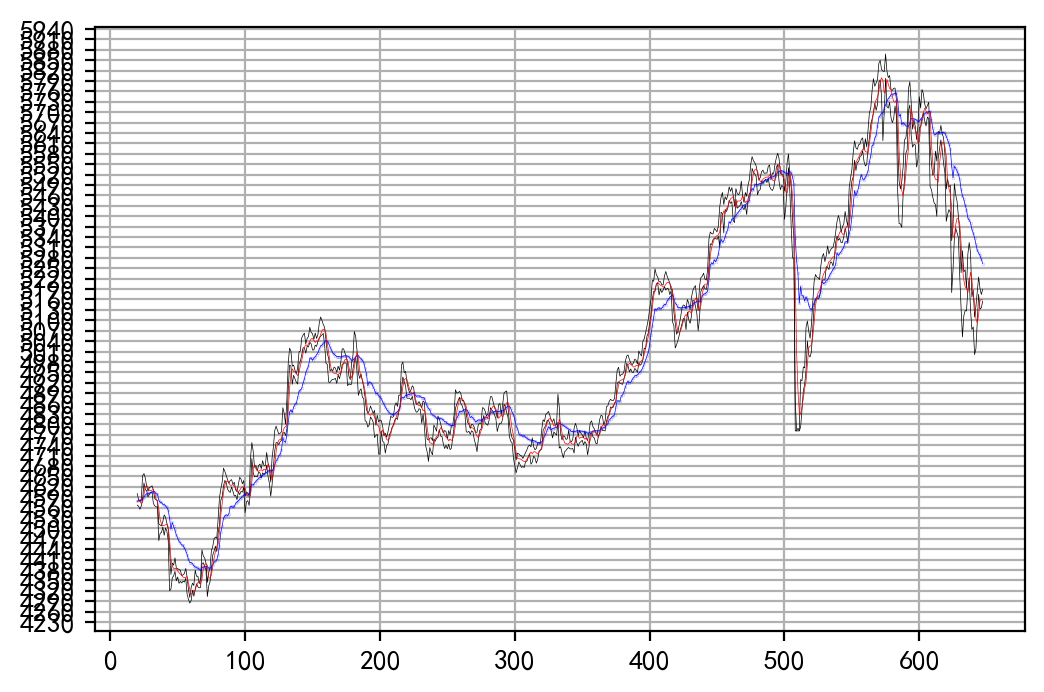

In [32]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
plt.figure()
st = 20
et = len(d1)
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*2
plt.plot(h1[0][st:et],'k',linewidth=0.25)
plt.plot(l1[0][st:et],'k',linewidth=0.25)
plt.plot(AMA_11H[0][st:et],'b.-',linewidth=0.25, markersize=0.1)
#plt.plot(AMA_21H[0][st:et],'b',linewidth=0.25)
plt.plot(AMA1H[0][st:et],'r',linewidth=0.25)
plt.grid()
y_major_locator=MultipleLocator(30)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.yaxis.set_major_locator(y_major_locator)
#把x轴的主刻度设置为1的倍数


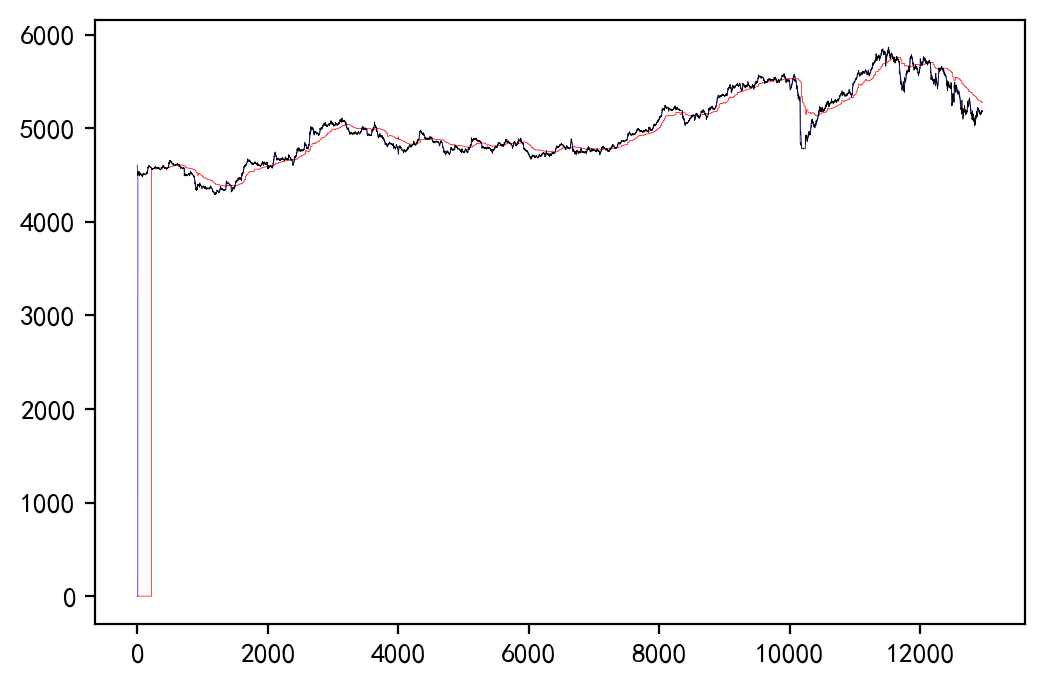

In [34]:
plt.plot(AMA_hourH[:-1],'r-',lineWidth=0.25)
plt.plot(np.array(AMA_1[0][:-1]),'b-', lineWidth=0.25)
plt.plot(np.array(high_mtx[0][:-1]),'k-', lineWidth=0.25)

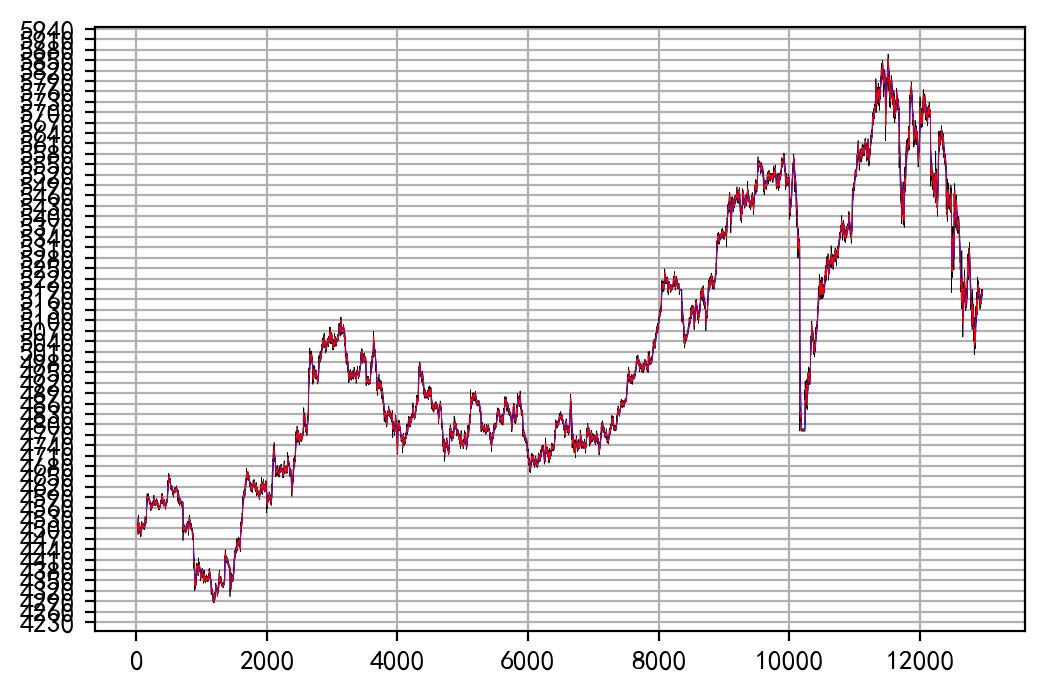

In [35]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
plt.figure()
st = 20
et = len(dtes)
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*2
plt.plot(high_mtx[0][st:et],'k',linewidth=0.25)
plt.plot(low_mtx[0][st:et],'k',linewidth=0.25)
plt.plot(AMA_1[0][st:et],'b',linewidth=0.25)
plt.plot(AMA_2[0][st:et],'b',linewidth=0.25)
plt.plot(AMA[0][st:et],'r',linewidth=0.25)
plt.grid()
y_major_locator=MultipleLocator(30)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.yaxis.set_major_locator(y_major_locator)
#把x轴的主刻度设置为1的倍数


In [22]:
dtes[-1]

20200320.15

20190722.1003 4498.034942932261 4540.260832253941 4498.085384240973 AMA破下轨, 前低设定为: 4471.0  卖开点设定为: 4501.0
20190722.1006 到达卖出点: 4501.0
20190722.1006 到达止损点: 4531.0
20190722.1039 4506.709193210172 4523.204276747871 4507.890271138179 AMA破下轨, 前低设定为: 4500.0  卖开点设定为: 4530.0
20190722.1048 创新低: 4497.4  更新做空价: 4527.4
20190722.11 创新低: 4496.0  更新做空价: 4526.0
20190722.1103 创新低: 4493.2  更新做空价: 4523.2
20190722.1106 创新低: 4486.4  更新做空价: 4516.4
20190722.1109 创新低: 4482.2  更新做空价: 4512.2
20190722.1121 到达卖出点: 4512.2
20190722.143 到达止赢点: 4483.2
20190722.1448 创新低: 4475.0  更新做空价: 4505.0
20190723.0957 到达卖出点: 4505.0
20190724.0933 到达止损点: 4535.0
20190724.113 4585.551679297091 4590.821217276375 4586.27491967221 AMA破下轨, 前低设定为: 4579.4  卖开点设定为: 4609.4
20190724.1306 创新低: 4576.0  更新做空价: 4606.0
20190724.1309 创新低: 4575.2  更新做空价: 4605.2
20190724.1312 创新低: 4575.0  更新做空价: 4605.0
20190724.133 创新低: 4574.0  更新做空价: 4604.0
20190724.1333 创新低: 4573.2  更新做空价: 4603.2
20190724.1339 创新低: 4571.2  更新做空价: 4601.2
20190724.1342 创新低: 4569.6  更

20190924.1436 创新低: 4964.0  更新做空价: 4994.0
20190924.1439 创新低: 4956.2  更新做空价: 4986.2
20190924.1448 创新低: 4950.4  更新做空价: 4980.4
20190925.0933 创新低: 4931.2  更新做空价: 4961.2
20190925.0936 创新低: 4924.6  更新做空价: 4954.6
20190925.0948 创新低: 4924.0  更新做空价: 4954.0
20190925.0954 创新低: 4918.0  更新做空价: 4948.0
20190925.0957 创新低: 4909.0  更新做空价: 4939.0
20190925.1 创新低: 4900.6  更新做空价: 4930.6
20190925.1003 创新低: 4896.0  更新做空价: 4926.0
20190925.1015 创新低: 4888.2  更新做空价: 4918.2
20190925.1018 创新低: 4883.4  更新做空价: 4913.4
20190925.1036 到达卖出点: 4913.4
20190925.1303 到达止损点: 4943.4
20190925.1415 4906.695362090406 4914.089120273917 4906.7198695365205 AMA破下轨, 前低设定为: 4900.0  卖开点设定为: 4930.0
20190925.143 创新低: 4899.2  更新做空价: 4929.2
20190925.1433 创新低: 4895.0  更新做空价: 4925.0
20190925.1436 到达卖出点: 4925.0
20190925.1454 到达止赢点: 4896.0
20190925.1457 创新低: 4886.6  更新做空价: 4916.6
20190925.15 创新低: 4878.0  更新做空价: 4908.0
20190926.0948 创新低: 4874.0  更新做空价: 4904.0
20190926.1003 到达卖出点: 4904.0
20190926.103 到达止赢点: 4875.0
20190926.1033 创新低: 4868.6  更新做空价: 4

20191120.133 创新低: 4807.2  更新做空价: 4837.2
20191120.1333 创新低: 4803.2  更新做空价: 4833.2
20191120.1345 创新低: 4803.0  更新做空价: 4833.0
20191120.1415 创新低: 4801.0  更新做空价: 4831.0
20191120.1421 创新低: 4796.6  更新做空价: 4826.6
20191120.1424 创新低: 4794.2  更新做空价: 4824.2
20191120.1427 创新低: 4788.0  更新做空价: 4818.0
20191120.143 创新低: 4786.0  更新做空价: 4816.0
20191120.1433 创新低: 4784.2  更新做空价: 4814.2
20191120.1445 创新低: 4782.0  更新做空价: 4812.0
20191121.0933 创新低: 4760.8  更新做空价: 4790.8
20191121.1009 到达卖出点: 4790.8
20191122.0936 到达止损点: 4820.8
20191122.1039 4848.5403823666575 4858.665371861596 4849.311003055065 AMA破下轨, 前低设定为: 4840.2  卖开点设定为: 4870.2
20191122.1042 创新低: 4830.0  更新做空价: 4860.0
20191122.1048 创新低: 4829.0  更新做空价: 4859.0
20191122.1051 创新低: 4822.0  更新做空价: 4852.0
20191122.1054 创新低: 4810.2  更新做空价: 4840.2
20191122.1057 创新低: 4800.0  更新做空价: 4830.0
20191122.1103 创新低: 4789.0  更新做空价: 4819.0
20191122.1106 创新低: 4755.0  更新做空价: 4785.0
20191122.1112 到达卖出点: 4785.0
20191122.1118 到达止赢点: 4756.0
20191122.1121 创新低: 4731.6  更新做空价: 4761.6
2019

20200205.1118 5050.758626931809 5066.725368416166 5052.59482876972 AMA破下轨, 前低设定为: 5040.0  卖开点设定为: 5070.0
20200205.1321 创新低: 5032.0  更新做空价: 5062.0
20200205.1324 创新低: 5026.0  更新做空价: 5056.0
20200205.1327 创新低: 5022.6  更新做空价: 5052.6
20200205.133 创新低: 5022.0  更新做空价: 5052.0
20200205.1333 创新低: 5019.0  更新做空价: 5049.0
20200205.1336 创新低: 5013.0  更新做空价: 5043.0
20200205.1339 创新低: 5007.0  更新做空价: 5037.0
20200205.1342 创新低: 5006.0  更新做空价: 5036.0
20200205.1348 创新低: 5005.0  更新做空价: 5035.0
20200205.1351 创新低: 5002.6  更新做空价: 5032.6
20200205.1357 创新低: 5000.2  更新做空价: 5030.2
20200205.14 创新低: 5000.0  更新做空价: 5030.0
20200205.1406 到达卖出点: 5030.0
20200205.1421 到达止赢点: 5001.0
20200205.1424 创新低: 4994.2  更新做空价: 5024.2
20200205.1436 到达卖出点: 5024.2
20200206.0939 到达止损点: 5054.2
20200206.1433 5179.09410378597 5199.618114176866 5182.018168389465 AMA破下轨, 前低设定为: 5159.6  卖开点设定为: 5189.6
20200206.1439 到达卖出点: 5189.6
20200207.1021 到达止损点: 5219.6
20200207.1057 5184.854712778273 5200.2220492629585 5185.781785852278 AMA破下轨, 前低设定为: 5162.6  

20200305.1021 5671.744553850504 5687.814563858075 5672.258399264335 AMA破下轨, 前低设定为: 5658.6  卖开点设定为: 5688.6
20200305.1024 创新低: 5654.8  更新做空价: 5684.8
20200305.103 到达卖出点: 5684.8
20200305.1312 到达止损点: 5714.8
20200305.1406 5713.799521419076 5731.712663958425 5716.0740243879045 AMA破下轨, 前低设定为: 5699.0  卖开点设定为: 5729.0
20200305.1409 到达卖出点: 5729.0
20200306.0933 到达止赢点: 5700.0
20200306.0936 创新低: 5678.2  更新做空价: 5708.2
20200306.0945 到达卖出点: 5708.2
20200306.1021 到达止赢点: 5679.2
20200306.1027 到达卖出点: 5705.0
20200306.1103 到达止赢点: 5676.0
20200306.1118 创新低: 5666.2  更新做空价: 5696.2
20200306.1121 创新低: 5660.4  更新做空价: 5690.4
20200306.1127 到达卖出点: 5690.4
20200306.1403 到达止损点: 5720.4
20200306.1427 5696.723333538044 5709.588088379977 5696.8318518383985 AMA破下轨, 前低设定为: 5685.2  卖开点设定为: 5715.2
20200306.15 创新低: 5681.0  更新做空价: 5711.0
20200309.0933 创新低: 5567.0  更新做空价: 5597.0
20200309.0936 到达卖出点: 5597.0
20200309.0939 到达止赢点: 5568.0
20200309.0942 创新低: 5521.4  更新做空价: 5551.4
20200309.0945 创新低: 5496.8  更新做空价: 5526.8
20200309.0948 创新低: 

Text(0.5, 1.0, '空')

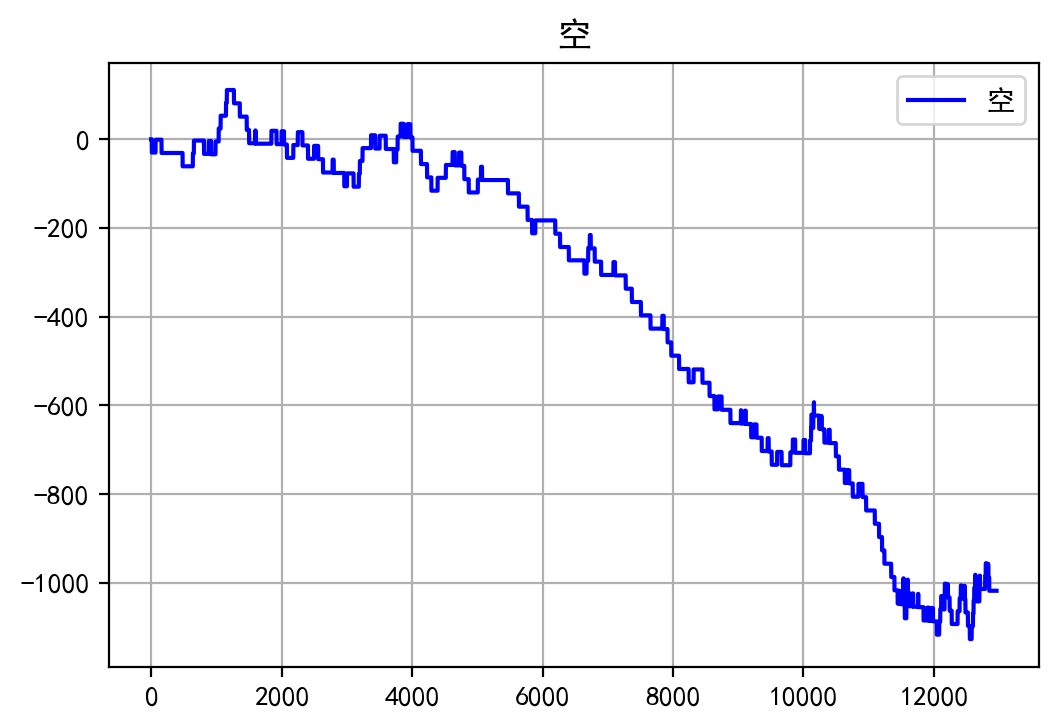

In [23]:
# 做空
sellInPrice = -1
atrW = 30
atrH = 30
atrS = 30
status = 'idle'
pnl = []
pnlShort = np.zeros(AMA_1.shape)
dtesPnl = []
AmlifyLine = 0 # 增加突破难度
for i in range(5,len(AMA[0])):
    #print(dtes[i], 'low=', np.round(low_mtx[0][i],2), ' EMA_lowM=', np.round(EMA_lowM[0][i],2), ' AMA=',np.round(AMA[0][i],2),', AMA1=',np.round(AMA_1[0][i],2), ', AMA2=',np.round(AMA_2[0][i],2), ' low_mtx=', np.round(low_mtx[0][i],2))
    #print((AMA[0][i-1]>=(AMA_2[0][i-1]+AmlifyLine)), (AMA[0][i]<(AMA_2[0][i]+AmlifyLine)),  (status=='idle'), (high_mtx[0][i]<=AMA_hourL[i]))
    #修正：破位需要前一个AMA轨道内，此AMA在轨道外
#    if (AMA[0][i-1]>=(AMA_2[0][i-1]+AmlifyLine)) & (AMA[0][i]<(AMA_2[0][i]+AmlifyLine)) & (status=='idle') & (high_mtx[0][i]<=AMA_hourL[i]):
    if (AMA[0][i-1]>=(AMA_2[0][i-1]+AmlifyLine)) & (AMA[0][i]<(AMA_2[0][i]+AmlifyLine)) & (status=='idle'):
        clow = np.min(low_mtx[0][i-4:i+1])  # 修正：使用前4根到此时的K线的最低点
        sellInPrice = clow+atrH # 如果AMA<下轨， 且处于空闲状态， 则进入等待状态，且做空价=当前K线最低价+ATRH
        status='wait'
        print(dtes[i], AMA[0][i], AMA_1[0][i], AMA_2[0][i],'AMA破下轨, 前低设定为:',clow, ' 卖开点设定为:',sellInPrice)#,' AMA=',np.round(AMA[0][i],2), ', AMA1=',np.round(AMA_1[0][i],2))
        continue
    if (status=='wait'):
        if (high_mtx[0][i]>=sellInPrice): # 如果处于等待状态，且当前K线最高价格高于做空价，则做空
            status='short'
            print(dtes[i], '到达卖出点:',sellInPrice)#, 'AMA=',np.round(AMA[0][i],2), ', AMA1=',np.round(AMA_1[0][i],2))
#            continue #修改
        if (low_mtx[0][i]+atrH)<sellInPrice: # 如果处于等待状态，还没有做空，且创新低，则更新做空价=当前最低价+ATRH
            sellInPrice=low_mtx[0][i]+atrH
            print(dtes[i], '创新低:',low_mtx[0][i],' 更新做空价:',sellInPrice)#', AMA=',AMA[0][i], ', AMA1=',AMA_1[0][i])
#            continue #修改
    if (status=='short'):
        if (high_mtx[0][i]>=sellInPrice+atrS): # 最高价高于卖出价+ATRS，说明止损
            profit = -atrS
            pnl.append(profit)
            pnlShort[i] = profit
            print(dtes[i],'到达止损点:',sellInPrice+atrS)
            dtesPnl.append(dtes[i])
            status='idle'
#            continue #修改
        if (low_mtx[0][i]<=sellInPrice-atrW+1): # 最低价低于卖出价-ATRW， 说明止盈
            profit = atrW-1
            pnl.append(profit)
            pnlShort[i] = profit
            dtesPnl.append(dtes[i])
            print(dtes[i],'到达止赢点:',sellInPrice-atrW+1)
            status='wait'
            sellInPrice = low_mtx[0][i]+atrH #修改
#            continue #修改
        
plt.plot(np.cumsum(pnlShort), 'b')
plt.grid()
plt.legend(['空'])
plt.title('空')        

20190722.1127 4519.152978928407 4513.253701427089 4503.460754696523 AMA破上轨, 前高设定为: 4538.0  买入点设定为: 4508.0
20190722.1306 到达买入点: 4508.0
20190722.1448 到达止损点: 4478.0
20190723.0945 4494.415721695664 4494.195564942257 4486.05436551294 AMA破上轨, 前高设定为: 4501.2  买入点设定为: 4471.2
20190723.0954 创新高: 4503.8  更新买入价: 4473.8
20190723.0957 创新高: 4510.0  更新买入价: 4480.0
20190723.1 创新高: 4518.6  更新买入价: 4488.6
20190723.1003 创新高: 4520.0  更新买入价: 4490.0
20190723.1403 创新高: 4533.8  更新买入价: 4503.8
20190724.0933 创新高: 4570.0  更新买入价: 4540.0
20190724.0936 创新高: 4578.2  更新买入价: 4548.2
20190724.0939 创新高: 4580.0  更新买入价: 4550.0
20190724.0942 创新高: 4582.0  更新买入价: 4552.0
20190724.0948 创新高: 4583.2  更新买入价: 4553.2
20190724.1003 创新高: 4596.8  更新买入价: 4566.8
20190724.1006 创新高: 4600.6  更新买入价: 4570.6
20190724.1342 到达买入点: 4570.6
20190726.1442 到达止赢点: 4599.6
20190729.0948 创新高: 4600.2  更新买入价: 4570.2
20190729.1021 到达买入点: 4570.2
20190730.0933 到达止赢点: 4599.2
20190730.0942 创新高: 4611.6  更新买入价: 4581.6
20190730.0945 创新高: 4622.0  更新买入价: 4592.0
20190730.

20190924.1045 创新高: 5006.0  更新买入价: 4976.0
20190924.1048 创新高: 5007.4  更新买入价: 4977.4
20190924.11 创新高: 5014.8  更新买入价: 4984.8
20190924.1103 创新高: 5028.6  更新买入价: 4998.6
20190924.1106 创新高: 5033.8  更新买入价: 5003.8
20190924.1109 创新高: 5040.2  更新买入价: 5010.2
20190924.1118 创新高: 5049.6  更新买入价: 5019.6
20190924.1121 创新高: 5059.8  更新买入价: 5029.8
20190924.1124 创新高: 5068.0  更新买入价: 5038.0
20190924.1303 到达买入点: 5038.0
20190924.1339 到达止损点: 5008.0
20190925.1115 4920.830384127516 4918.584485416855 4909.179960557117 AMA破上轨, 前高设定为: 4932.6  买入点设定为: 4902.6
20190925.113 到达买入点: 4902.6
20190925.1303 到达止赢点: 4931.6
20190925.1306 到达买入点: 4915.0
20190925.15 到达止损点: 4885.0
20190927.0948 4818.453530242912 4817.883926256097 4807.751438462635 AMA破上轨, 前高设定为: 4833.8  买入点设定为: 4803.8
20190927.0951 创新高: 4836.6  更新买入价: 4806.6
20190927.0954 创新高: 4838.0  更新买入价: 4808.0
20190927.1012 创新高: 4838.2  更新买入价: 4808.2
20190927.1039 创新高: 4846.2  更新买入价: 4816.2
20190927.1042 创新高: 4849.0  更新买入价: 4819.0
20190927.11 创新高: 4851.2  更新买入价: 4821.2
20190927.110

20191203.1336 创新高: 4785.0  更新买入价: 4755.0
20191203.1339 创新高: 4789.8  更新买入价: 4759.8
20191203.1342 创新高: 4790.0  更新买入价: 4760.0
20191203.1412 创新高: 4796.0  更新买入价: 4766.0
20191203.1427 创新高: 4797.4  更新买入价: 4767.4
20191203.143 创新高: 4800.0  更新买入价: 4770.0
20191203.1433 创新高: 4801.0  更新买入价: 4771.0
20191203.1445 创新高: 4802.0  更新买入价: 4772.0
20191203.1448 创新高: 4805.6  更新买入价: 4775.6
20191203.1454 创新高: 4806.0  更新买入价: 4776.0
20191203.15 创新高: 4814.6  更新买入价: 4784.6
20191204.0936 创新高: 4815.0  更新买入价: 4785.0
20191204.0942 创新高: 4815.8  更新买入价: 4785.8
20191204.0945 创新高: 4826.2  更新买入价: 4796.2
20191204.1 到达买入点: 4796.2
20191205.0942 到达止赢点: 4825.2
20191205.0948 创新高: 4829.2  更新买入价: 4799.2
20191205.0951 创新高: 4829.6  更新买入价: 4799.6
20191205.0954 创新高: 4830.8  更新买入价: 4800.8
20191205.0957 创新高: 4833.4  更新买入价: 4803.4
20191205.1 创新高: 4841.0  更新买入价: 4811.0
20191205.1003 创新高: 4844.4  更新买入价: 4814.4
20191205.1006 创新高: 4846.0  更新买入价: 4816.0
20191205.1027 创新高: 4848.0  更新买入价: 4818.0
20191205.103 创新高: 4851.0  更新买入价: 4821.0
20191205.10

20191230.1309 创新高: 5204.2  更新买入价: 5174.2
20191230.1312 创新高: 5216.4  更新买入价: 5186.4
20191230.1327 到达买入点: 5186.4
20191230.1357 到达止赢点: 5215.4
20191230.1406 到达买入点: 5193.0
20191230.1433 到达止赢点: 5222.0
20191231.0936 创新高: 5228.0  更新买入价: 5198.0
20191231.0942 创新高: 5233.4  更新买入价: 5203.4
20191231.1003 创新高: 5236.0  更新买入价: 5206.0
20191231.1039 到达买入点: 5206.0
20191231.143 到达止赢点: 5235.0
20191231.1433 创新高: 5244.0  更新买入价: 5214.0
20191231.1436 创新高: 5244.6  更新买入价: 5214.6
20200102.0933 创新高: 5280.0  更新买入价: 5250.0
20200102.0942 创新高: 5284.4  更新买入价: 5254.4
20200102.0945 创新高: 5286.6  更新买入价: 5256.6
20200102.0948 创新高: 5288.0  更新买入价: 5258.0
20200102.0951 创新高: 5299.6  更新买入价: 5269.6
20200102.0954 创新高: 5315.0  更新买入价: 5285.0
20200102.0957 创新高: 5319.8  更新买入价: 5289.8
20200102.1 创新高: 5325.0  更新买入价: 5295.0
20200102.1006 创新高: 5328.0  更新买入价: 5298.0
20200102.1015 创新高: 5330.0  更新买入价: 5300.0
20200102.1027 创新高: 5334.0  更新买入价: 5304.0
20200102.103 创新高: 5334.8  更新买入价: 5304.8
20200102.1036 创新高: 5342.8  更新买入价: 5312.8
20200102.1042 创新高

20200205.0951 创新高: 5030.8  更新买入价: 5000.8
20200205.0957 创新高: 5050.0  更新买入价: 5020.0
20200205.1 创新高: 5053.0  更新买入价: 5023.0
20200205.1012 创新高: 5056.0  更新买入价: 5026.0
20200205.1021 创新高: 5073.0  更新买入价: 5043.0
20200205.1024 创新高: 5079.6  更新买入价: 5049.6
20200205.1036 创新高: 5091.2  更新买入价: 5061.2
20200205.1039 创新高: 5096.8  更新买入价: 5066.8
20200205.1045 创新高: 5098.0  更新买入价: 5068.0
20200205.1048 到达买入点: 5068.0
20200205.1321 到达止损点: 5038.0
20200205.1445 5029.099672278332 5026.800075076039 5013.161806197237 AMA破上轨, 前高设定为: 5040.8  买入点设定为: 5010.8
20200205.1451 创新高: 5045.2  更新买入价: 5015.2
20200205.1454 创新高: 5048.0  更新买入价: 5018.0
20200206.0936 到达买入点: 5018.0
20200206.0939 到达止赢点: 5047.0
20200206.0942 创新高: 5079.0  更新买入价: 5049.0
20200206.0948 到达买入点: 5049.0
20200206.1012 到达止赢点: 5078.0
20200206.1033 创新高: 5091.0  更新买入价: 5061.0
20200206.1039 创新高: 5093.8  更新买入价: 5063.8
20200206.1042 创新高: 5098.0  更新买入价: 5068.0
20200206.1103 创新高: 5124.0  更新买入价: 5094.0
20200206.1106 创新高: 5127.8  更新买入价: 5097.8
20200206.1109 创新高: 5130.0  更新买入价

20200224.1118 5761.339551389638 5758.8890376588415 5746.043935155288 AMA破上轨, 前高设定为: 5776.0  买入点设定为: 5746.0
20200224.1121 创新高: 5782.0  更新买入价: 5752.0
20200224.1124 创新高: 5783.0  更新买入价: 5753.0
20200224.113 创新高: 5794.0  更新买入价: 5764.0
20200224.1303 创新高: 5799.0  更新买入价: 5769.0
20200224.1309 创新高: 5802.4  更新买入价: 5772.4
20200224.1315 创新高: 5804.4  更新买入价: 5774.4
20200224.1318 创新高: 5817.0  更新买入价: 5787.0
20200224.1321 创新高: 5826.0  更新买入价: 5796.0
20200224.1324 创新高: 5830.4  更新买入价: 5800.4
20200224.1327 创新高: 5837.8  更新买入价: 5807.8
20200224.1333 到达买入点: 5807.8
20200224.1351 到达止赢点: 5836.8
20200224.1403 创新高: 5842.0  更新买入价: 5812.0
20200224.1424 创新高: 5848.0  更新买入价: 5818.0
20200224.1427 创新高: 5849.6  更新买入价: 5819.6
20200224.1436 到达买入点: 5819.6
20200225.0933 到达止损点: 5789.6
20200225.1024 5811.613510668789 5810.193591295883 5796.536332076128 AMA破上轨, 前高设定为: 5823.2  买入点设定为: 5793.2
20200225.1042 到达买入点: 5793.2
20200225.1051 到达止损点: 5763.2
20200225.1315 5742.538747217513 5736.13728898435 5716.562224634688 AMA破上轨, 前高设定为: 5760.

20200317.1051 5162.167554962167 5155.791063187653 5129.385284166029 AMA破上轨, 前高设定为: 5194.6  买入点设定为: 5164.6
20200317.1054 到达买入点: 5164.6
20200317.1106 到达止赢点: 5193.6
20200317.1109 创新高: 5211.6  更新买入价: 5181.6
20200317.1115 到达买入点: 5181.6
20200317.113 到达止赢点: 5210.6
20200317.1303 创新高: 5246.0  更新买入价: 5216.0
20200317.1312 到达买入点: 5216.0
20200317.1315 到达止损点: 5186.0
20200317.1427 5173.297403141138 5172.473601275155 5149.66664300906 AMA破上轨, 前高设定为: 5192.0  买入点设定为: 5162.0
20200317.143 到达买入点: 5162.0
20200318.0933 到达止赢点: 5191.0
20200318.0936 创新高: 5226.0  更新买入价: 5196.0
20200318.0939 创新高: 5233.6  更新买入价: 5203.6
20200318.0942 创新高: 5235.0  更新买入价: 5205.0
20200318.0945 创新高: 5239.4  更新买入价: 5209.4
20200318.0948 创新高: 5261.2  更新买入价: 5231.2
20200318.0951 创新高: 5273.4  更新买入价: 5243.4
20200318.0954 创新高: 5279.6  更新买入价: 5249.6
20200318.1 创新高: 5290.0  更新买入价: 5260.0
20200318.1006 到达买入点: 5260.0
20200318.1018 到达止损点: 5230.0
20200318.1054 5257.665175634986 5256.657253605001 5236.427976584191 AMA破上轨, 前高设定为: 5278.0  买入点设定为: 5248.

Text(0.5, 1.0, '多')

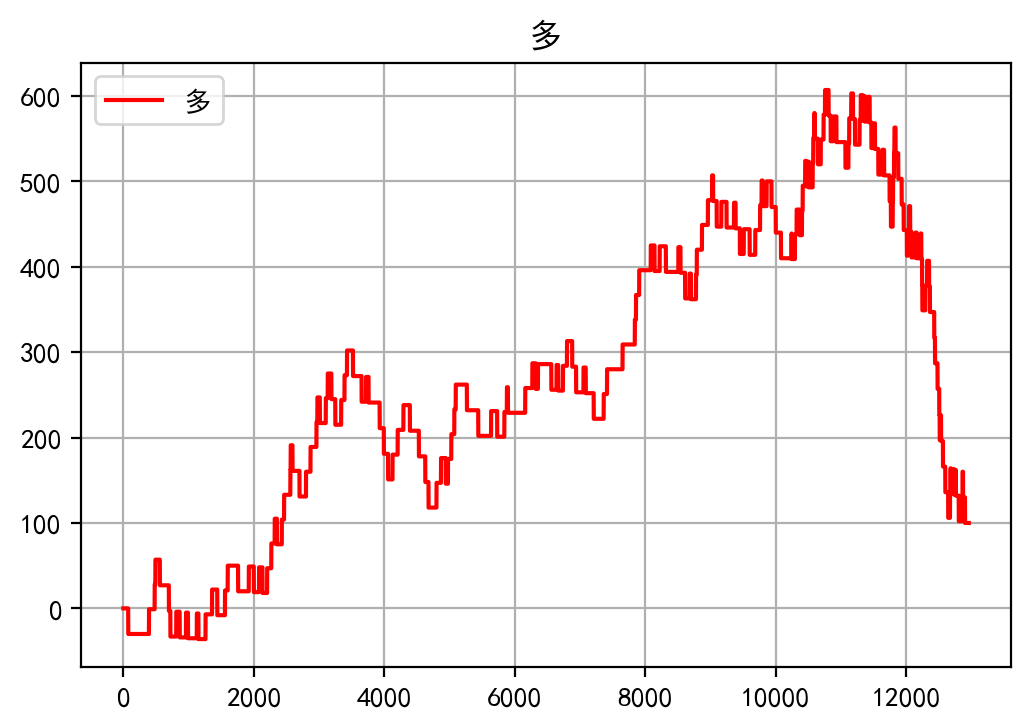

In [24]:
# 1. 修正continue
# 2. 增加
# 做多
buyInPrice = -1
atrW = 30
atrH = 30
atrS = 30
status = 'idle'
pnl = []
pnlLong = np.zeros(AMA_1.shape)
dtesPnl = []
AmlifyLine = 0 # 增加突破难度
for i in range(5, len(AMA[0])):
#    print(dtes[i],' AMA=',np.round(AMA[0][i],2),', AMA1=',np.round(AMA_1[0][i],2), ', AMA2=',np.round(AMA_2[0][i],2), ' low_mtx=', np.round(low_mtx[0][i],2))
#    if (AMA[0][i-1]<=(AMA_1[0][i]+AmlifyLine))&(AMA[0][i]>AMA_2[0][i]+AmlifyLine))&(status=='idle')&(low_mtx[0][i]>=AMA_hourH[i]):
    if (AMA[0][i-1]<=(AMA_1[0][i]+AmlifyLine))&(AMA[0][i]>AMA_1[0][i]+AmlifyLine)&(status=='idle'):
        chigh = np.max(high_mtx[0][i-4:i+1])
        buyInPrice = chigh-atrH # 如果AMA>上轨， 且处于空闲状态， 则进入等待状态，且买入价=当前K线最高价-ATRH
        status='wait'
        print(dtes[i], AMA[0][i], AMA_1[0][i], AMA_2[0][i], 'AMA破上轨, 前高设定为:',chigh, ' 买入点设定为:',buyInPrice)#,' AMA=',np.round(AMA[0][i],2), ', AMA2=',np.round(AMA_2[0][i],2))
        continue # 修改
    if (status=='wait'): 
        if (low_mtx[0][i]<=buyInPrice): # 如果处于等待状态，且当前K线最低价格低于买入价，则买入
            status='long'
            print(dtes[i], '到达买入点:',buyInPrice)#, 'AMA=',np.round(AMA[0][i],2), ', AMA1=',np.round(AMA_1[0][i],2))
            continue #修改
        if (high_mtx[0][i]-atrH)>buyInPrice: # 如果处于等待状态，还没有买入，且创新高，则更新买入价=当前最高价-ATRH
            buyInPrice=high_mtx[0][i]-atrH
            print(dtes[i], '创新高:',high_mtx[0][i],' 更新买入价:',buyInPrice)#', AMA=',AMA[0][i], ', AMA1=',AMA_1[0][i])
            continue #修改
    if (status=='long'):
        if (low_mtx[0][i]<=buyInPrice-atrS): # 最低价小于买入价-ATRS，说明止损
            profit = -atrS
            pnl.append(profit)
            pnlLong[i] = profit
            print(dtes[i],'到达止损点:',buyInPrice-atrS)
            dtesPnl.append(dtes[i])
            status='idle'
            continue #修改
        if (high_mtx[0][i]>=buyInPrice+atrW-1): # 最高价高于买入价+ATRW， 说明止盈
            profit = atrW-1
            pnl.append(profit)
            pnlLong[i] = profit
            dtesPnl.append(dtes[i])
            print(dtes[i],'到达止赢点:',buyInPrice+atrW-1)
            status='wait'  #修改
            buyInPrice = high_mtx[0][i]-atrH #修改
            continue #修改
        
plt.plot(np.cumsum(pnlLong),'r')
plt.grid()
plt.legend(['多'])
plt.title('多')
        

In [25]:
print(list(dtes))

[20190722.0933, 20190722.0936, 20190722.0939, 20190722.0942, 20190722.0945, 20190722.0948, 20190722.0951, 20190722.0954, 20190722.0957, 20190722.1, 20190722.1003, 20190722.1006, 20190722.1009, 20190722.1012, 20190722.1015, 20190722.1018, 20190722.1021, 20190722.1024, 20190722.1027, 20190722.103, 20190722.1033, 20190722.1036, 20190722.1039, 20190722.1042, 20190722.1045, 20190722.1048, 20190722.1051, 20190722.1054, 20190722.1057, 20190722.11, 20190722.1103, 20190722.1106, 20190722.1109, 20190722.1112, 20190722.1115, 20190722.1118, 20190722.1121, 20190722.1124, 20190722.1127, 20190722.113, 20190722.1303, 20190722.1306, 20190722.1309, 20190722.1312, 20190722.1315, 20190722.1318, 20190722.1321, 20190722.1324, 20190722.1327, 20190722.133, 20190722.1333, 20190722.1336, 20190722.1339, 20190722.1342, 20190722.1345, 20190722.1348, 20190722.1351, 20190722.1354, 20190722.1357, 20190722.14, 20190722.1403, 20190722.1406, 20190722.1409, 20190722.1412, 20190722.1415, 20190722.1418, 20190722.1421, 2019

Text(0.5, 1.0, '多+空')

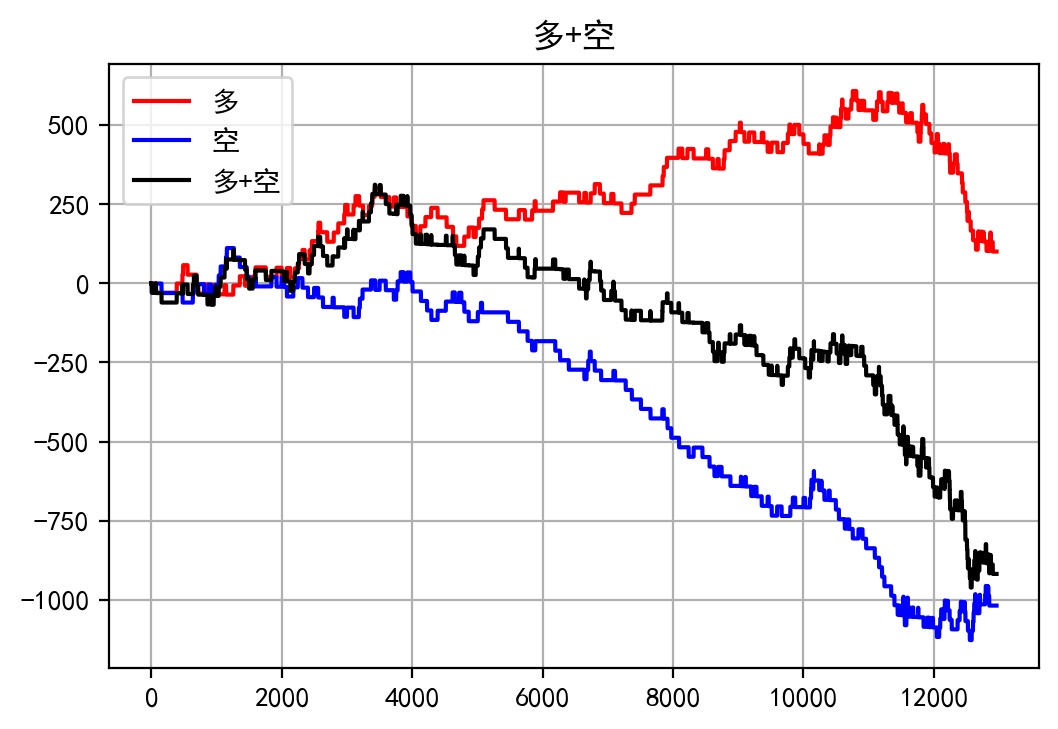

In [26]:
plt.plot(np.cumsum(pnlLong),'r')
plt.plot(np.cumsum(pnlShort), 'b')
plt.plot(np.cumsum(pnlLong+pnlShort),'k')
plt.grid()
plt.legend(['多','空','多+空'])
plt.title('多+空')

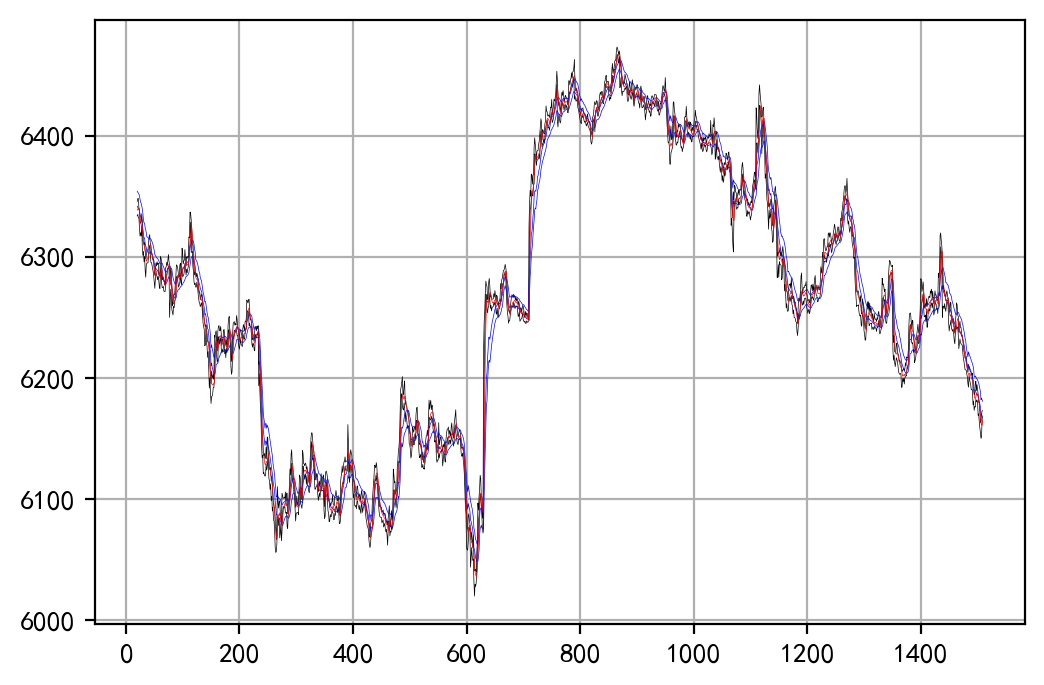

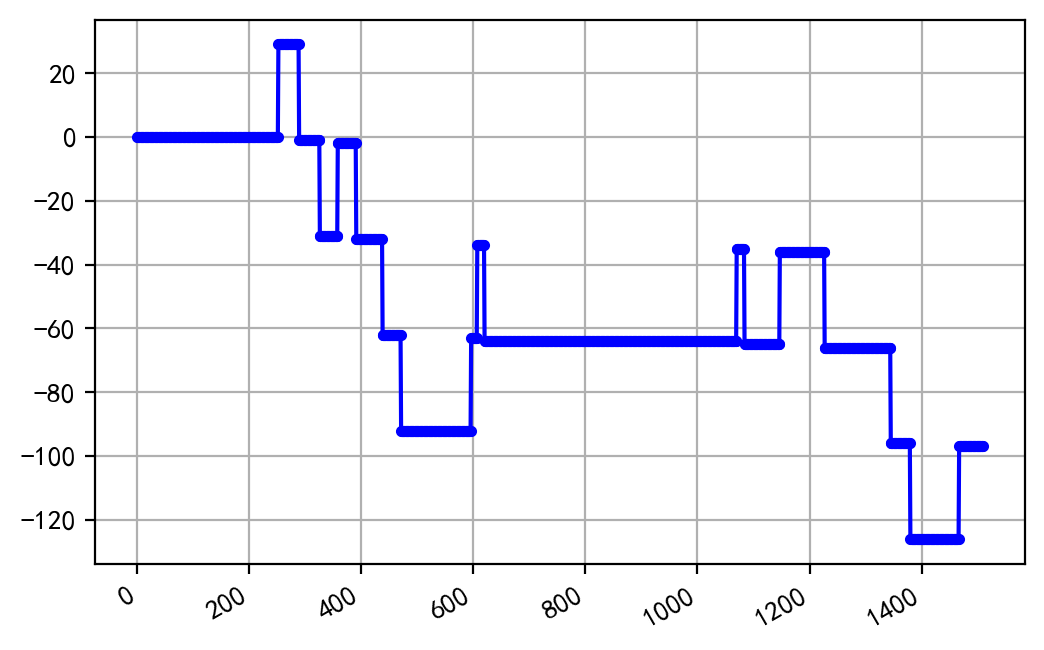

In [152]:
#for (i,x) in enumerate(dtesPnl):
#    print(x, pnl[i])
plt.figure()
st = 20
et = len(dtes)
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*2
plt.plot(high_mtx[0][st:et],'k',linewidth=0.25)
plt.plot(low_mtx[0][st:et],'k',linewidth=0.25)
plt.plot(AMA_1[0][st:et],'b',linewidth=0.25)
plt.plot(AMA_2[0][st:et],'b',linewidth=0.25)
plt.plot(AMA[0][st:et],'r',linewidth=0.25)
plt.grid()
def dtes2Label(dtes):
    return np.array([datetime.strptime(str(int(np.floor(d))), '%Y%m%d').date() for d in dtes])
plt.figure()
plt.plot(np.cumsum(pnlShort),'b.-')
#plt.plot(np.cumsum(pnl),'b-')
plt.gcf().autofmt_xdate()  # 自动旋转日期标记
plt.grid()

In [153]:
AMA_hour[AMA_hour==0]= AMA_hour[1000]
AMA_1[0][AMA_1[0]==0]=AMA_1[0][1000]
AMA_hourL[AMA_hourL==0]= AMA_hourL[1000]
AMA_2[0][AMA_2[0]==0]=AMA_2[0][1000]


NameError: name 'AMA_hour' is not defined

In [ ]:
pnl2=pnl2.flatten()

In [ ]:
idx1 = np.nonzero(pnl2>0)[0]
idx2 = np.nonzero(pnl2<0)[0]
k = np.array(range(len(pnl2)))


In [ ]:
plt.plot(np.cumsum(pnl2))

In [ ]:
plt.plot(AMA_hourL,'r-', lineWidth=0.25)
plt.plot(np.array(AMA_2[0]),'b-', lineWidth=0.25)
plt.scatter(k[idx1], AMA_hourL[idx1],s=0.25,c='red')
plt.scatter(k[idx2], AMA_hourL[idx2],s=0.25,c='green')
plt.grid()

In [ ]:
dtes